Task 1

In [1005]:
import pandas as pd
import numpy as np
import pandas_read_xml as pdx
import json
from scipy import stats
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 
import seaborn as sns
import math

xml had 2 errors that needed to be fixed, first was that all the property tags were not enclosed in a main properties tag which was fixed by adding a properties tag to enclose them all. Also the & symbol in the address were causing an error and had to removed and replace with a and with letters. Bellow you can see the xml file being read this way to show the fixed issues.

In [947]:
tree = ET.parse('31339646.xml') 

root = tree.getroot() 
print(root)
print(root[5][0].text)

<Element 'propertys' at 0x000002305969AC20>
14451


In [266]:
xm = open('31339646.xml','r').read()

In [267]:
js = open("31339646.json",'r').read()

In [76]:
person_dict = json.loads(js)

In [296]:
df_js = pd.DataFrame(li1) # initializing df

In [288]:
li1 = []# initializing list
li2 = []# initializing list
li3 = []# initializing list
li4 = []# initializing list

for i55 in range(len(person_dict)):
    li1.append(person_dict[i55]['property_id'])
    li2.append(person_dict[i55]['lat'])
    li3.append(person_dict[i55]['lng'])
    li4.append(person_dict[i55]['addr_street'])

In [299]:
df_js['property_id'] = li1
df_js['lat'] = li2
df_js['lng'] = li3
df_js['addr_street'] = li4

In [935]:
import re

xml_data = '''
<property>
  <property_id>94713</property_id>
  <lat>-37.923343</lat>
  <lng>145.050533</lng>
  <addr_street>120 Tucker Road</addr_street>
</property>
<property>
  <property_id>47698</property_id>
  <lat>-37.814819</lat>
  <lng>145.043364</lng>
  <addr_street>1/287 Barkers Road</addr_street>
</property>
'''

pattern = r"<property_id>(\d+)</property_id>"
property_ids = re.findall(pattern, xm)



In [937]:
pattern1 = r"<lat>([\d.-]+)<\/lat>"
lat = re.findall(pattern1, xm)

In [938]:
pattern2 = r"<lng>([\d.-]+)<\/lng>"
lng = re.findall(pattern2, xm)


In [945]:
pattern3 = r"<addr_street>(.+)<\/addr_street>"
addr_street = re.findall(pattern3, xm)

In [944]:
print(len(property_ids),len(lat),len(lng),len(addr_street))

1050 1050 1050 1050


In [387]:
df = pd.DataFrame({'property_id': property_ids,
     'lat': lat,
     'lng': lng,'addr_street': addr_street
    })

In [388]:
df2 = pd.DataFrame({'property_id': li1,
     'lat': li2,
     'lng': li3,'addr_street': li4
    })

In [389]:
df1 = pd.concat([df,df2])

In [390]:
df1['property_id'] = df1['property_id'].astype('int')

In [392]:
df1 = df1.drop_duplicates(subset='property_id', keep="first")

In [394]:
df_stops = pd.read_csv('stops.txt')

In [396]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    dlon = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6378 * c
    return km

In [397]:
def near(lat, long):
    dis = df_stops.apply(lambda row: dist(lat, long, row['stop_lat'], row['stop_lon']),axis = 1)
    return df_stops.loc[dis.idxmin(), 'stop_id']

In [399]:
df1['stop_id'] = df1.apply(lambda row: near(float(row['lat']), float(row['lng'])),axis=1)

In [403]:
df1.reset_index(drop=True)

property_id           lat          lng              addr_street  stop_id
0           94713    -37.923343   145.050533          120 Tucker Road    19938
1           47698    -37.814819   145.043364       1/287 Barkers Road    19903
2           60300  -37.81793213  145.2071991          8 Walter Street    19901
3           34246    -37.719426   145.014612         20 Howard Street    20010
4           71058     -37.86486   145.226388         11 Raheen Avenue    19871
...           ...           ...          ...                      ...      ...
2067        28948      -37.8092      144.998            27 Lithgow St    19977
2068        61075      -37.8095      145.241  1/292 Maroondah Highway    19879
2069        84789      -37.8818      144.981       23 Glenhuntly Road    19955
2070         5194      -37.8663      144.825         40 Romawi Street    19926
2071        96056      -37.9034      145.051       6 Wild Cherry Road    19941

[2072 rows x 5 columns]

In [401]:
df2 = df1
df2 = pd.merge(df2, df_stops,on='stop_id', how='left')

In [404]:
df2[df2.duplicated(subset=['property_id'])] 

Empty DataFrame
Columns: [property_id, lat, lng, addr_street, stop_id, stop_name, stop_short_name, stop_lat, stop_lon]
Index: []

In [405]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians,[lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2- lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6378 * c
    return km

In [406]:
df2['distance_to_closest_train_station'] = [haversine(float(df2.lng[i]),float(df2.lat[i]),df2.stop_lon[i],df2.stop_lat[i]) for i in range(len(df2))]

In [96]:
import geopandas as gpd
import shapefile

In [108]:
df_p = gpd.read_file('VIC_LOCALITY_POLYGON_shp.shp')

In [419]:
df2['suburb'] = None
for ind,x in enumerate(df_p['geometry']):
    for x1 in range(len(df2)):
        points = Point(df2['lng'][x1],df2['lat'][x1])
        if x.contains(points) == True:
            df2['suburb'][x1] = df_p['VIC_LOCA_2'][ind]

<ipython-input-419-55d10333665b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['suburb'][x1] = df_p['VIC_LOCA_2'][ind]


In [123]:
df2['sub'] = None
for ind,x in enumerate(df_p['geometry']):
    for x1 in range(len(dff)):
        points = Point(dff['lng'][x1],dff['lat'][x1])
        if x.contains(points) == True:
            dff['sub'][x1] = df_p['VIC_LOCA_2'][ind]

<ipython-input-123-5e57aeb5f401>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['sub'][x1] = df_p['VIC_LOCA_2'][ind]


In [116]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [100]:
points = Point(144.84145,-37.783143)

In [115]:
point = Point(df2['lng'][8],df2['lat'][8])
points = (123123,-132123)

In [80]:
df_shapes = pd.read_csv("shapes.txt")

In [92]:
df['VIC_LOCA_2'].unique()

array(['UNDERBOOL', 'NURRAN', 'WOORNDOO', ..., 'SOMERS', 'HMAS CERBERUS',
       'GLEN ALVIE'], dtype=object)

In [488]:
dff = pd.read_csv("sample_output.csv")

In [124]:
d12 = dff[['property_id','lat','lng','addr_street']]

property_id        lat         lng          addr_street       suburb  \
0          6076 -37.783143  144.841450    115 Cornwall Road     SUNSHINE   
1         40076 -37.695698  145.063461  22 Chaucer Crescent     BUNDOORA   
2         20299 -37.761231  144.964393      1/182 Albion St    BRUNSWICK   
3         59305 -37.824275  145.197623    10 Simpson Street      MITCHAM   
4         77582 -37.921211  145.164257      17 Wanda Street     MULGRAVE   
5         89691 -37.949498  145.019103    83 Vincent Street  SANDRINGHAM   
6         13303 -37.712215  144.773850        6 Cassinia Cl      DELAHEY   
7         36157 -37.674831  145.042293      128 Casey Drive        LALOR   
8         49477 -37.807359  145.071367      4 Monash Avenue       BALWYN   
9         23759 -37.642599  144.905745         7 Brae Court    GREENVALE   
10        57871 -37.811878  145.143231       24 Kerr Street    BLACKBURN   
11        67575 -37.739322  145.340911   55 Kingsburgh Lane     LILYDALE   
12        77723 -37.928555  145.175441    21 Lotus Crescent     MULGRAVE   
13        88701 -37.952342  145.038556      25 James Avenue      HIGHETT   
14        58099 -37.830111  145.151375      4 Ronley Street    BLACKBURN   

    number_of_houses  number_of_units  municipality  population aus_born_perc  \
0             4031.0           1779.0      Brimbank     30677.0           52%   
1             8943.0           3243.0    Whittlesea     24119.0           69%   
2             8835.0           8041.0      Moreland     20155.0           62%   
3             5802.0           3089.0    Whitehorse     14482.0           76%   
4             7213.0           1477.0        Monash     22093.0           60%   
5             3340.0           2563.0       Bayside      8146.0           79%   
6             2193.0            541.0      Brimbank     27356.0           64%   
7             8358.0           1216.0    Whittlesea     20717.0           52%   
8             4589.0           2796.0    Boroondara     13849.0           71%   
9             6480.0            251.0          Hume      9120.0           72%   
10            4821.0           2501.0    Whitehorse     27564.0           75%   
11            5989.0           2379.0  Yarra Ranges     13615.0           82%   
12            7213.0           1477.0        Monash     22093.0           60%   
13            3939.0           2524.0       Bayside      9299.0           73%   
14            4821.0           2501.0    Whitehorse     27564.0           75%   

   median_income median_house_price                lga  \
0           $929           $888,500               KNOX   
1         $1,172           $887,300            WODONGA   
2         $1,433         $1,276,200        MARIBYRNONG   
3         $1,424         $1,118,800       PORT PHILLIP   
4         $1,348         $1,022,400     MACEDON RANGES   
5         $1,836         $1,866,700           PYRENEES   
6         $1,491           $648,000             BULOKE   
7           $919           $684,400           KINGSTON   
8         $1,563         $2,409,900        HOBSONS BAY   
9         $1,730           $984,500            HORSHAM   
10        $1,387         $1,484,100    GREATER GEELONG   
11        $1,284           $913,900          FRANKSTON   
12        $1,348         $1,022,400     MACEDON RANGES   
13        $1,384         $1,344,600  GREATER DANDENONG   
14        $1,387         $1,484,100    GREATER GEELONG   

    closest_train_station_id  distance_to_closest_train_station  \
0                      20021                           0.963904   
1                      19984                           2.468252   
2                      19967                           0.326405   
3                      19900                           0.856256   
4                      19914                           2.946776   
5                      19948                           1.279807   
6                      20000                           1.234484   
7                      20

In [128]:
html = urlopen("http://house.speakingsame.com/profile.php?q=Sunshine&sta=vic")
bsObj = BeautifulSoup(html, "html.parser")

In [127]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

In [143]:
x = re.match('<!DOCTYPE html>.',str(bsObj))

In [527]:
from PyPDF2 import PdfReader

reader = PdfReader("Lga_to_suburb.pdf")
page = reader.pages[0]
page1 = reader.pages[1]
page2 = reader.pages[2]
text = page.extract_text() + '\n' + page1.extract_text() + '\n' + page2.extract_text()

In [528]:
list_names = re.findall(r"(\w+ *\w+)\s*:\s*(\[[^\]]*\])", text1)



['Altona', 'Altona North', 'Armadale', 'Ascot Vale']


In [530]:
text1 = re.sub('\\n','', text)

In [531]:
li1 = []
for ind,x1 in enumerate(list_names):
    li = (list_names[ind][0],ast.literal_eval(list_names[ind][1]))
    li1.append(li)

In [541]:
df2['Suburb'] = None
for x6 in range(len(df2)):
    df2['Suburb'][x6] = df2['suburb'][x6].lower()

<ipython-input-541-9c496e54487c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Suburb'][x6] = df2['suburb'][x6].lower()


In [771]:
df2['lga'] = 'NA'
for id,x3 in enumerate(df2['Suburb']):
    for x4 in li1:
        for x33 in x4[1]:
            x34 = x33.replace(' ','')
            x35 = x3.replace(' ','')
            if x35.lower() == x34.lower():
                df2['lga'][id] = x4[0]


<ipython-input-771-3918621edb83>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lga'][id] = x4[0]


In [137]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

In [439]:
sub = df2['suburb'].unique()

In [149]:
links = []
for x8 in df['sub'].unique():
    if ' ' in x8:
        url = x8.replace(" ", "%20")
        ht = 'http://house.speakingsame.com/profile.php?q=' + url +'&sta=vic'
        links.append(ht)
    else:
        ht = 'http://house.speakingsame.com/profile.php?q=' + x8 +'&sta=vic'
        links.append(ht)

In [150]:
tex = []
for x11 in links:
    html = urlopen(x11)
    bsObj = BeautifulSoup(html, "html.parser")
    tex.append(bsObj)

In [204]:
tex1 = []
for x11 in links[46:]:
    html = urlopen(x11)
    bsObj = BeautifulSoup(html, "html.parser")
    tex1.append(bsObj)

In [409]:
#links[95:]
tex2 = []
for x11 in links[95:]:
    html = urlopen(x11)
    bsObj = BeautifulSoup(html, "html.parser")
    tex2.append(bsObj)

In [432]:
tex3 = []
for x11 in links[144:]:
    html = urlopen(x11)
    bsObj = BeautifulSoup(html, "html.parser")
    tex3.append(bsObj)

In [462]:
scraped = tex[:46] + tex1[:49] + tex2[:49] + tex3

In [178]:
routes=pd.read_csv("routes.txt")

In [520]:
names = []
house = []
units = []
Muni = []
pop = []
ausb = []
income = []
price = []
for x99 in scraped:
    name = re.findall('style="height:10px"><\/div><b><font style="font-size:14px">(.+) <nobr>Median Price<\/nobr><\/font><\/b><table border="0" cellpadding="0" cellspacing="0" class="line" style="margin',str(x99))
    x111 = re.findall('Number of houses\/units<\/b><\/td><td width="20"><\/td><td>((.+) \/ (.+))<\/td><\/tr><tr><td><b>Houses\/units sales',str(x99))
    x112 = re.findall('<tr><td><b>Municipality<\/b><\/td><td width="20"><\/td><td><a (.+)<\/a><\/td><\/tr><tr><td><b>Number',str(x99))
    x113 = re.findall('>(.+)',str(x112[0]))
    x15 = re.findall('All People<\/td><td>(.+)<\/td><td>3366613',str(x99))
    x116 = re.findall('Australian Born<\/a><\/td><td>(.+)<\/td><td>65%',str(x99))
    x124 = re.findall('Weekly income<\/a><\/td><td>(.+)<\/td><td>\$1,333',str(x99))
    x125 = re.findall(';sta=vic" style="color:black;text-decoration:none" title="(.+)\/><\/a><\/td><\/tr><tr><td>Unit',str(x99))
    if x125 == []:
        x125 = re.findall(';sta=vic" style="color:black;text-decoration:none" title="(.+)\/><\/a><\/td><\/tr><tr><td>',str(x99))
    x144 = re.findall(' click to view more">(.+) <img border',str(x125[0]))
    names.append(name[0].upper())
    house.append(float(x111[0][1]))
    units.append(float(x111[0][2]))
    Muni.append(x113[0])
    pop.append(float(x15[0]))
    ausb.append(x116[0])
    income.append(x124[0])
    price.append(x144[0])
    ausb[5] = ausb[5][0:3]  

In [229]:
x111 = re.findall('Number of houses\/units<\/b><\/td><td width="20"><\/td><td>((.+) \/ (.+))<\/td><\/tr><tr><td><b>Houses\/units sales',str(tex[0]))

In [521]:
suburbs = pd.DataFrame({'suburb': names,
     'number_of_houses': house,
     'number_of_units': units,'municipality': Muni, 'population': pop,'aus_born_perc': ausb, 'median_income': income,'median_house_price': price
    })

In [523]:
df2 = df2.merge(suburbs,on='suburb')

In [249]:
x112 = re.findall('<tr><td><b>Municipality<\/b><\/td><td width="20"><\/td><td><a (.+)<\/a><\/td><\/tr><tr><td><b>Number',str(tex[0]))
x113 = re.findall('>(.+)',str(x112[0]))

In [252]:
x111 = re.findall('All People<\/td><td>(.+)<\/td><td>3366613',str(tex[0]))
#All People<\/td><td>(.+)<\/td><td>3366613

In [971]:
x116 = re.findall('Australian Born<\/a><\/td><td>(.+)<\/td><td>65%',str(tex[0]))

#Australian Born<\/a><\/td><td>(.+)<\/td><td>65%

In [575]:
df2[df2['LGA'] == 'NA']['suburb'].unique()

array([], dtype=object)

In [565]:
li11 = []
for v44 in range(len(li1)):
    for x1111 in v44[1]:
        

['Abbotsford', 'Airport West', 'Albert Park', 'Alphington']

In [590]:
df_trips = pd.read_csv('trips.txt')
df_stopt = pd.read_csv('stop_times.txt')
df_stops = pd.read_csv('stops.txt')
df_cal = pd.read_csv('calendar.txt')
df_routes = pd.read_csv('routes.txt')

In [588]:
dft0 = df_trips[df_trips['service_id'] == 'T0']

In [736]:
dfnew = df_stopt[df_stopt['trip_id'].isin(dft0['trip_id'])]
dfn2 = dfnew[dfnew['stop_id'] == 19842]

In [750]:
df2['travel_min_to_MC'] = 'NA'
for iddd,x55 in enumerate(df2['stop_id']): 
    dfn1 = dfnew[dfnew['stop_id'] == x55]
    dfn3 = dfn1[dfn1['trip_id'].isin(dfn2['trip_id'])]
    dfn3['departure_time2'] = 'NA'
    for x99 in range(len(dfn3)):
        d = dfn3['departure_time'].iloc[x99].split(':')
        dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
    dfn4 = dfn3[dfn3['departure_time2'] > 420]
    dfn4 =  dfn4[dfn4['departure_time2'] < 540]
    dfn5 = dfn2[dfn2['trip_id'].isin(dfn4['trip_id'])]
    dfn5['departure_time2'] = 'NA'
    for x99 in range(len(dfn5)):
        d = dfn5['arrival_time'].iloc[x99].split(':')
        dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
    dfn5 = dfn5[dfn5['departure_time2'] < 600]
    dfn5 = dfn5[dfn5['departure_time2'] > 420]    
    nn = 0
    n = 0
    n3 = 0
    for xo in range(len(dfn4)):
        for xi in range(len(dfn5)):
            if dfn5['trip_id'].iloc[xi] == dfn4['trip_id'].iloc[xo]:
                if (dfn5['departure_time2'].iloc[xi] - dfn4['departure_time2'].iloc[xo]) > 0:
                    x33 = dfn5['departure_time2'].iloc[xi] - dfn4['departure_time2'].iloc[xo]
                    n = n + 1
                    nn = nn + x33
    if n != 0:
        n3 = int(nn/n)
    else:
        n3 = 'no direct trip is available'
    df2['travel_min_to_MC'].iloc[iddd] = n3
                

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._s

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].ilo

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-750-32e95d0ab87f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

<ipython-input-750-32e95d0ab87f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

<ipython-input-750-32e95d0ab87f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
<ipython-input-750-32e95d0ab87f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._se

In [752]:
for x444 in range(len(df2)):
    if df2['stop_id'].iloc[x444] == 19842:
        df2['travel_min_to_MC'].iloc[x444] = 0
    elif type(df2['travel_min_to_MC'].iloc[x444]) == int: 
        df2['travel_min_to_MC'].iloc[x444] = float(df2['travel_min_to_MC'].iloc[x444])

In [761]:
df2['direct_journey_flag'] = 'NA'
for x4444 in range(len(df2)):
    if type(df2['travel_min_to_MC'].iloc[x4444]) == str:
        df2['direct_journey_flag'].iloc[x4444] = 0
    else:
        df2['direct_journey_flag'].iloc[x4444] = 1

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [686]:
dfn1 = dfnew[dfnew['stop_id'] == 20021]

In [687]:
dfn2 = dfnew[dfnew['stop_id'] == 19842]

In [688]:
dfn3 = dfn1[dfn1['trip_id'].isin(dfn2['trip_id'])]

In [701]:
dfn3['departure_time2'] = 'NA'
for x99 in range(len(dfn3)):
    d = dfn3['departure_time'].iloc[x99].split(':')
    dfn3['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1])
    

<ipython-input-701-25190ee9774d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-701-25190ee9774d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn3['departure_time2'].iloc[

In [721]:
dfn4 = dfn3[dfn3['departure_time2'] > 420]
dfn4 =  dfn4[dfn4['departure_time2'] < 540]

In [722]:
dfn5 = dfn2[dfn2['trip_id'].isin(dfn4['trip_id'])]

In [723]:
dfn5['departure_time2'] = 'NA'
for x99 in range(len(dfn5)):
    d = dfn5['arrival_time'].iloc[x99].split(':')
    dfn5['departure_time2'].iloc[x99] = (int(d[0])*60) + int(d[1]) 

<ipython-input-723-bad63ca7f652>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'] = 'NA'
C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-723-bad63ca7f652>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn5['departure_time2'].iloc[

In [724]:
dfn5 = dfn5[dfn5['departure_time2'] < 600]
dfn5 = dfn5[dfn5['departure_time2'] > 420]

In [733]:
nn = 0
n = 0
n3 = 0
for xo in range(len(dfn4)):
    for xi in range(len(dfn5)):
        if dfn5['trip_id'].iloc[xi] == dfn4['trip_id'].iloc[xo]:
            if (dfn5['departure_time2'].iloc[xi] - dfn4['departure_time2'].iloc[xo]) > 0:
                x33 = dfn5['departure_time2'].iloc[xi] - dfn4['departure_time2'].iloc[xo]
                n = n + 1
                nn = nn + x33
n3 = int(nn/n)
            

In [876]:
df_final = df2.drop(['stop_name','stop_short_name', 'stop_lat','stop_lon','LGA'],axis=1)

In [877]:
df_final['closest_train_station_id'] = df_final['stop_id']
df_final = df_final.drop('stop_id',axis=1)

In [878]:
for xtt in range(len(df_final)):
    if type(df_final['travel_min_to_MC'].iloc[xtt]) == float:
        df_final['travel_min_to_MC'].iloc[xtt] = format(df_final['travel_min_to_MC'].iloc[xtt],'.1f')

In [879]:
df_final = df_final[['property_id', 'lat','lng','addr_street','suburb','number_of_houses','number_of_units','municipality','population','aus_born_perc','median_income','median_house_price','lga','closest_train_station_id','distance_to_closest_train_station','travel_min_to_MC','direct_journey_flag']]

In [898]:
for xiu in range(len(df_final)):
    df_final['property_id'].iloc[xiu] = np.int64(df_final['property_id'].iloc[xiu])
    df_final['lat'].iloc[xiu] = float(df_final['lat'].iloc[xiu])
    df_final['lng'].iloc[xiu] = float(df_final['lng'].iloc[xiu])
    df_final['lat'].iloc[xiu] = float(format(df_final['lat'].iloc[xiu],'.6f'))
    df_final['lng'].iloc[xiu] = float(format(df_final['lng'].iloc[xiu],'.6f'))
    

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [987]:
df_final.to_csv("31339646_A3_solution.csv",index=False)

Task2 Reshaping:

First we make a new dataframe with the 6 columns we need to use here to transform the data

In [1084]:
df_transform = df_final[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income','median_house_price']]

We now remove the special chartacter and convert the string values to integers for normalisation and transformation

In [1085]:
for x111 in range(len(df_transform)):
    dd = df_transform['aus_born_perc'].iloc[x111].split('%')
    df_transform['aus_born_perc'].iloc[x111] = float(dd[0])
    dd1 = df_transform['median_income'].iloc[x111].split('$')
    dd4 = dd1[1].replace(',','')
    df_transform['median_income'].iloc[x111] = float(dd4)
    dd2 = df_transform['median_house_price'].iloc[x111].split('$')
    dd3 = dd2[1].replace(',','')
    df_transform['median_house_price'].iloc[x111] = float(dd3)

<ipython-input-1085-bfc5a2a2df56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['aus_born_perc'].iloc[x111] = float(dd[0])
<ipython-input-1085-bfc5a2a2df56>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['median_income'].iloc[x111] = float(dd4)
<ipython-input-1085-bfc5a2a2df56>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['median_house_price'].iloc[x111] = float(dd3)


We first use Standardization, also known as z-score normalization, which involves transforming the data so that it has zero mean and unit variance. This process is applied independently to each feature (column) in the dataset expect the target variable 'median_house_price'. The uses of standardisation in a linear are explained below:
1. Interpretability: Standardizing the features ensures that they are on a consistent scale, allowing for easier interpretation of the model coefficients. Since the features have been transformed to have zero mean and unit variance, the coefficients represent the change in the response variable associated with a one-standard-deviation change in the corresponding feature.

2. Avoiding bias towards high magnitude features: Without standardization, features with larger magnitudes can dominate the learning process and have a disproportionate influence on the model. By standardizing the features, we remove this bias and ensure that all features contribute equally to the model fitting process.

3. Improving convergence: Standardizing the data can lead to faster convergence during the training process of linear models. When features are on different scales, the optimization algorithm may take longer to find the optimal solution. Standardization brings the features to a similar scale, making the optimization process more efficient and reducing the likelihood of getting stuck in local optima.

4. Assumptions of linearity and normality: Linear regression models assume linearity between the predictors and the response variable. Standardization helps in meeting this assumption by centering the data around zero and scaling it to unit variance. Additionally, standardization can help approximate a normal distribution for the features, which is an assumption often made in linear models.

In [787]:
from sklearn import preprocessing

preprocessing.StandardScaler() creates an instance of the StandardScaler class, which is used for standardizing features by removing the mean and scaling to unit variance.

.fit() fits the StandardScaler to the specified columns in the DataFrame df_transform. It calculates the mean and standard deviation of each column to be used for scaling.

std_scale is a variable that holds the fitted StandardScaler object.

df_std = std_scale.transform(df_transform[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']]) applies the transformation to the specified columns in df_transform. It scales the values of these columns based on the mean and standard deviation calculated during the fitting process. The resulting scaled values are stored in the variable df_std, which is an array, not a DataFrame.

In [1088]:
std_scale = preprocessing.StandardScaler().fit(df_transform[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income']])
df_std = std_scale.transform(df_transform[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income']]) # an array not a df

Here we create new columns for our scaled data in the orginal data frame transform

In [1089]:
df_transform['number_of_housesscaled'] = df_std[:,0] #'number_of_housesscaled' is number_of_houses scaled
df_transform['number_of_unitsscaled'] = df_std[:,1] # 'number_of_unitsscaled' is number_of_units scaled
df_transform['populationscaled'] = df_std[:,2] #'populationscaled' is population scaled
df_transform['aus_born_percscaled'] = df_std[:,3] #'aus_born_percscaled' is aus_born_perc scaled
df_transform['median_incomescaled'] = df_std[:,4] #'median_incomescaled' is median_income scaled

<ipython-input-1089-36e803d0f0d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number_of_housesscaled'] = df_std[:,0] #'number_of_housesscaled' is number_of_houses scaled
<ipython-input-1089-36e803d0f0d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number_of_unitsscaled'] = df_std[:,1] # 'number_of_unitsscaled' is number_of_units scaled
<ipython-input-1089-36e803d0f0d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [805]:
df_transform.describe()

number_of_houses  number_of_units    population  \
count       2057.000000      2057.000000   2057.000000   
mean        6310.839086      3405.398639  20562.270783   
std         4265.472539      2756.301046   9048.853899   
min          305.000000        60.000000   1371.000000   
25%         3155.000000      1413.000000  13979.000000   
50%         5052.000000      2501.000000  19166.000000   
75%         8087.000000      4648.000000  26045.000000   
max        19933.000000     16139.000000  54005.000000   

       number_of_housesscaled  number_of_unitsscaled  populationscaled  \
count            2.057000e+03           2.057000e+03      2.057000e+03   
mean             6.234952e-16          -9.144093e-16     -9.171079e-16   
std              1.000243e+00           1.000243e+00      1.000243e+00   
min             -1.408355e+00          -1.214023e+00     -2.121367e+00   
25%             -7.400368e-01          -7.230281e-01     -7.277023e-01   
50%             -2.951948e-01          -3.282002e-01     -1.543411e-01   
75%              4.165055e-01           4.509317e-01      6.060505e-01   
max              3.194364e+00           4.620939e+00      3.696696e+00   

       aus_born_percscaled  median_incomescaled  
count         2.057000e+03         2.057000e+03  
mean         -3.784311e-16         1.694750e-16  
std           1.000243e+00         1.000243e+00  
min          -3.201338e+00        -2.397717e+00  
25%          -5.550059e-01        -6.374571e-01  
50%           2.290924e-01        -9.781531e-02  
75%           7.191539e-01         5.189182e-01  
max           1.797289e+00         3.123975e+00

The mean after applying standardisation is 0 as it should be.

In [1090]:
print('Mean after standardisation:\n{:.2f}, {:.2f},{:.2f},{:.2f},{:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean(),df_std[:,2].mean(),df_std[:,3].mean(),df_std[:,4].mean()))
print('\nStandard deviation after standardisation:\n{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std(),df_std[:,2].std(),df_std[:,3].std(),df_std[:,4].std()))

Mean after standardisation:
0.00, 0.00,0.00,-0.00,-0.00

Standard deviation after standardisation:
1.00,1.00,1.00,1.00,1.00


In [809]:
import matplotlib.pyplot as plt
%matplotlib inline

Here with the plot below we can see how that the values of the different variables are far way and not on the same scale so its hard dont intersect.

(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

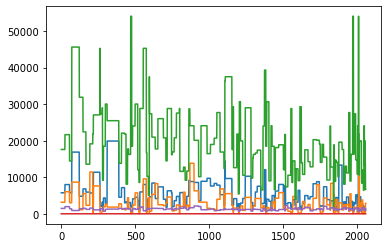

In [813]:
df_transform["number_of_houses"].plot(), df_transform["number_of_units"].plot(), df_transform["population"].plot(), df_transform["aus_born_perc"].plot(), df_transform["median_income"].plot() 

We can see Here how z-score normalization has improved the scaling of all the variable as they are now on the same scale which will make it better for a linear model. It has improved the Comparability and Interpretability of the data. The comparability is improved as standardizing the variables brings them to the same scale, making them directly comparable. When variables have different scales, their magnitudes can affect the coefficients and make it challenging to compare the relative importance of different features. Standardization resolves this issue, allowing for a fairer comparison of the effects of different variables on the target variable. The Interpretability is improved as the  the coefficients in the linear model become more interpretable. A coefficient represents the change in the target variable associated with a one-unit change in the corresponding standardized feature. Since all features now have the same scale, the coefficients become directly comparable and can be interpreted as the impact of a standardized feature on the target variable.

(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

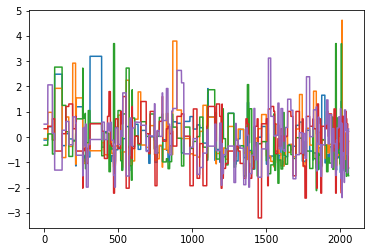

In [814]:
df_transform["number_of_housesscaled"].plot(), df_transform["number_of_unitsscaled"].plot(), df_transform["populationscaled"].plot(), df_transform["aus_born_percscaled"].plot(), df_transform["median_incomescaled"].plot()

Below we have ten plots showing the original values of the variable vs the target variable 'median_house_price', followed by another plot of the standardized values of the variable vs the target variable 'median_house_price' for all the dependent variable. 

(<AxesSubplot:>, <AxesSubplot:>)

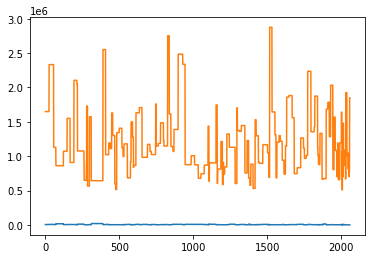

In [815]:
df_transform["number_of_houses"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

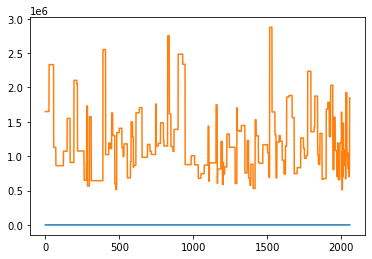

In [816]:
df_transform["number_of_housesscaled"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

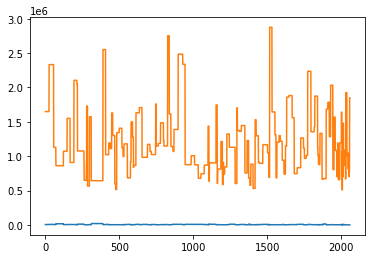

In [817]:
df_transform["number_of_houses"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

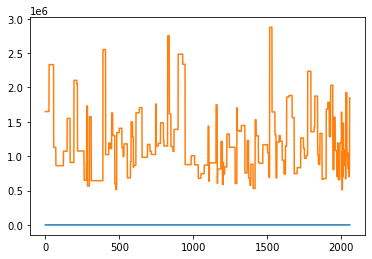

In [818]:
df_transform["number_of_housesscaled"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

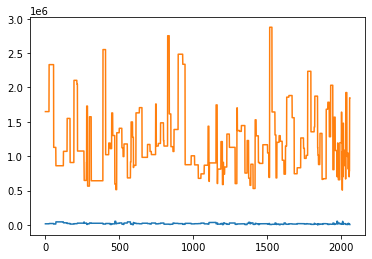

In [819]:
df_transform["population"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

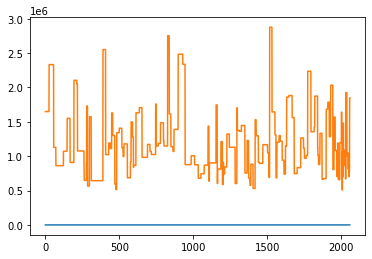

In [820]:
df_transform["populationscaled"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

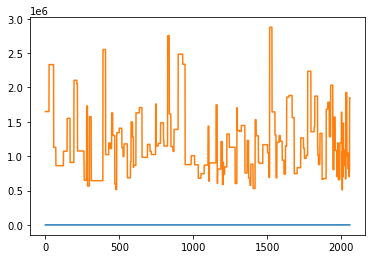

In [821]:
df_transform["aus_born_perc"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

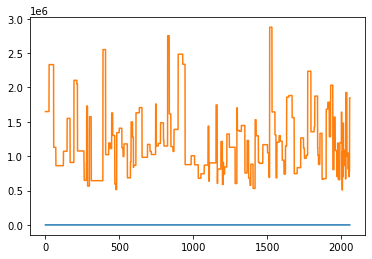

In [822]:
df_transform["aus_born_percscaled"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

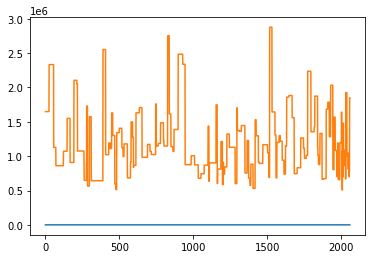

In [823]:
df_transform["median_income"].plot(), df_transform["median_house_price"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

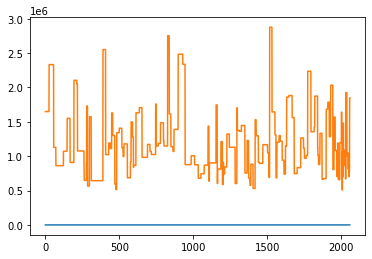

In [824]:
df_transform["median_incomescaled"].plot(), df_transform["median_house_price"].plot()

With the plots shown above we can see that standardization of the dependent variables doesn't have much of an impact with respect to the target variable as the values standardized values are still very small compared to the orginal values, so it can be said that standardization is not very useful here. 
Now to check the impact of standardization with respect to the dependent variables we use the steps below:

In [829]:
x = ['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income']
# making lists with the variable names to make it easier to plot the different variable before and after standardization
x1 = ['number_of_housesscaled', 'number_of_unitsscaled', 'populationscaled', 'aus_born_percscaled','median_incomescaled']

Below is a plot of all the dependent variables against each other before standisation.

<ipython-input-835-5f2fc951f476>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


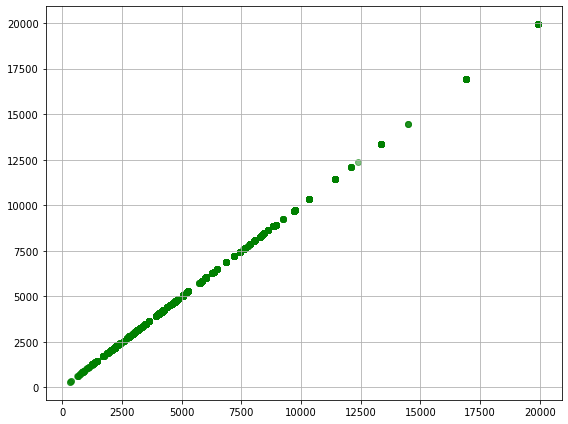

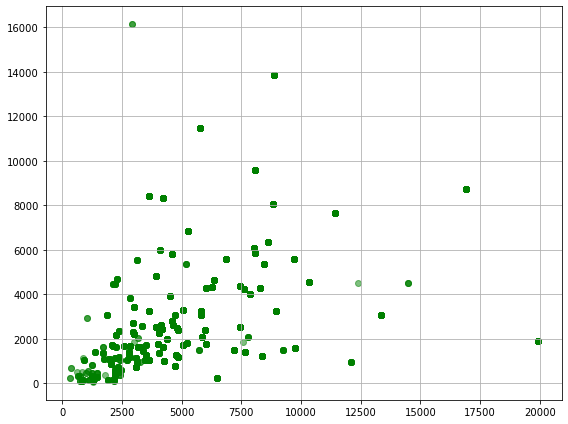

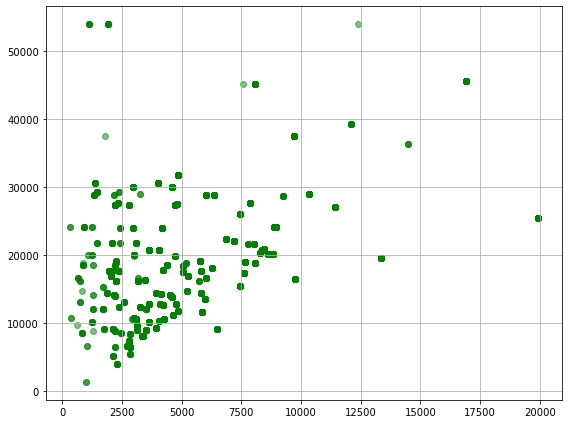

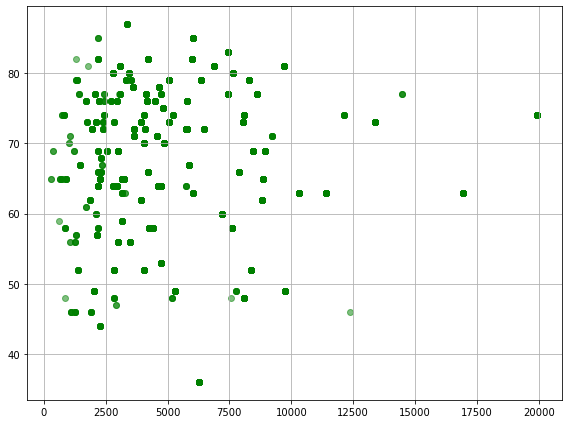

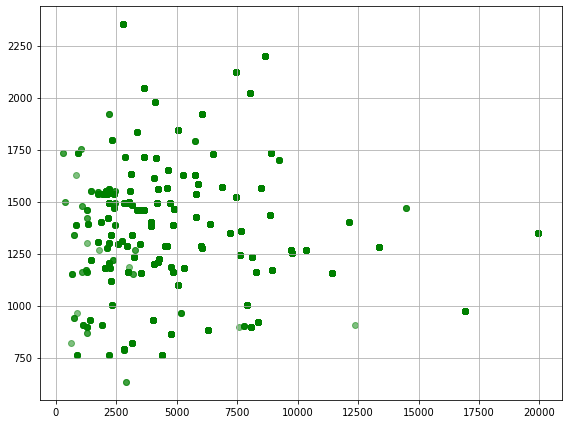

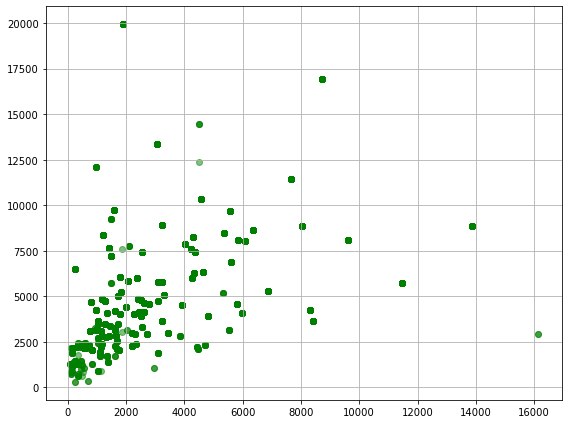

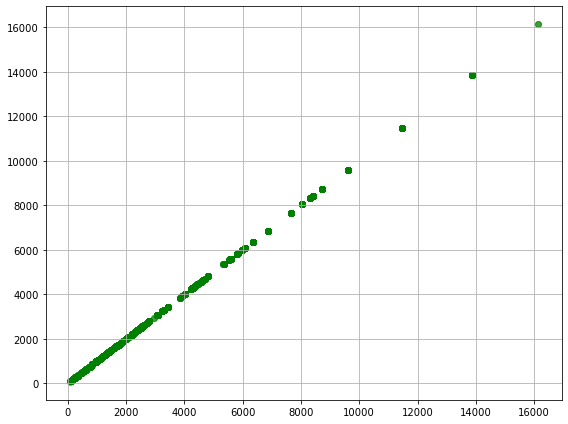

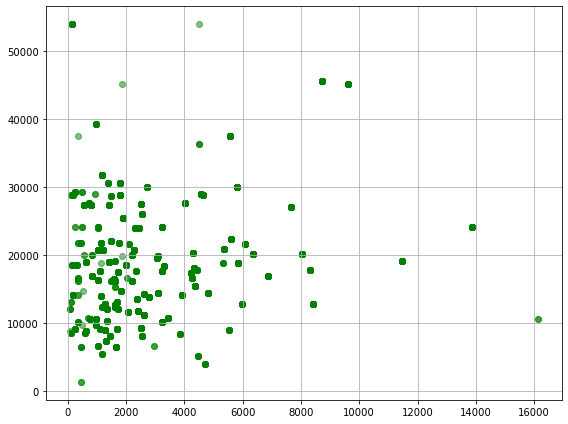

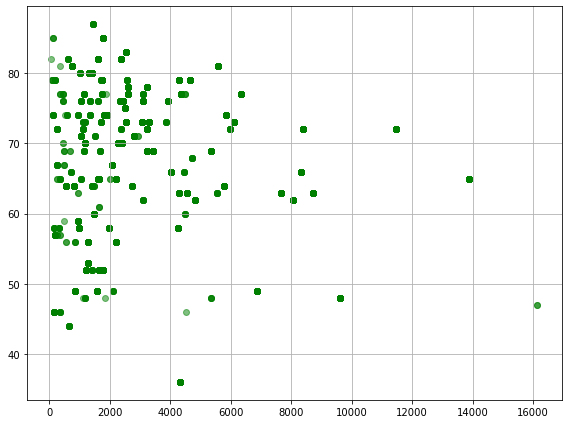

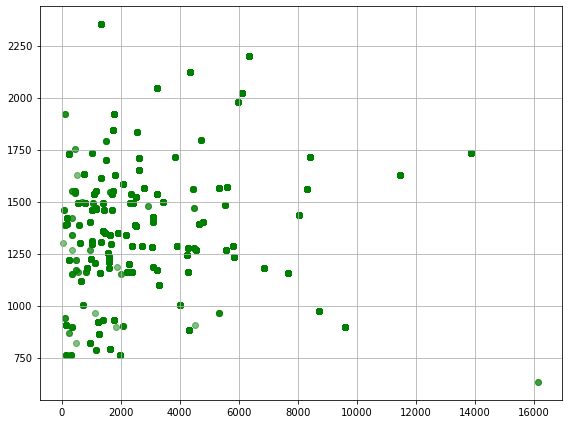

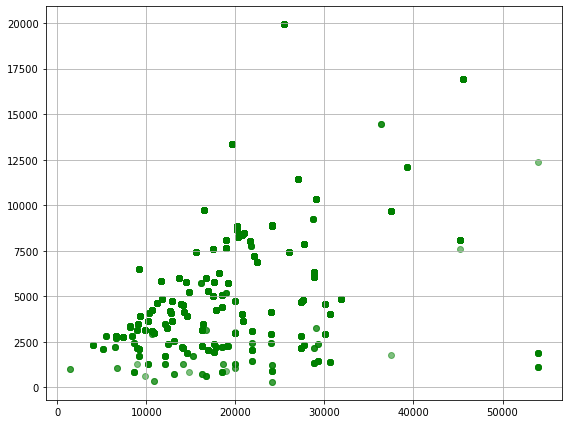

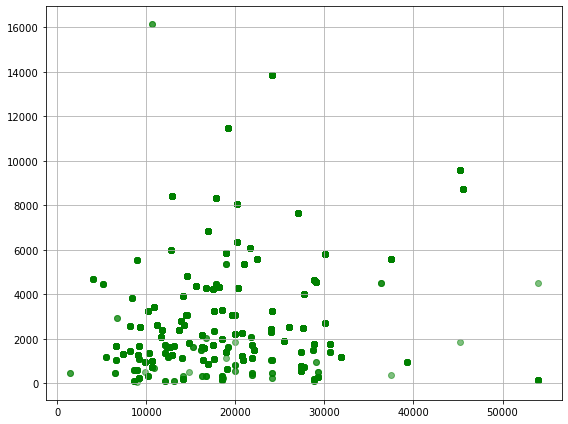

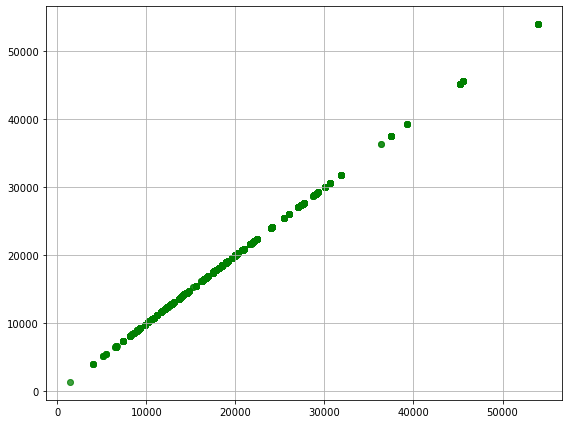

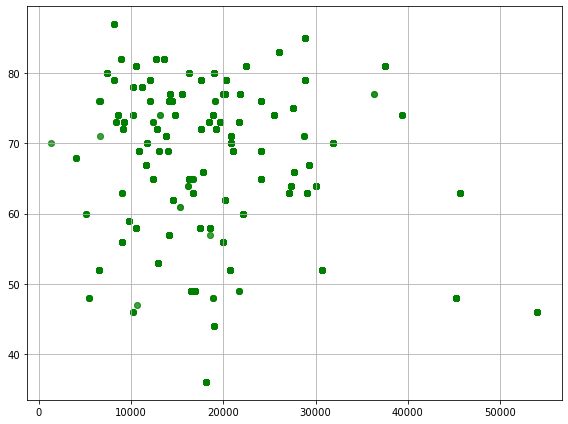

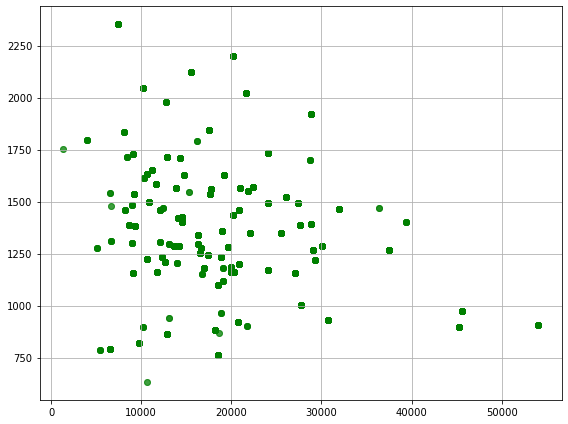

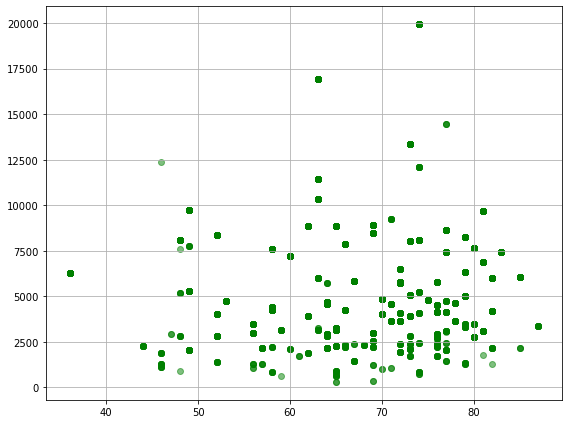

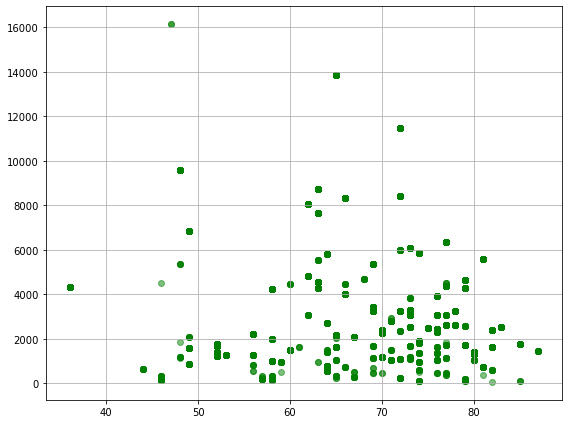

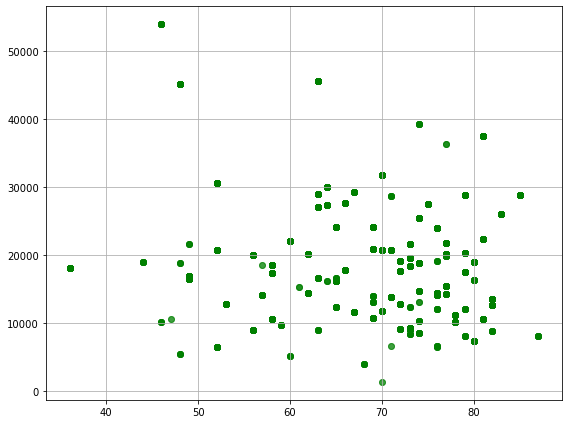

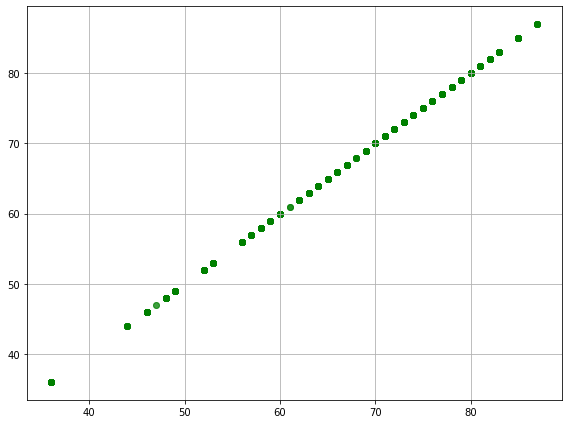

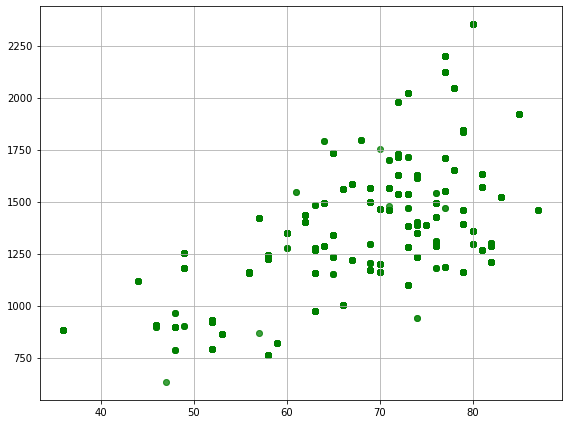

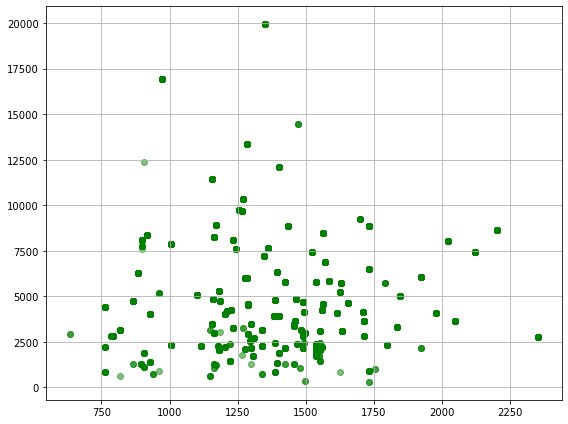

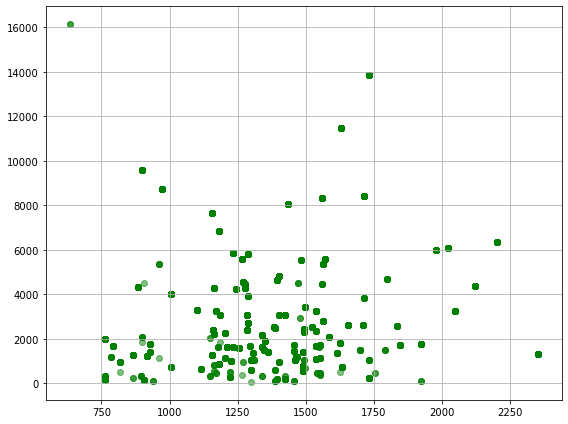

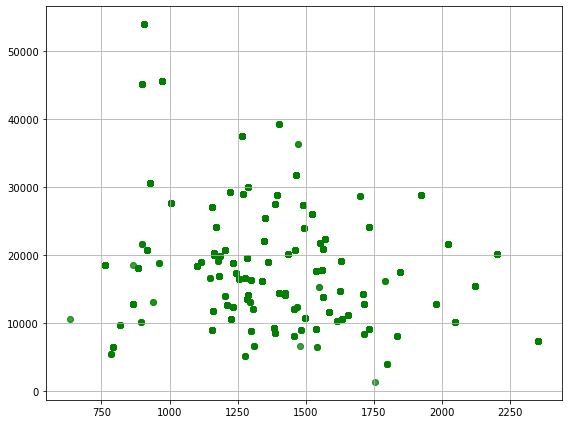

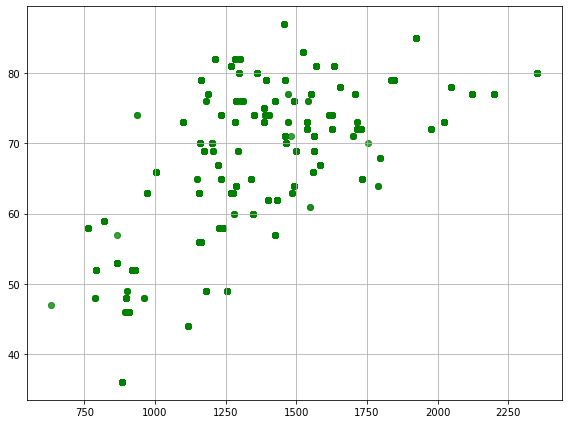

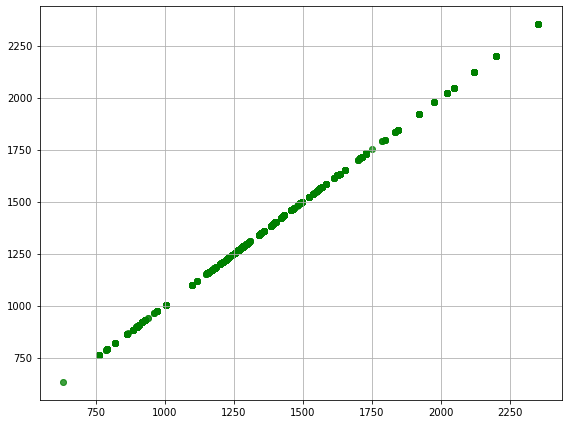

In [835]:
for x2 in x:
    for x5 in x:
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x2], df_transform[x5],
            color='green', label='input scale', alpha=0.5)

        plt.xlabel(x2)
        plt.ylabel(x5)
        plt.grid()
        plt.tight_layout()

plt.show()

Below we plot all the dependent variables standardized against all the dependent variables non standardized

<ipython-input-1093-fa903fef2fa4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


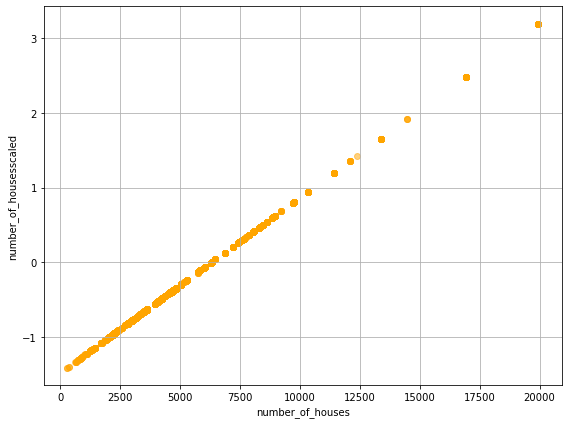

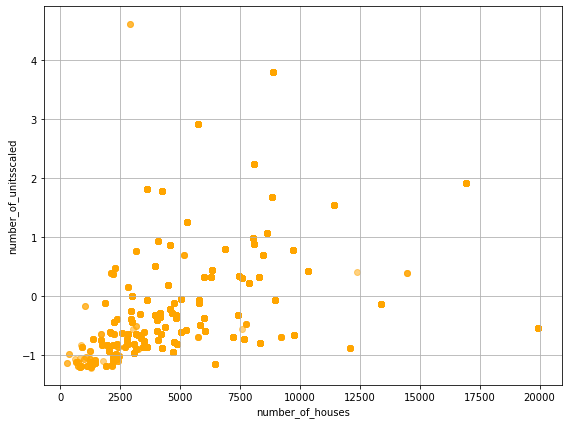

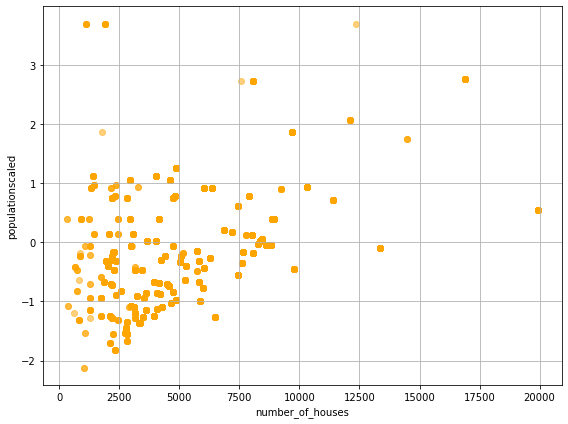

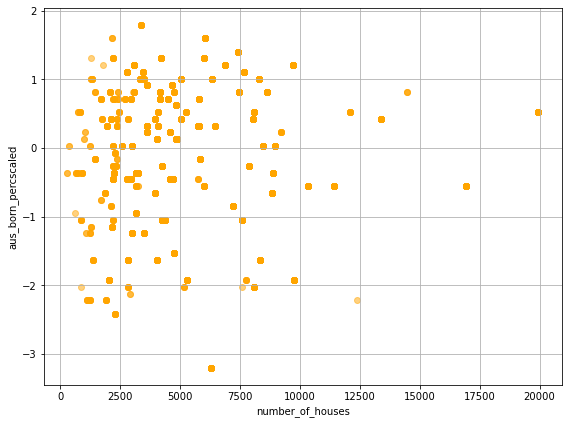

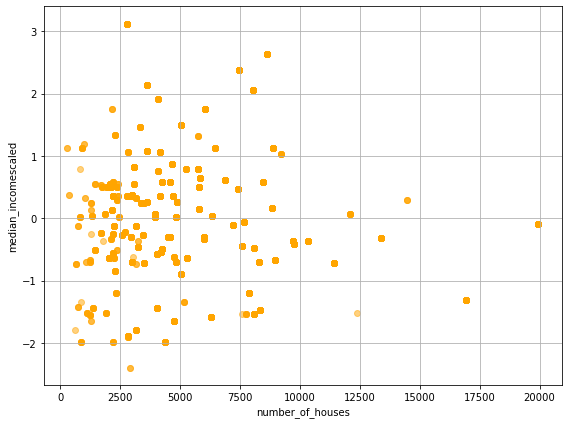

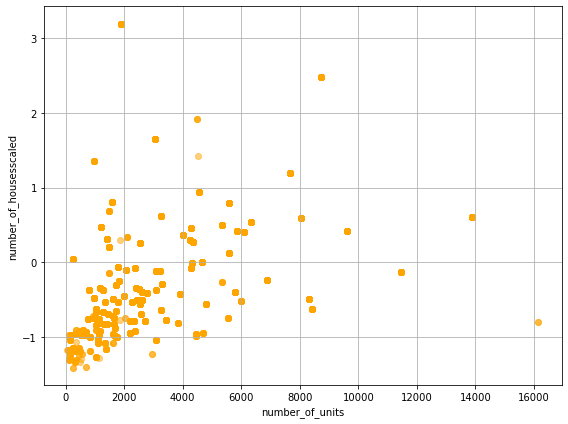

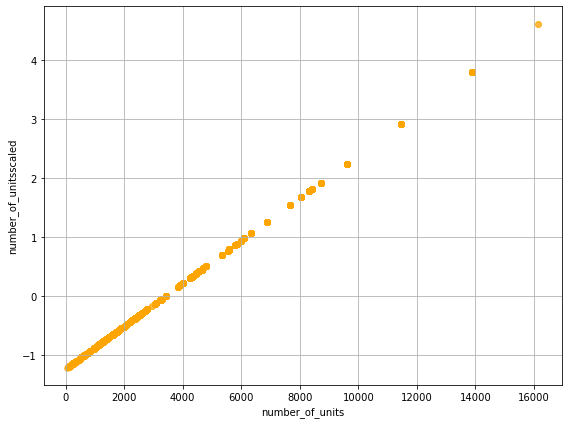

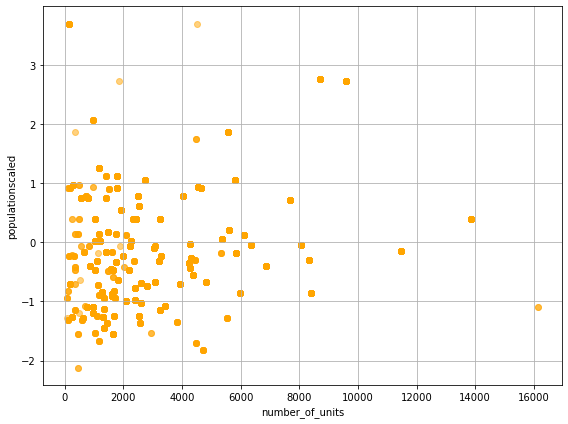

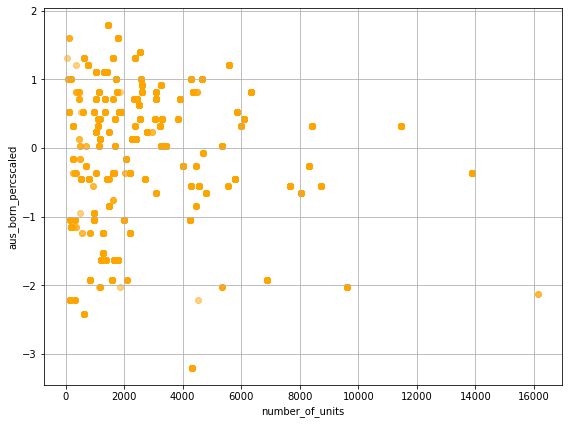

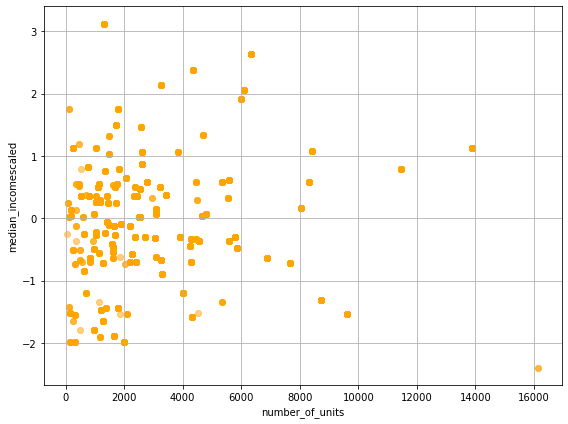

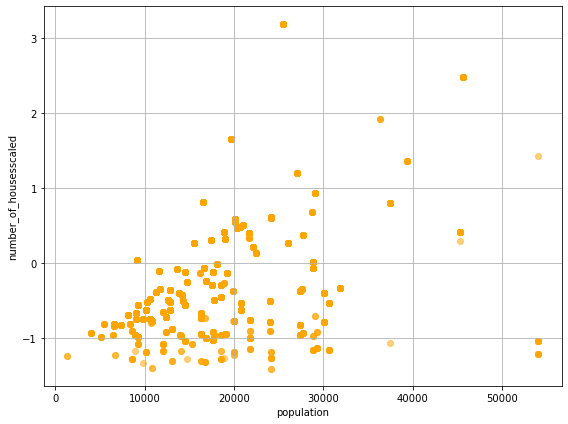

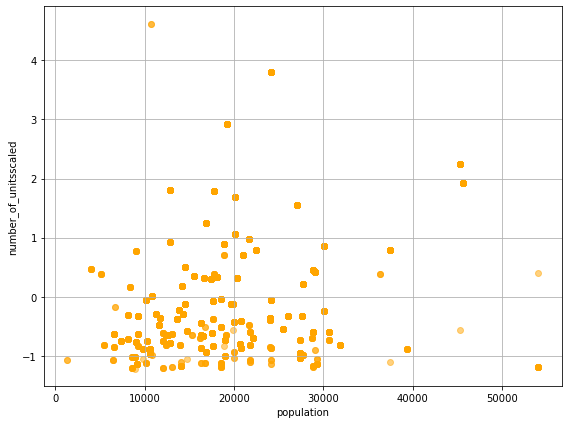

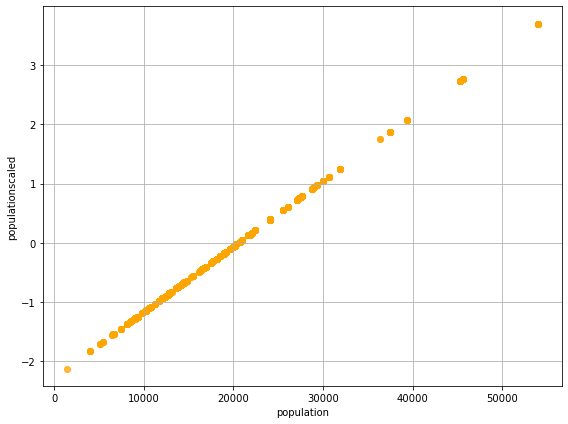

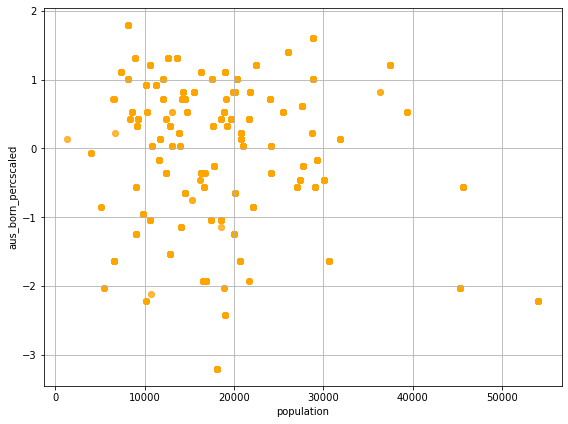

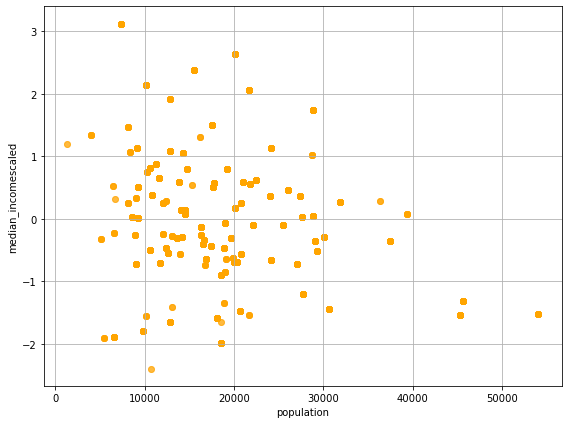

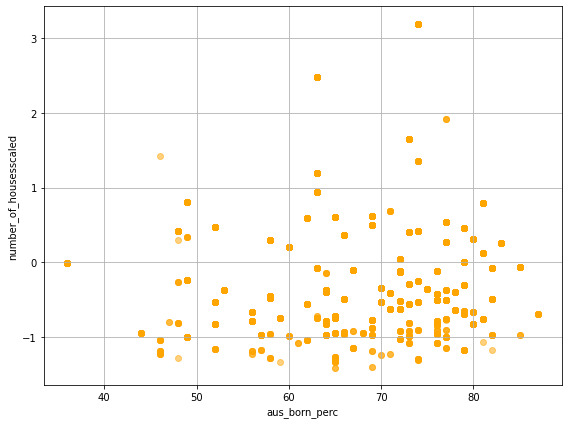

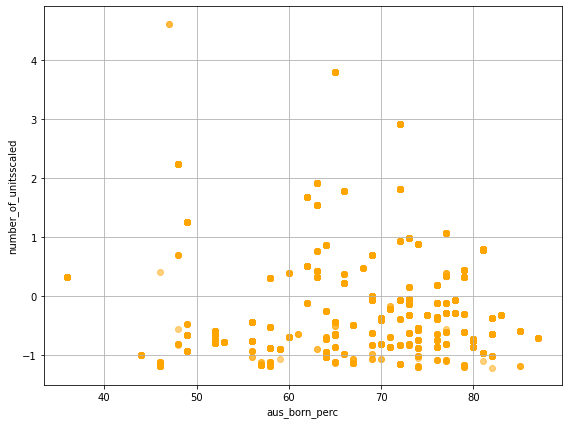

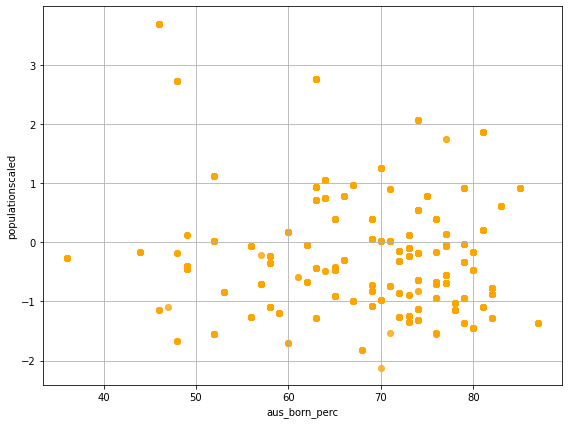

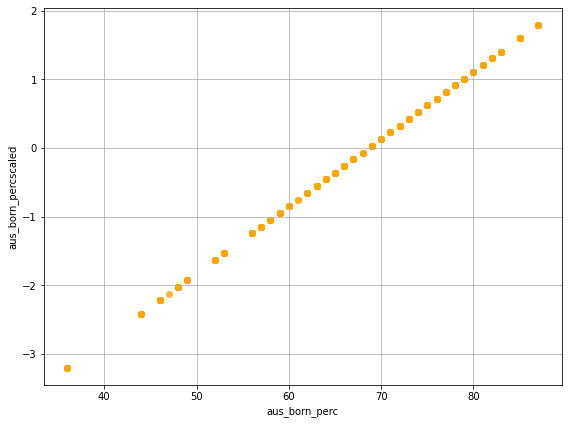

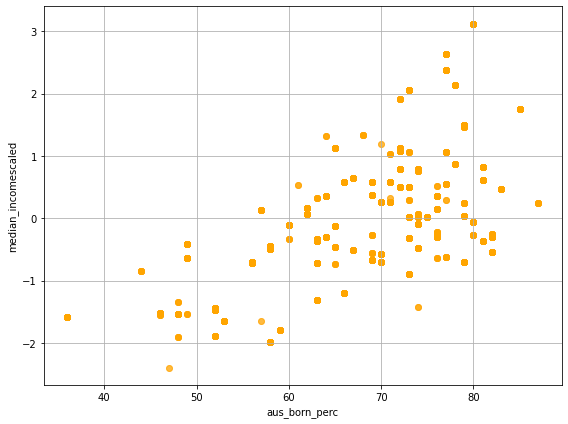

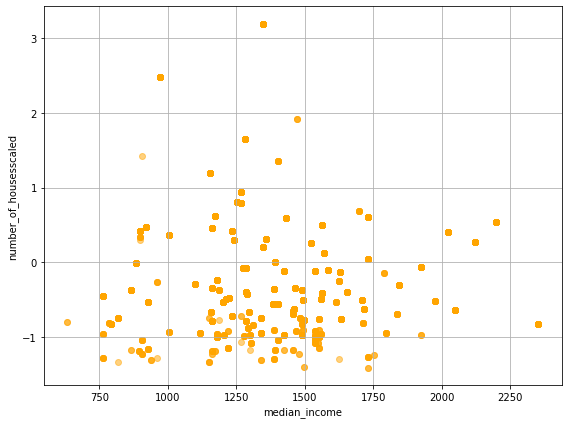

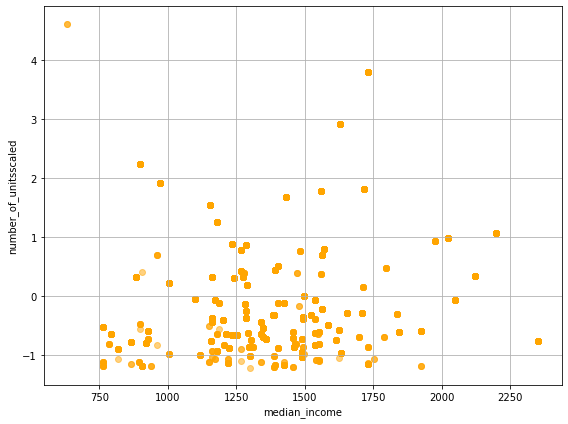

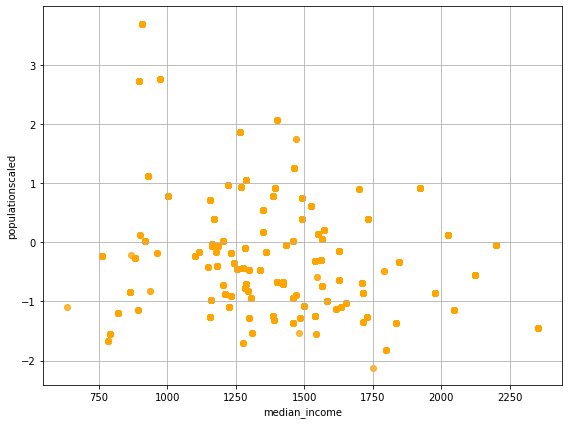

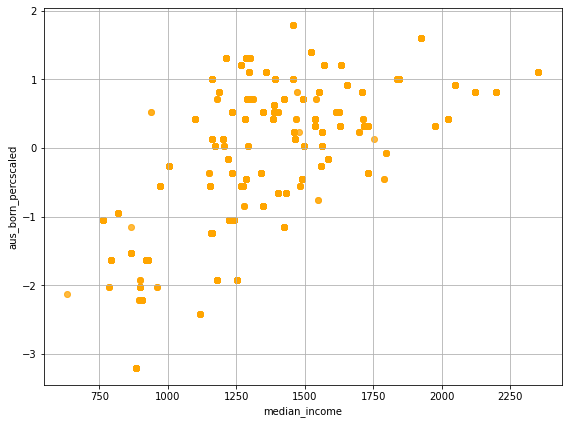

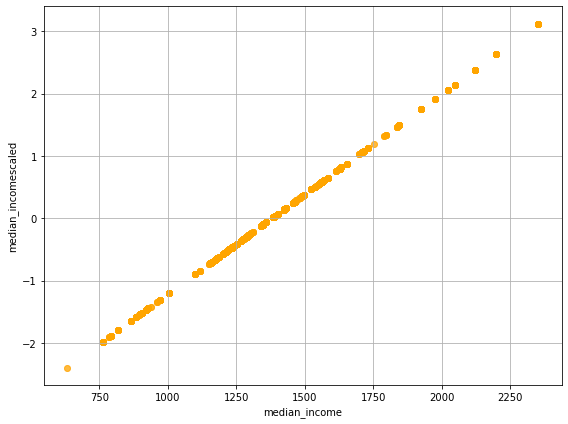

In [1093]:
for x2 in x:
    for x3 in x1:
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x2], df_transform[x3],
            color='orange', label='input scale', alpha=0.5)


        plt.xlabel(x2)
        plt.ylabel(x3)
        plt.grid()
        plt.tight_layout()



plt.show()

Below we plot all the dependent variables standardized against all the dependent variables standardized. 
We can identify from these plots that standardisation doesn't have much of an impact on the values and so is not very useful and should not be used. 

<ipython-input-1094-af564335e7f1>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


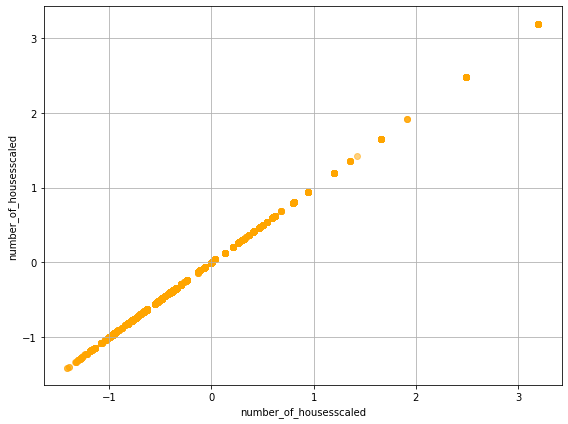

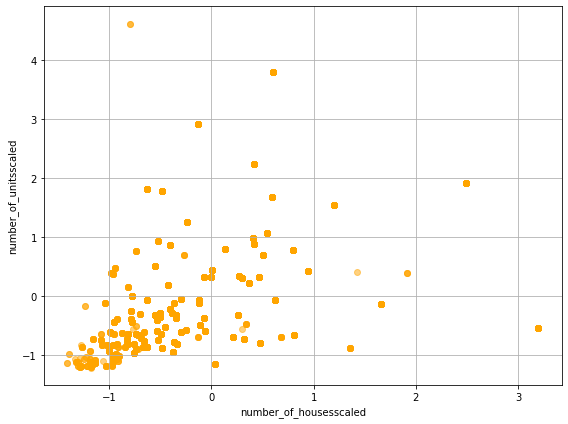

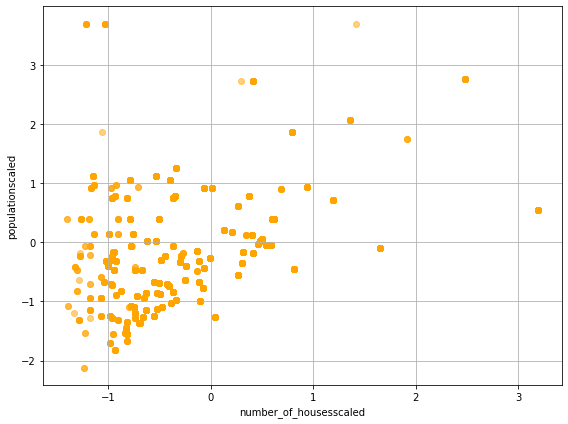

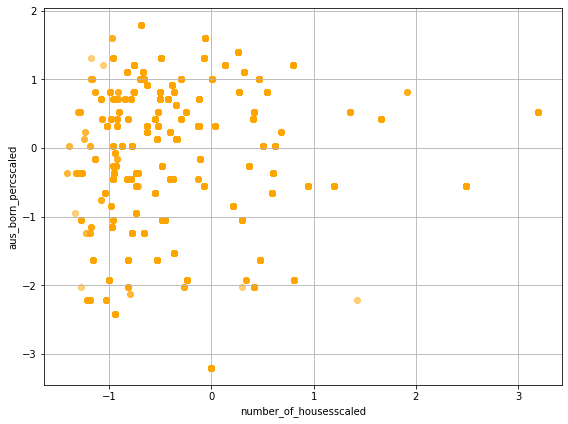

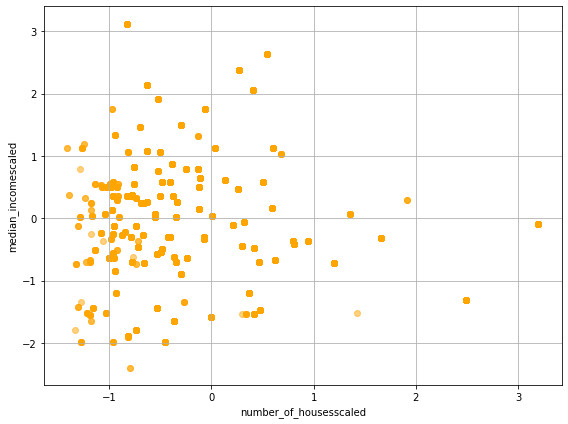

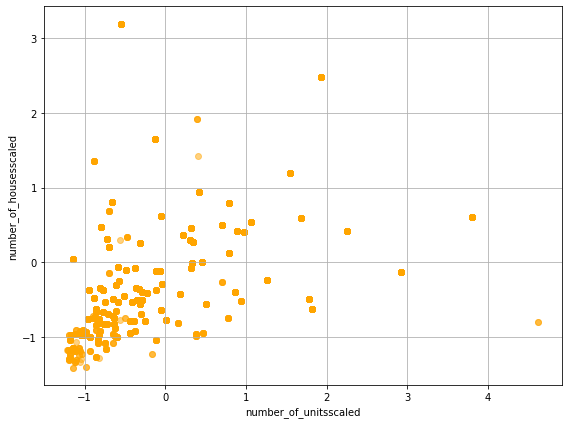

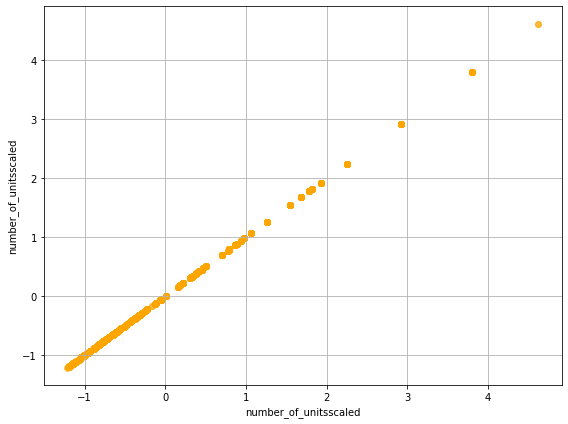

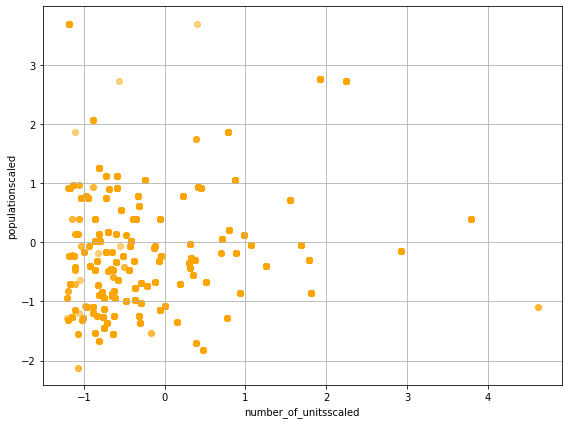

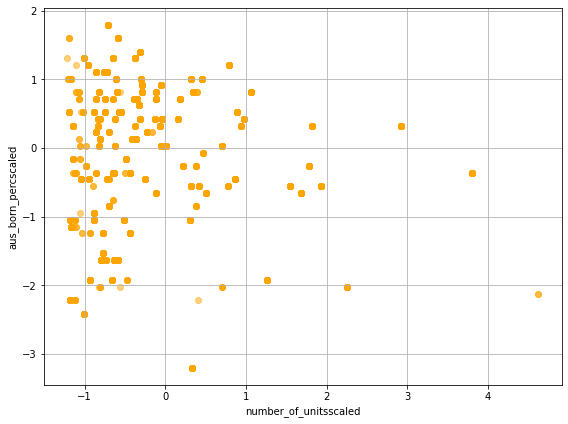

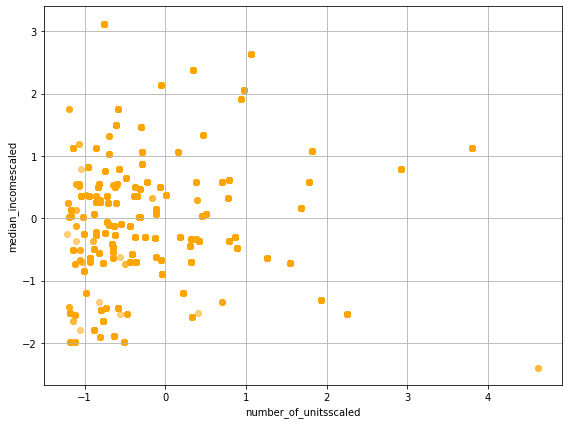

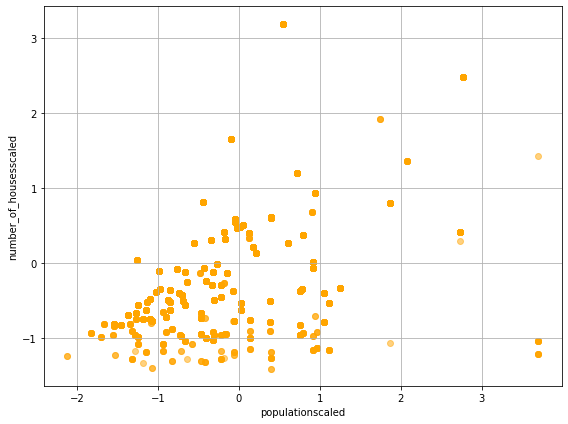

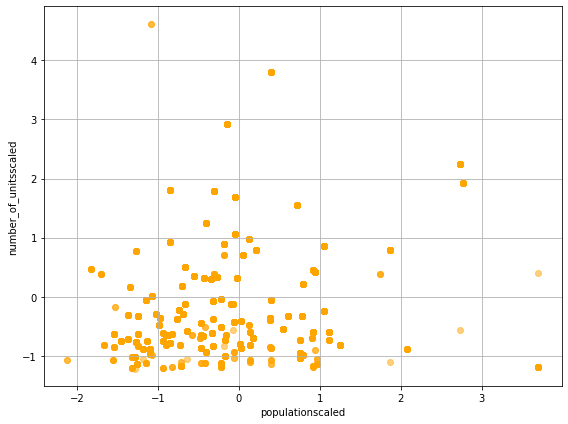

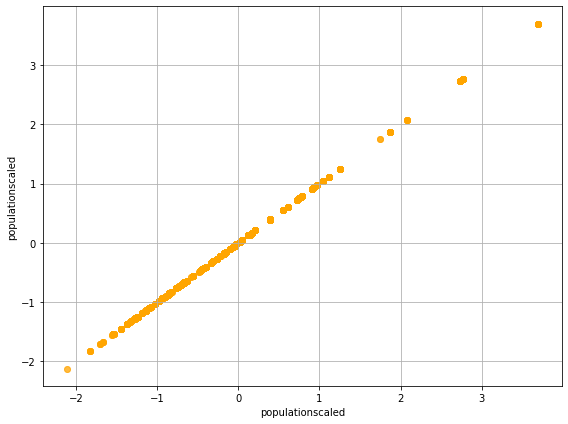

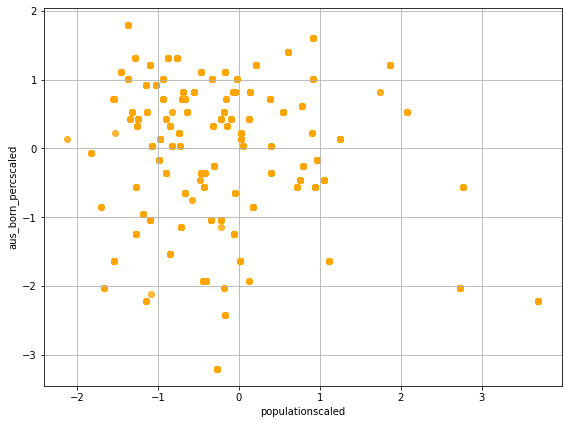

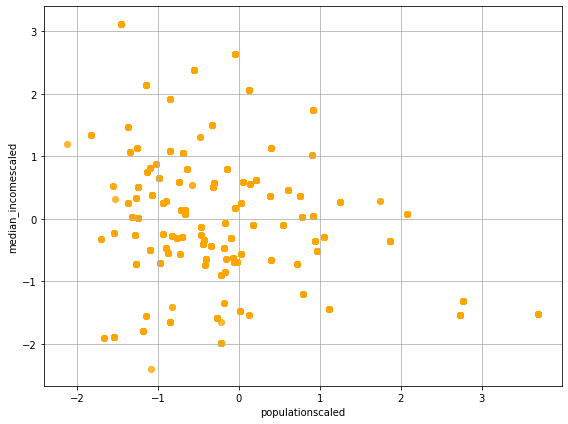

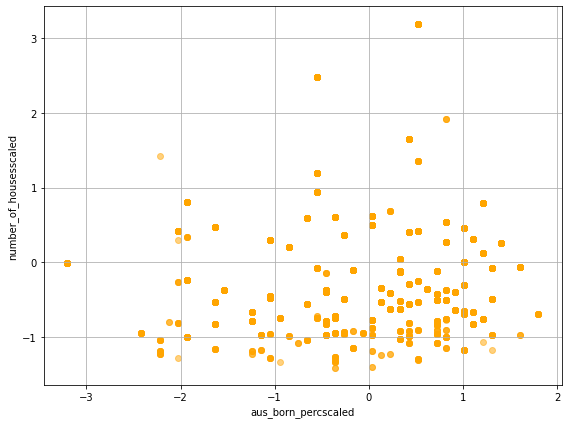

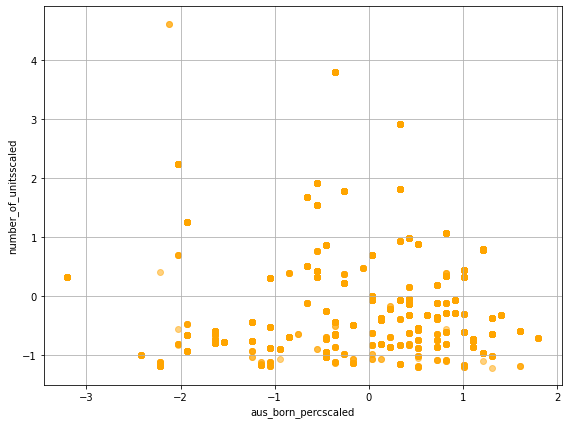

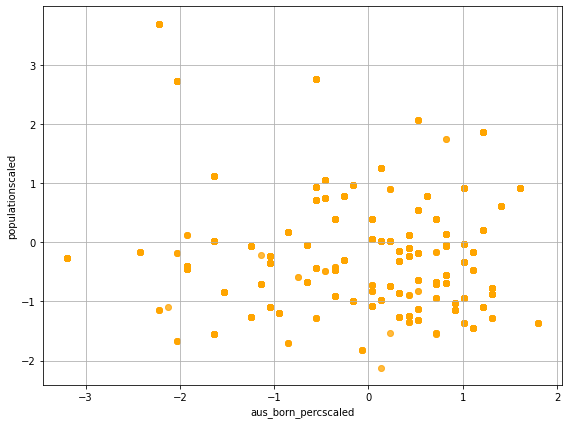

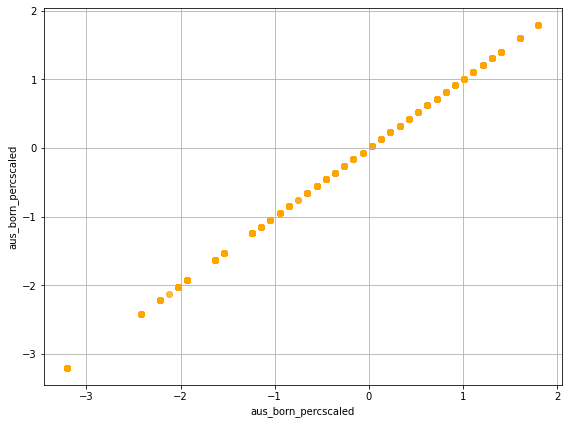

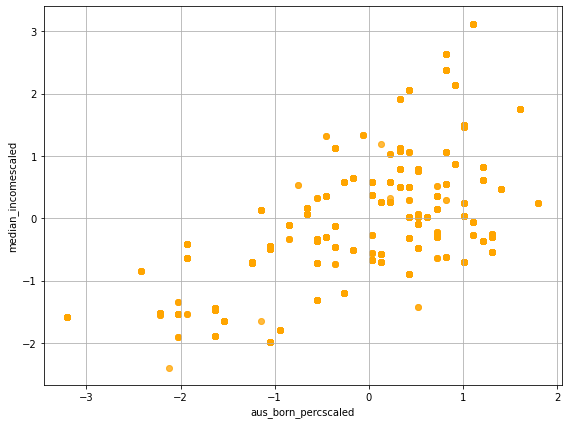

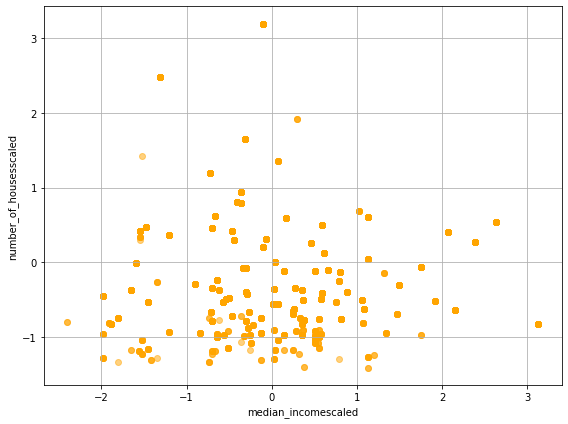

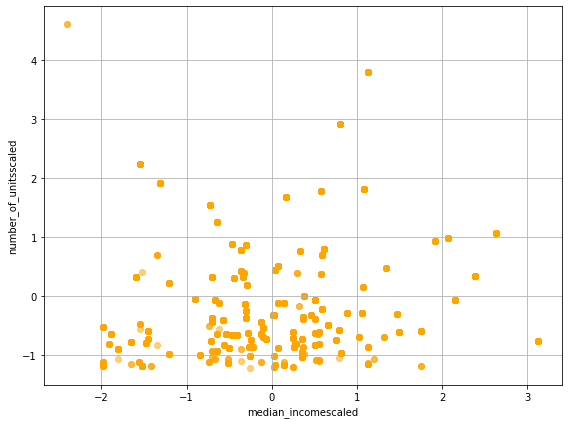

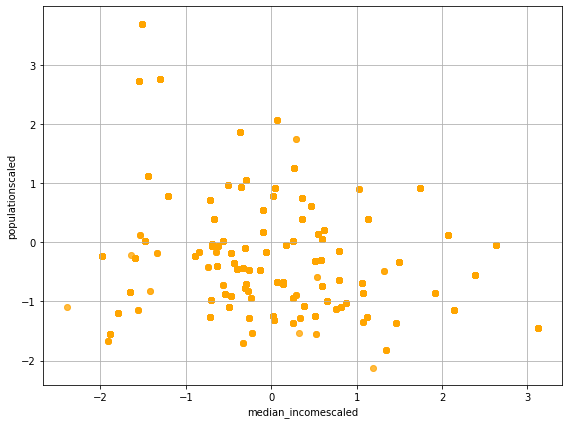

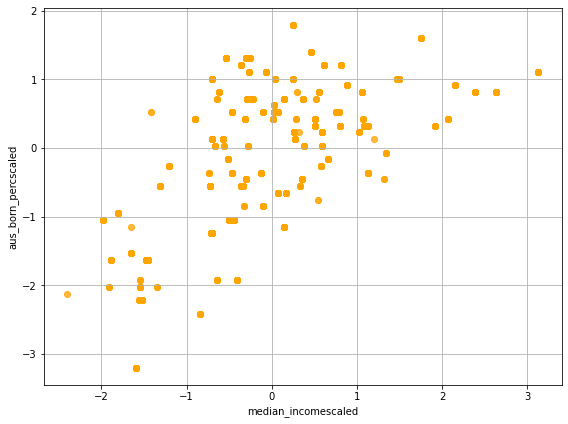

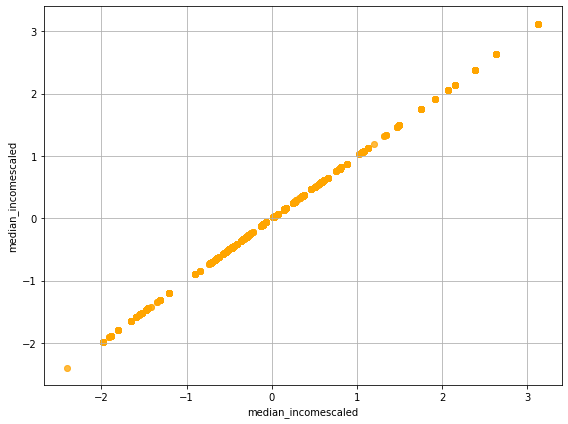

In [1094]:
for x2 in x1:
    for x3 in x1:
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x2], df_transform[x3],
            color='orange', label='input scale', alpha=0.5)


        plt.xlabel(x2)
        plt.ylabel(x3)
        plt.grid()
        plt.tight_layout()



plt.show()

MinMax

MinMax standardization is another type of data scaling technique commonly used for linear models. Unlike z-score normalization, which transforms data to have zero mean and unit variance, min-max standardization scales the data to a specific range, typically between 0 and 1. The uses of min max are as follows:
1. Scaling to a bounded range: Min-max standardization scales the data to a fixed range, often between 0 and 1. This can be particularly useful when the features have specific bounds or constraints, and you want to maintain the original data range within those bounds. By preserving the original data range, you retain the relative differences between data points.

2. Interpretability: Min-max standardization preserves the relative ordering of values, making it easier to interpret the coefficients in a linear model. The coefficients can be directly interpreted as the change in the dependent variable associated with a unit change in the corresponding independent variable.

3. Preserving skewness and outliers: Min-max standardization maintains the shape of the original data distribution, including any skewness or outliers. It simply linearly scales the values to fit within the desired range. This can be advantageous when the data distribution carries meaningful information, and you want to preserve those characteristics.

4. Robustness to outliers: Min-max standardization is relatively robust to outliers. Although outliers can affect the scaling of the data within the specific range, they do not have a significant impact on the scaling of the remaining data. This can help reduce the influence of outliers on the linear model's coefficients.

5. Maintaining sparsity: If your dataset contains sparse features (features with many zero values), min-max standardization can preserve the sparsity structure. It does not alter the zero values, as the scaling is performed based on the non-zero values only.
The issue with min-max standardization is that it is sensitive to the range of the data. Outliers or extreme values outside the desired range can lead to loss of information or compression of data within a narrow range. In such cases, alternative scaling techniques, such as robust scaling methods, may be more appropriate.
Below we perfrom the steps required for performing the min max standardization:
preprocessing.MinMaxScaler(): This creates an instance of the MinMaxScaler class from the scikit-learn preprocessing module. The MinMaxScaler is used to perform min-max standardization on the data.

.fit(): This fits the MinMaxScaler to the specified subset of columns in the DataFrame df_transform. The scaler calculates the minimum and maximum values of each column, which will be used to perform the scaling.

minmax_scale.transform(): This applies the min-max standardization transformation to the specified columns using the previously fitted scaler. It scales the values in each column to a range between 0 and 1, based on the minimum and maximum values calculated during the fitting step.


In [838]:
minmax_scale = preprocessing.MinMaxScaler().fit(df_transform[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income']])
df_minmax = minmax_scale.transform(df_transform[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc','median_income']])

array([[0.27990626, 0.19702718, 0.30890679, 0.70588235, 0.52646888],
       [0.27990626, 0.19702718, 0.30890679, 0.70588235, 0.52646888],
       [0.27990626, 0.19702718, 0.30890679, 0.70588235, 0.52646888],
       [0.27990626, 0.19702718, 0.30890679, 0.70588235, 0.52646888],
       [0.27990626, 0.19702718, 0.30890679, 0.70588235, 0.52646888]])

Below all the variable against each other before min max and before Standardization  , after  Standardization and after min max

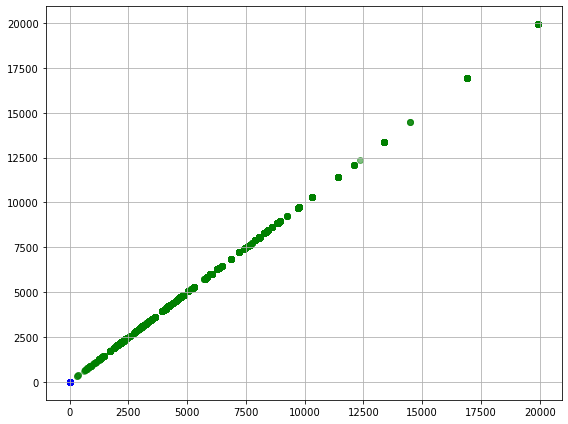

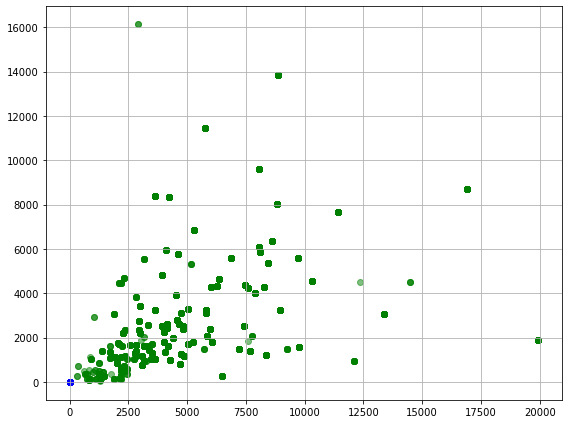

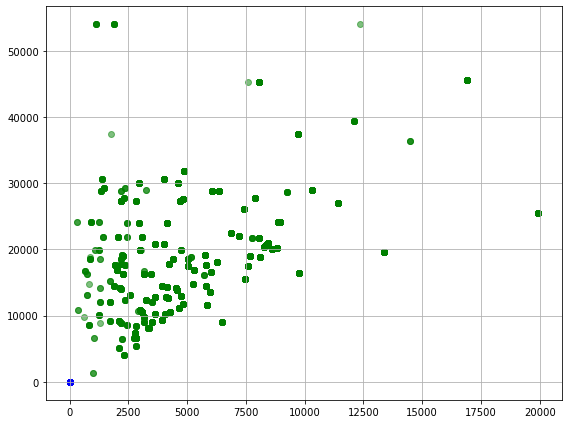

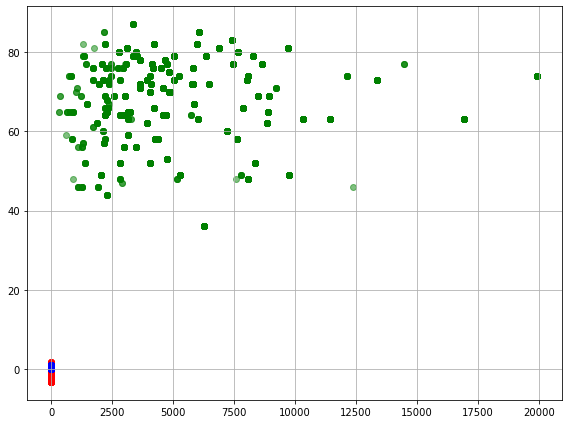

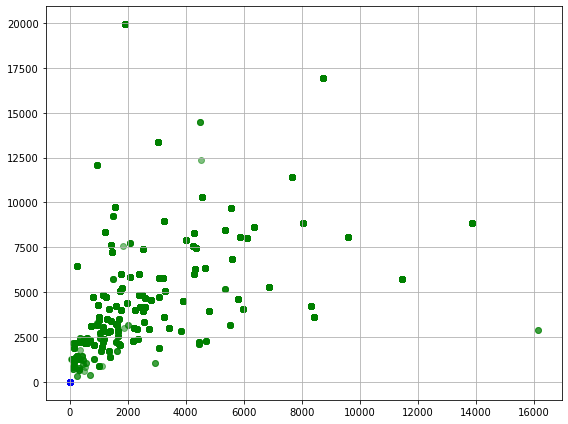

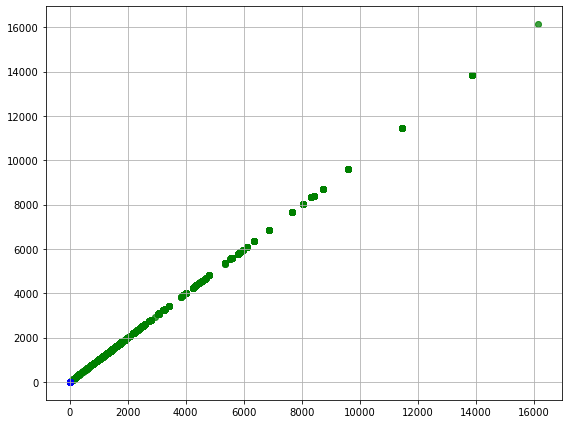

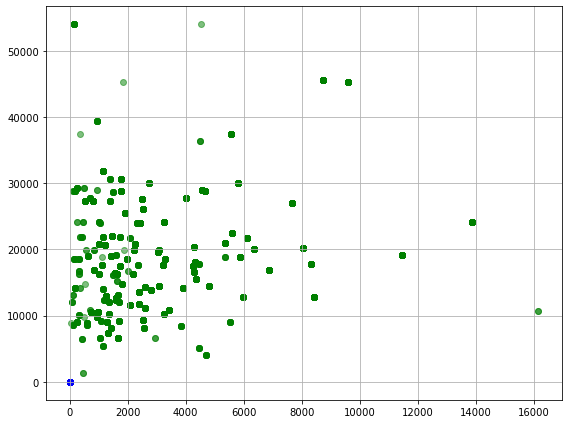

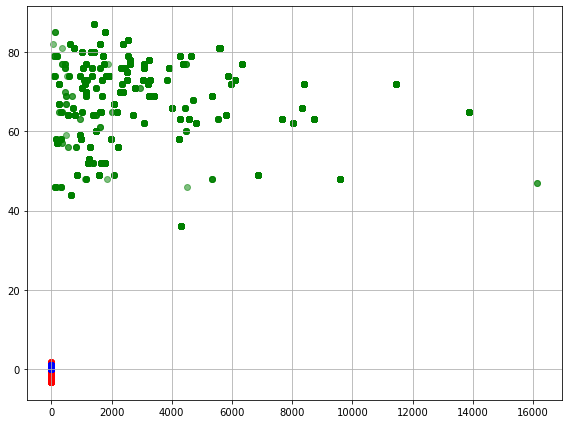

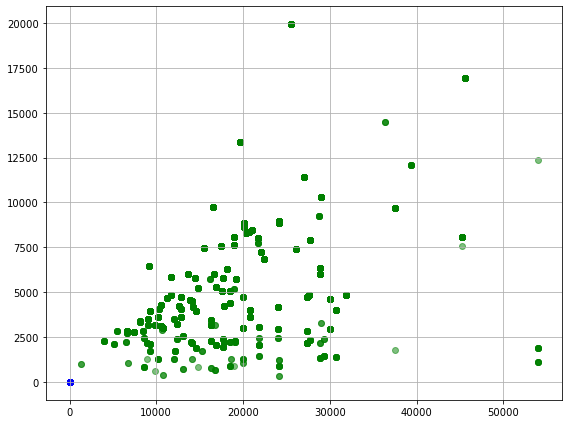

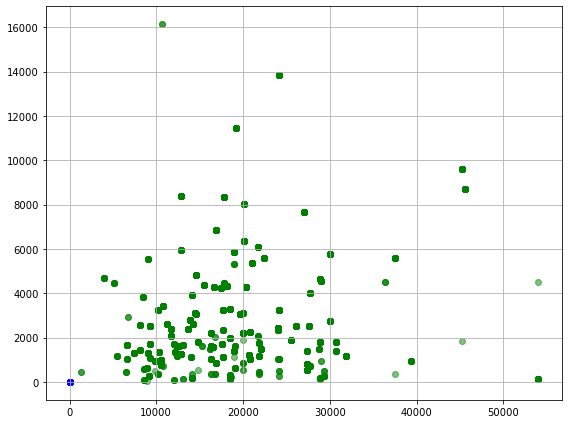

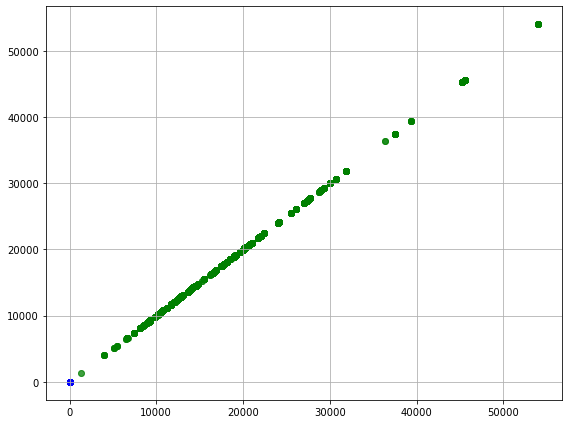

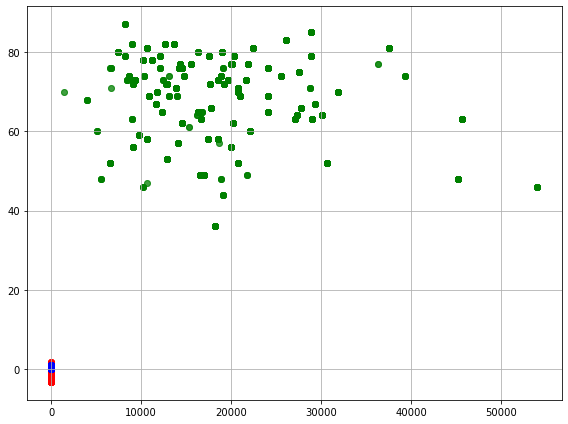

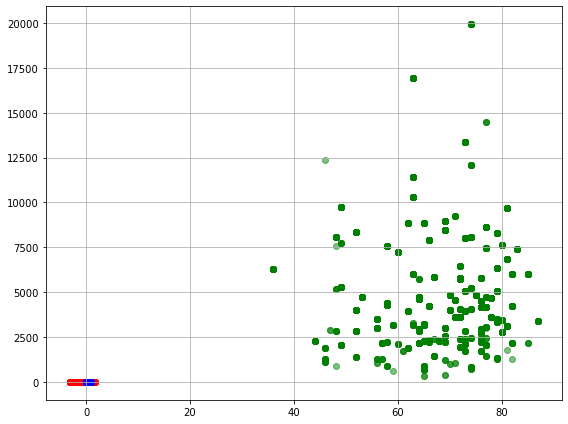

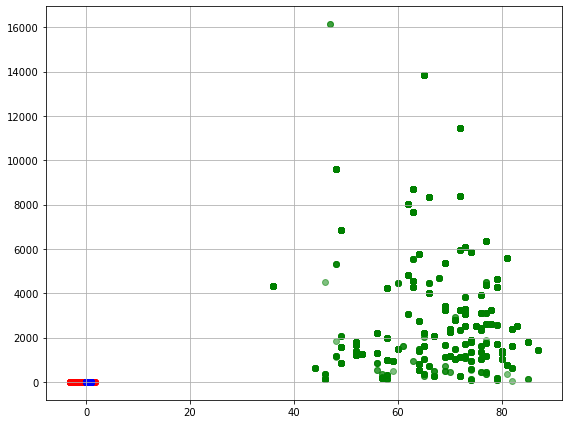

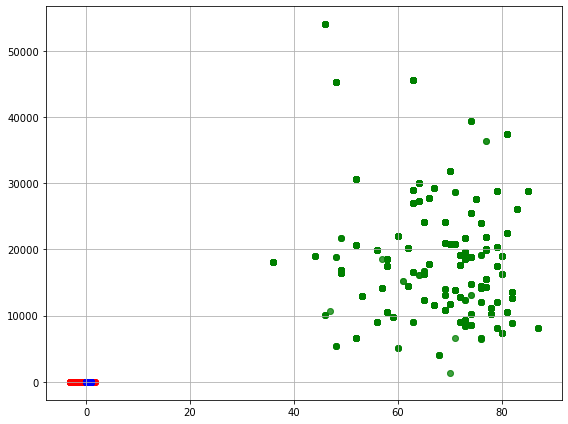

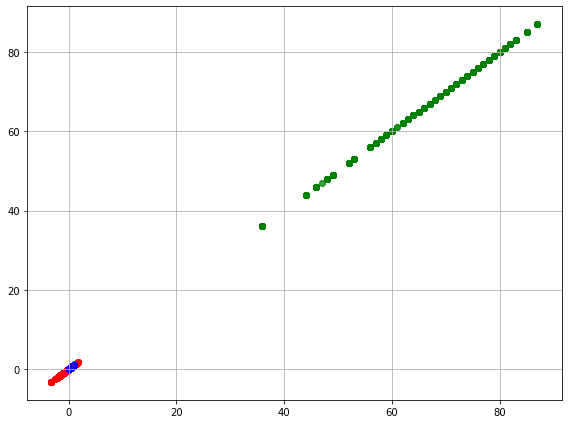

In [1095]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,4):
    for x34 in  range(0,4):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform[x[x34]],
            color='green', label='input scale', alpha=0.5)


        plt.scatter(df_std[:,x33], df_std[:,x34], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
        plt.scatter(df_minmax[:,x33], df_minmax[:,x34],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)


        plt.grid()
        plt.tight_layout()


plt.show()

BELOW IS PLOT OF SHOWING THE COMPARISON BETWEEN THE STANDANDIZIED AND MIN MAX METHODS
Here we can see that the min max method is better than z score as values are more closer to each other and clustered so are better with reduced outliers

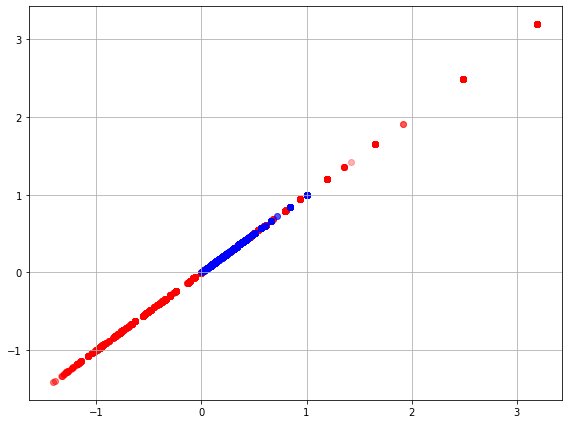

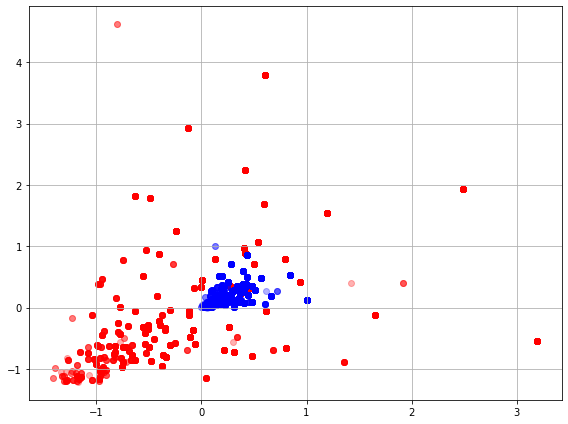

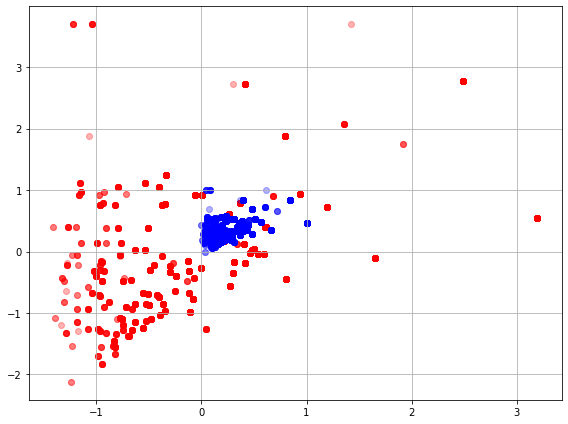

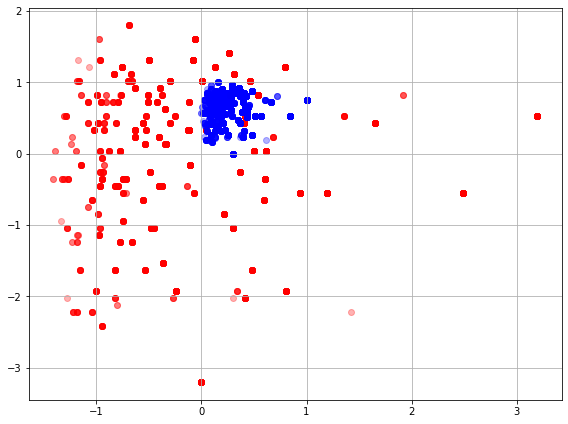

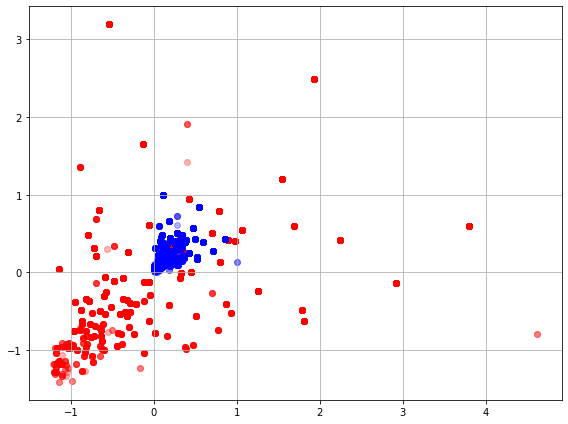

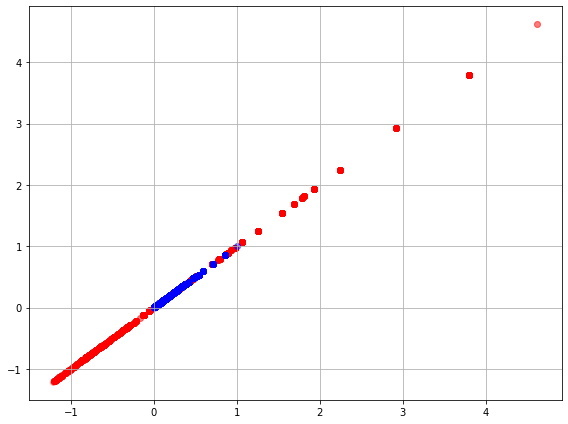

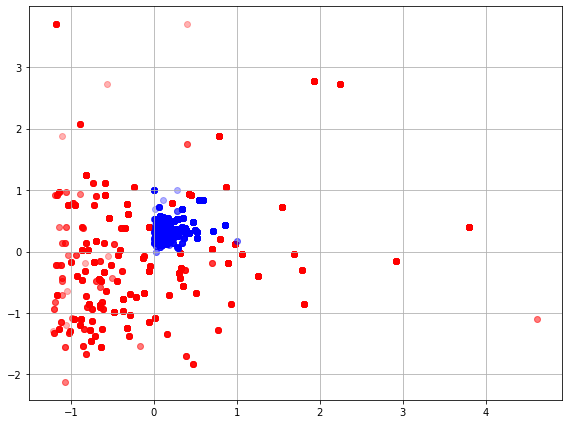

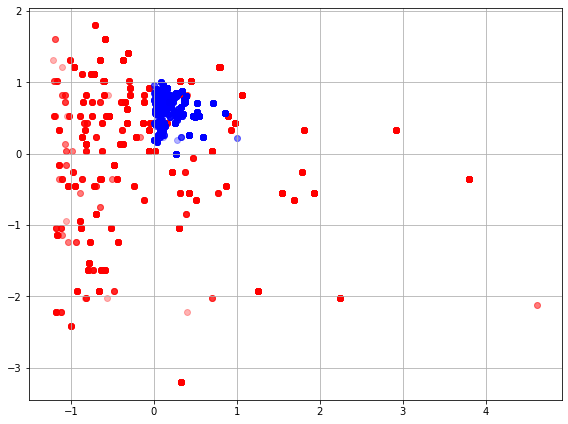

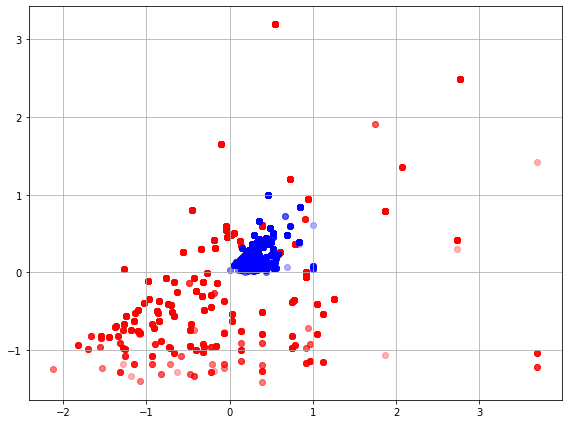

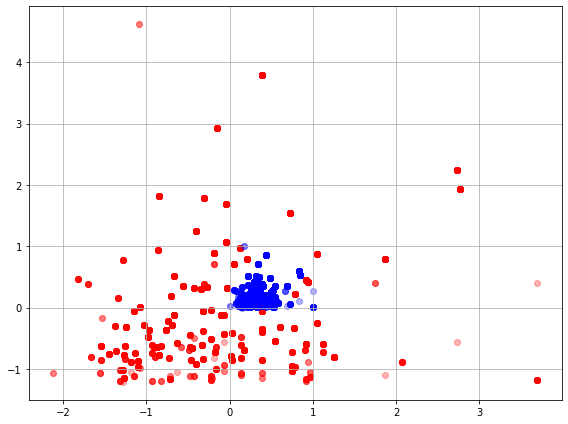

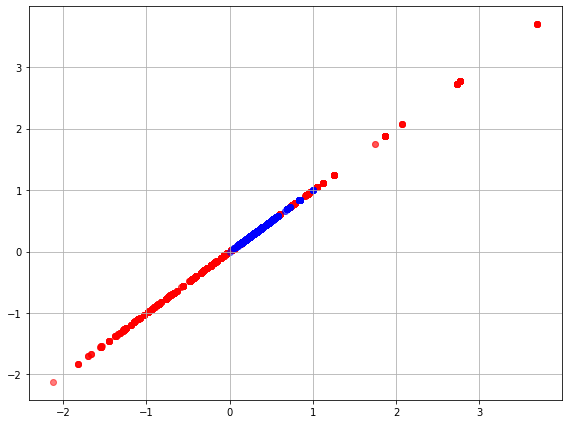

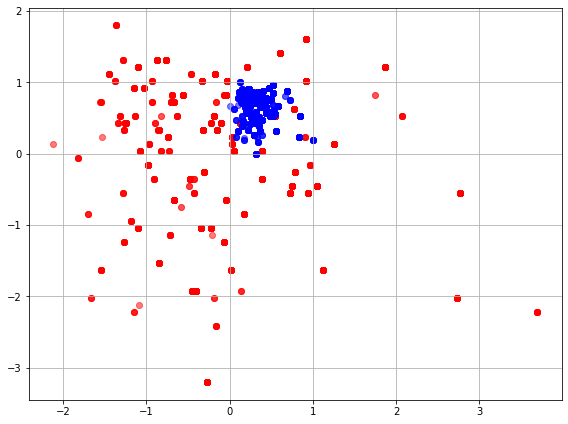

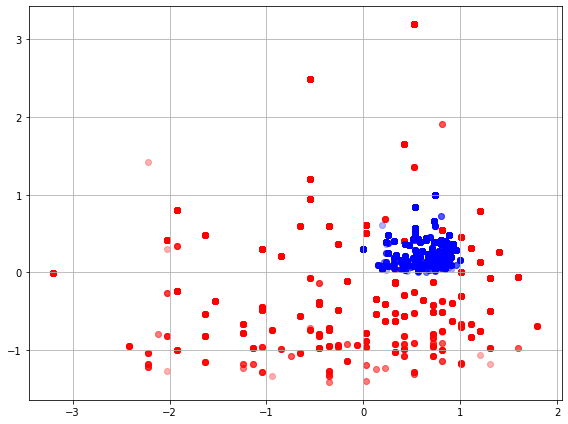

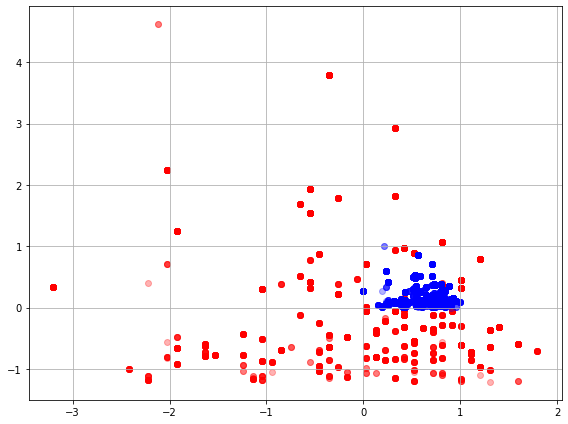

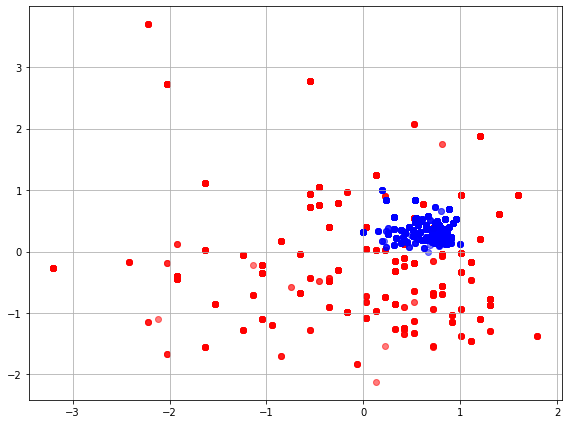

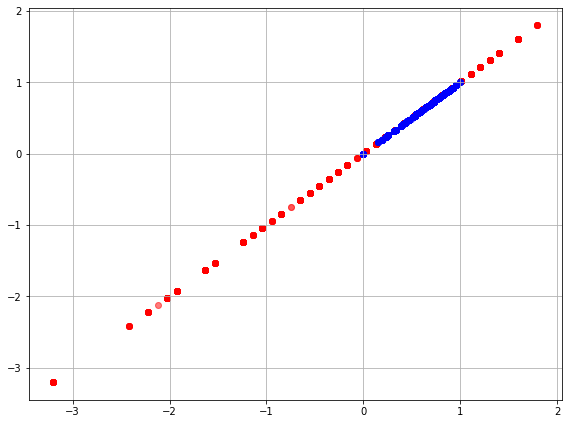

In [849]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,4):
    for x34 in  range(0,4):
        f = plt.figure(figsize=(8,6))
        plt.scatter(df_std[:,x33], df_std[:,x34], color='red',
             label='Standardized u=0, s=1', alpha=0.3)
    
        plt.scatter(df_minmax[:,x33], df_minmax[:,x34],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)


        plt.grid()
        plt.tight_layout()

plt.show()

Scatter plot to see the difference of standardisation on median house price

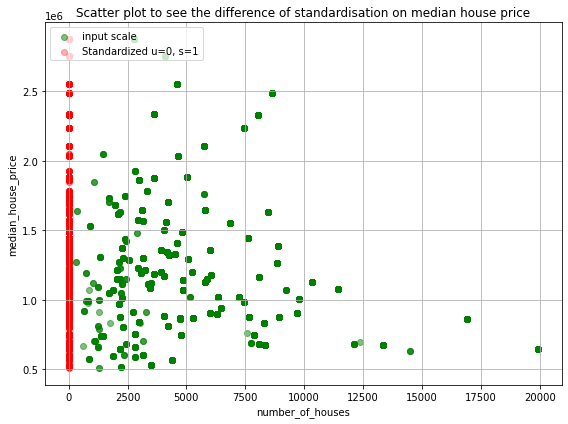

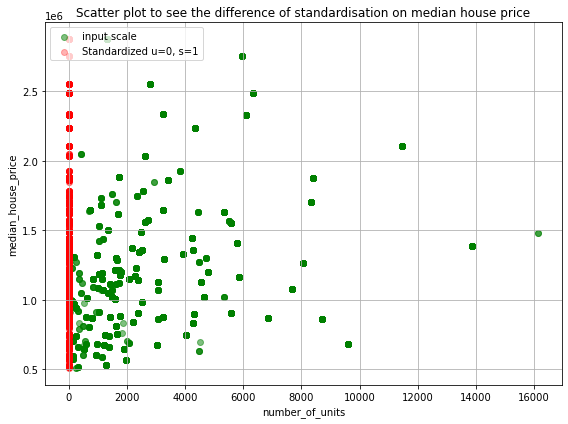

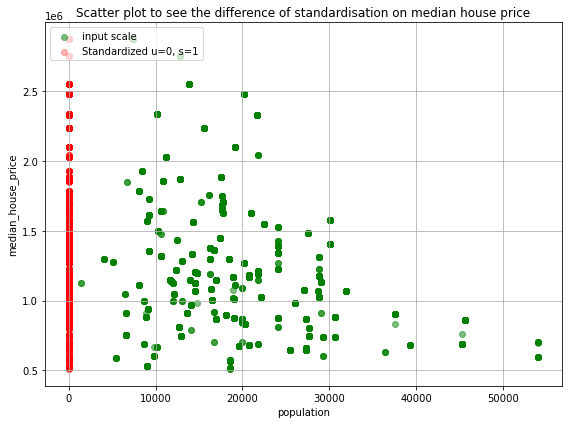

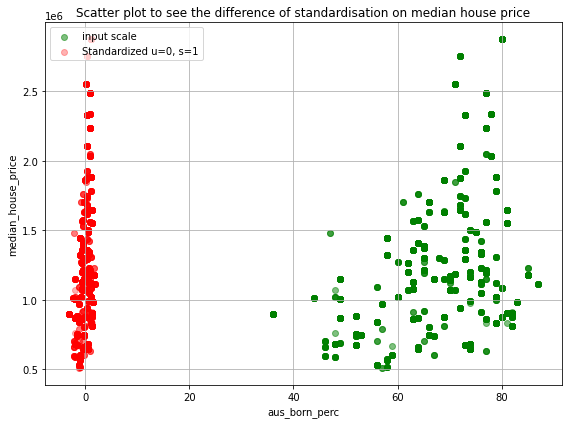

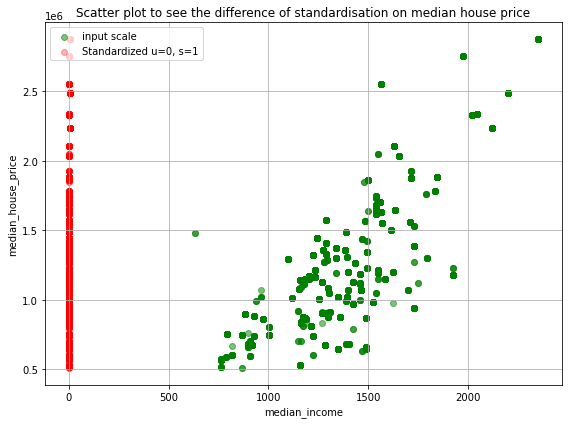

In [859]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='input scale', alpha=0.5)


        plt.scatter(df_std[:,x33], df_transform["median_house_price"], color='red',
             label='Standardized u=0, s=1', alpha=0.3) 

        plt.title('Scatter plot to see the difference of standardisation on median house price')
        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()


plt.show()

Scatter plot to see the difference of minmax on median house price

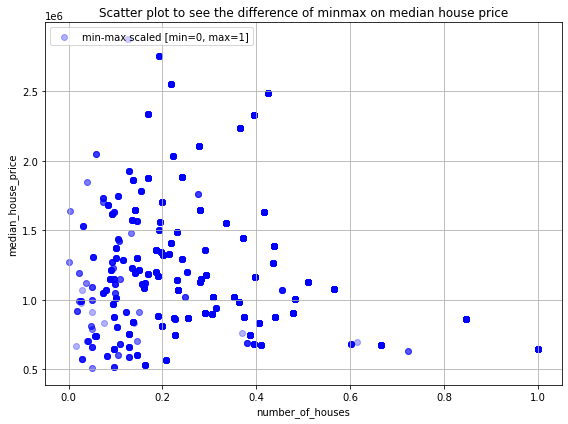

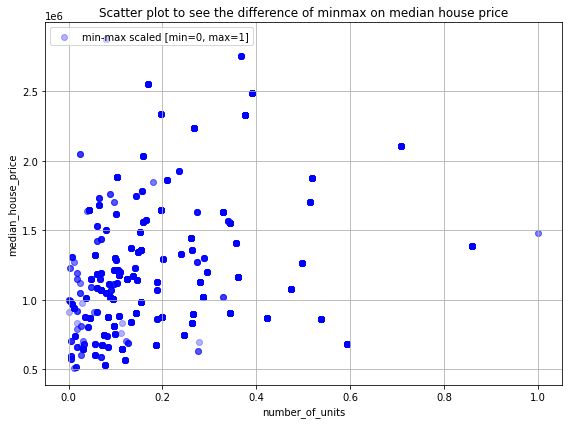

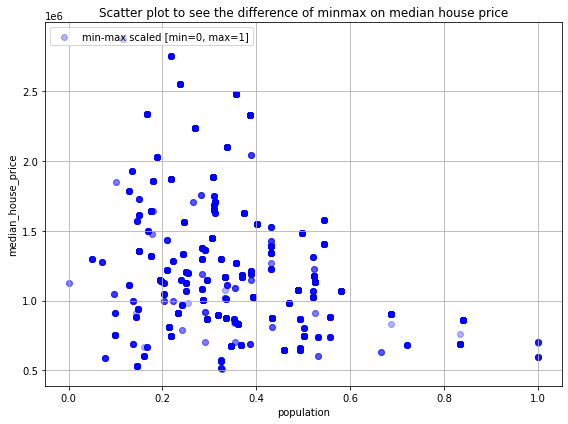

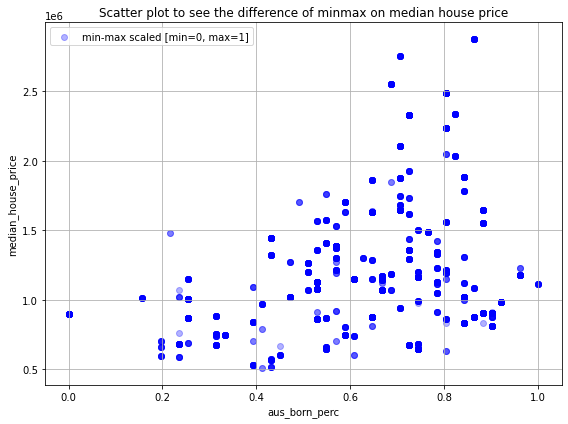

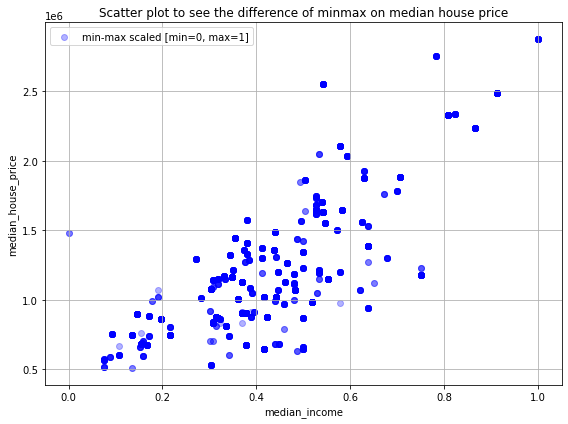

In [857]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        #plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
        #    color='green', label='input scale', alpha=0.5)


        #plt.scatter(df_std[:,x33], df_transform["median_house_price"], color='red',
        #     label='Standardized u=0, s=1', alpha=0.3) # can't print: μ = 0, σ = 0
    
        plt.scatter(df_minmax[:,x33], df_transform["median_house_price"],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

        plt.title('Scatter plot to see the difference of minmax on median house price')
        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()
    #f.savefig("z_min_max.pdf", bbox_inches='tight')

plt.show()

Scatter plot to see the difference of minmax on median house price and std on median house price in one plot

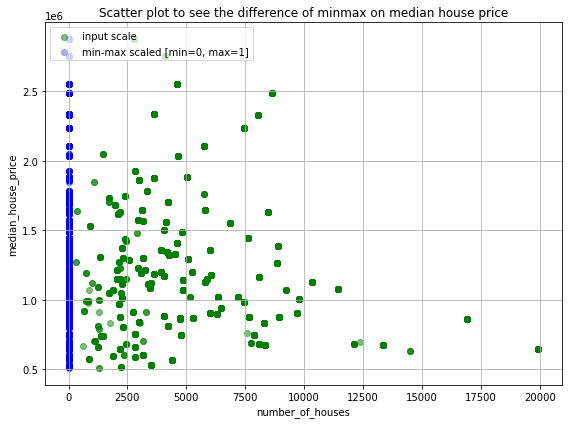

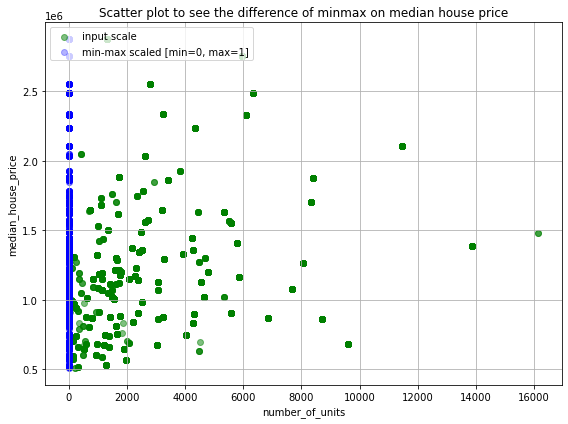

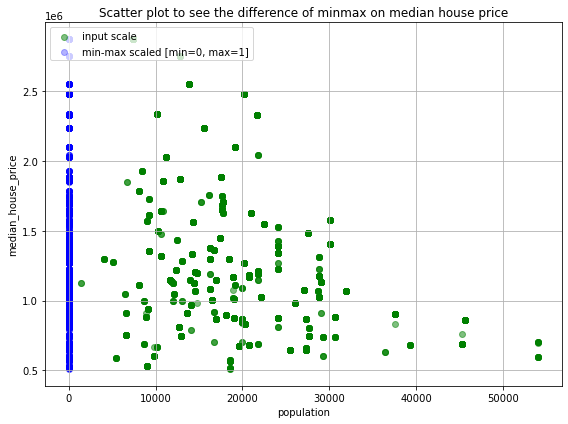

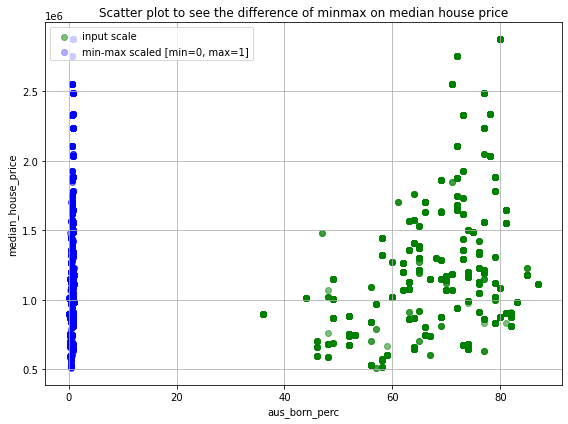

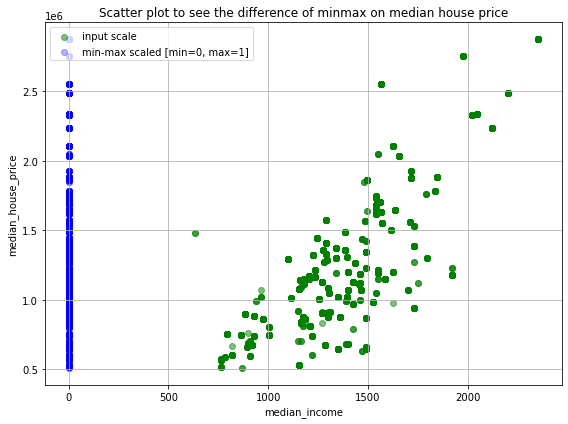

In [858]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='input scale', alpha=0.5)    
        plt.scatter(df_minmax[:,x33], df_transform["median_house_price"],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

        plt.title('Scatter plot to see the difference of minmax on median house price')
        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()

plt.show()

So we can see that the values of min max are more stardardized are having a more of an impact on the data as compared to z score. As we have seen from the plots above that min max has more of an impact on this dataset and so it is recommended here instead of z score.

Data Transformation

Root transformation is a type of variable transformation commonly used to normalize the distribution of data and address issues related to heteroscedasticity, skewness, or non-normality. In the context of preparing data for a linear model, applying a root transformation to variables can be beneficial in certain cases. 
Root transformation of variables can be beneficial here as it may:
1. Normalization: Root transformation helps normalize the distribution of variables. If the data is skewed or exhibits a non-normal distribution, applying a root transformation (such as square root or cube root) can help make the data more symmetrical and approximate a normal distribution. This can improve the assumptions of linearity, homoscedasticity, and normality required by linear models.
2. Linearizing relationships: In some cases, relationships between variables may not be linear. Applying a root transformation can help linearize these relationships, making them more amenable to linear modeling. This can lead to improved model fit and more reliable coefficient estimates.
3. Stabilizing variance: Heteroscedasticity, where the variability of the residuals changes across different levels of the independent variable, violates one of the assumptions of linear regression. Applying a root transformation can help stabilize the variance, reducing the impact of heteroscedasticity and improving the model's validity.
4. Improving interpretability: Root transformations can improve the interpretability of coefficients in linear models. For example, if you apply a square root transformation, the coefficient associated with the transformed variable represents the change in the dependent variable associated with a one-unit change in the square root of the independent variable. This can help make the interpretation of coefficients more meaningful and easier to grasp.
5. Mitigating the influence of outliers: Root transformations tend to compress the values of extreme outliers, reducing their influence on the model. This can be useful in situations where outliers have a disproportionate impact on the model's results.

Scatter plot of all the variable against median_house_price.

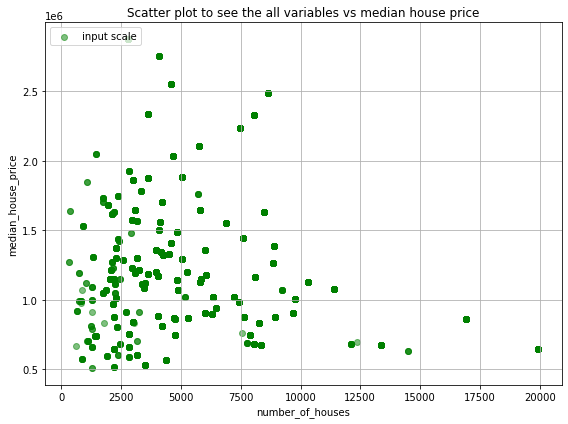

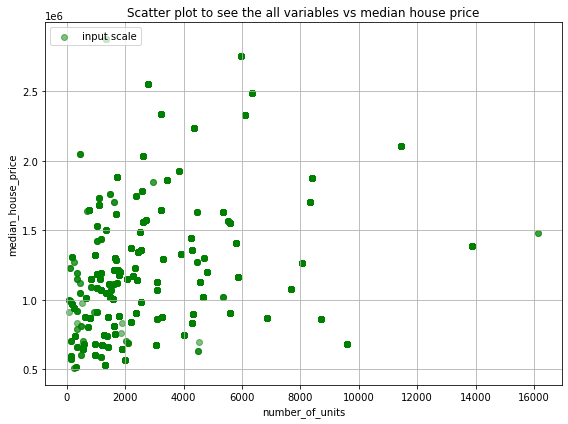

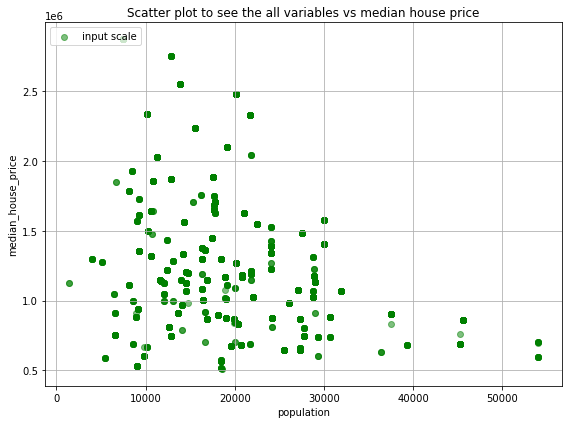

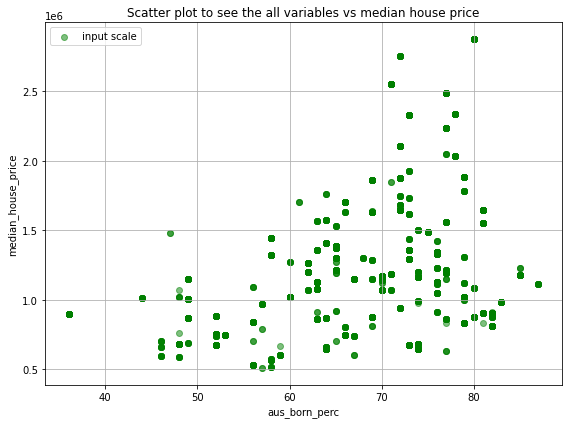

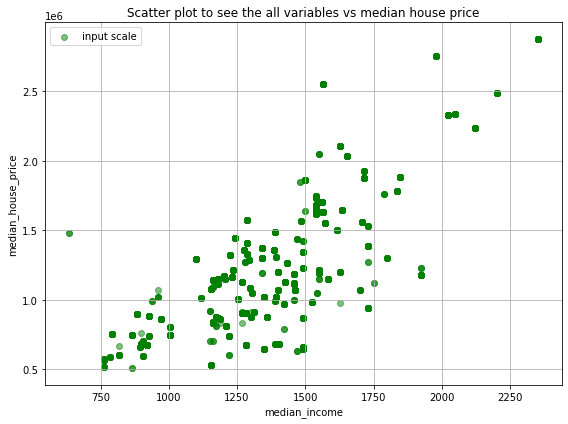

In [905]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='input scale', alpha=0.5)
        plt.title('Scatter plot to see the all variables vs median house price')
        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()


plt.show()

In the code below we are transformating the data in the following steps:
1. Creating new columns: Several new columns are added to the df_transform DataFrame, each with a suffix "rt" (indicating the square root transformation). These columns are initially set to None.

2. Looping through the DataFrame: The code iterates through each row of the df_transform DataFrame using the iterrows() method.

3. Applying square root transformation: Within the loop, the square root transformation is applied to each value in the specified columns using the math.sqrt() function. The transformed values are then assigned to the corresponding "rt" columns in the df_transform DataFrame using the at method.

4. Updating the index: The index variable i is incremented after each iteration to keep track of the row index.

5. Viewing the updated DataFrame: After the loop finishes, the head() method is used to display the first few rows of the updated df_transform DataFrame, showing the newly added columns with square root transformed values.

In [909]:
df_transform['number_of_housesrt'] = None
df_transform['number_of_unitsrt'] = None
df_transform['populationrt'] = None
df_transform['aus_born_percrt'] = None
df_transform['median_incomert'] = None
i = 0
for row in df_transform.iterrows():
    df_transform['number_of_housesrt'].at[i] = math.sqrt(df_transform["number_of_houses"][i])
    df_transform['number_of_unitsrt'].at[i] = math.sqrt(df_transform["number_of_units"][i])
    df_transform['populationrt'].at[i] = math.sqrt(df_transform["population"][i])
    df_transform['aus_born_percrt'].at[i] = math.sqrt(df_transform["aus_born_perc"][i])
    df_transform['median_incomert'].at[i] = math.sqrt(df_transform["median_income"][i])
    
    i += 1


<ipython-input-909-ab1ebb882bc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number_of_housesrt'] = None
<ipython-input-909-ab1ebb882bc0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number_of_unitsrt'] = None
<ipython-input-909-ab1ebb882bc0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

number_of_houses  number_of_units  population aus_born_perc median_income  \
0            5799.0           3228.0     17630.0            72          1538   
1            5799.0           3228.0     17630.0            72          1538   
2            5799.0           3228.0     17630.0            72          1538   
3            5799.0           3228.0     17630.0            72          1538   
4            5799.0           3228.0     17630.0            72          1538   

  median_house_price  number_of_housesscaled  number_of_unitsscaled  \
0            1649200               -0.120025              -0.064377   
1            1649200               -0.120025              -0.064377   
2            1649200               -0.120025              -0.064377   
3            1649200               -0.120025              -0.064377   
4            1649200               -0.120025              -0.064377   

   populationscaled  aus_born_percscaled  median_incomescaled  \
0         -0.324128             0.327105             0.509282   
1         -0.324128             0.327105             0.509282   
2         -0.324128             0.327105             0.509282   
3         -0.324128             0.327105             0.509282   
4         -0.324128             0.327105             0.509282   

  number_of_housesrt number_of_unitsrt populationrt aus_born_percrt  \
0            76.1512           56.8155      132.778         8.48528   
1            76.1512           56.8155      132.778         8.48528   
2            76.1512           56.8155      132.778         8.48528   
3            76.1512           56.8155      132.778         8.48528   
4            76.1512           56.8155      132.778         8.48528   

  median_incomert  
0         39.2173  
1         39.2173  
2         39.2173  
3         39.2173  
4         39.2173

In [910]:
xyy = ['number_of_housesrt','number_of_unitsrt','populationrt','aus_born_percrt','median_incomert'] # intializing new list ot make the plotting easier. 

<ipython-input-916-7aa7cce08786>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


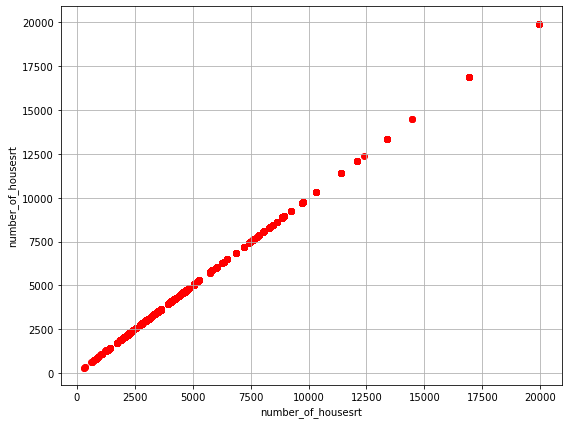

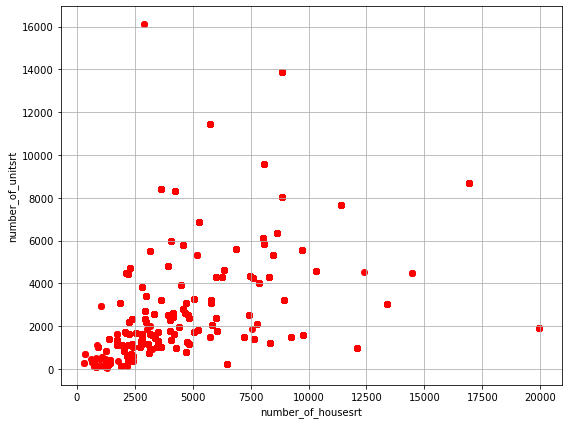

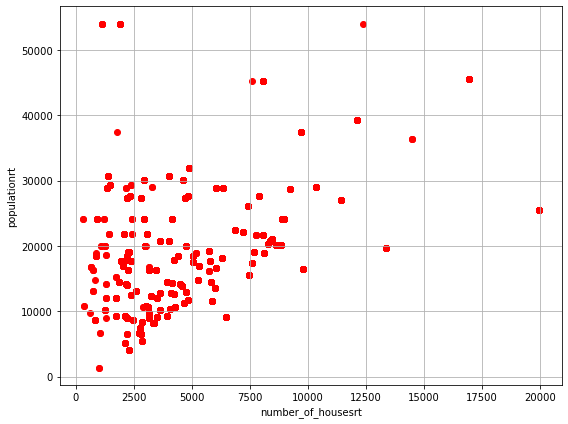

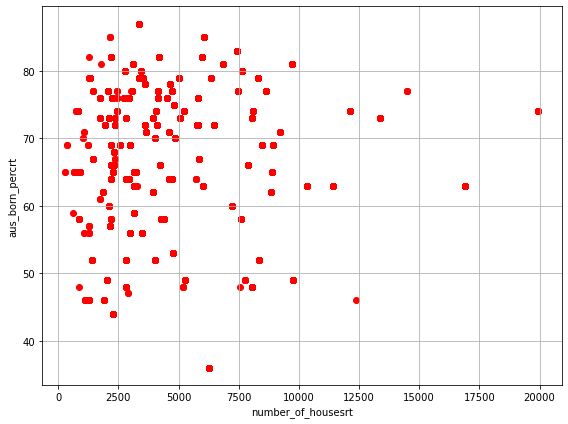

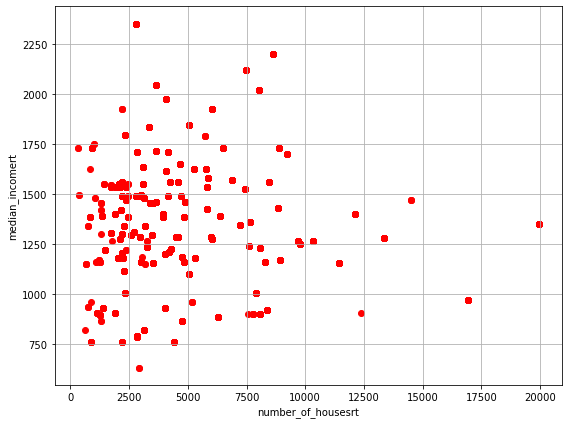

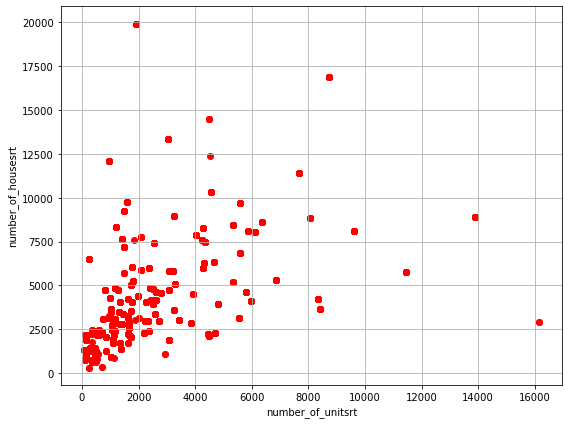

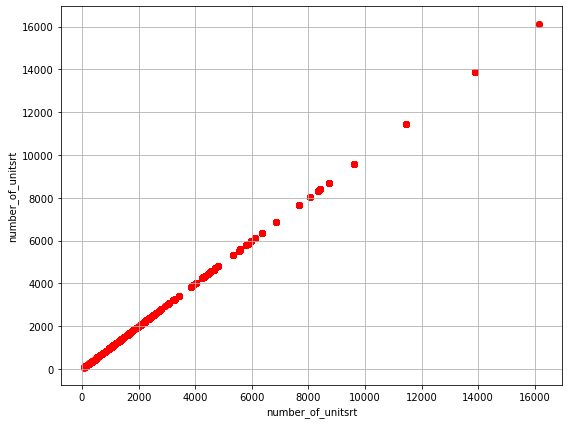

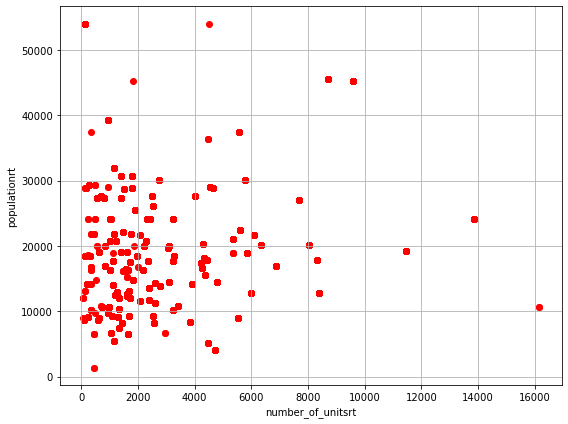

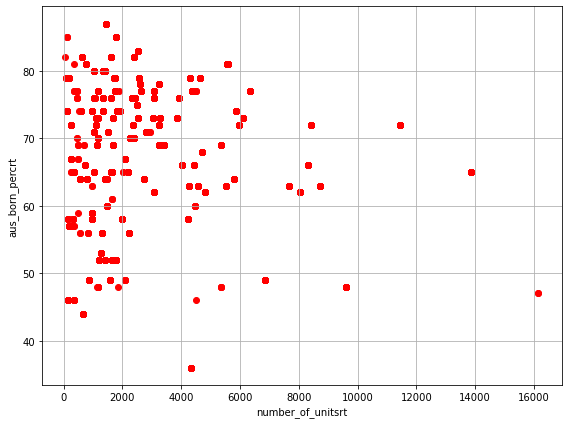

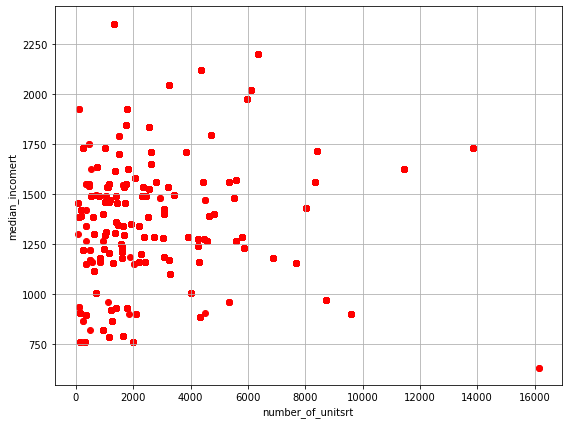

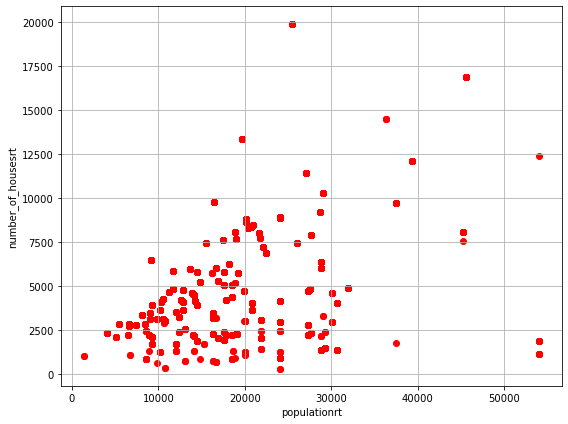

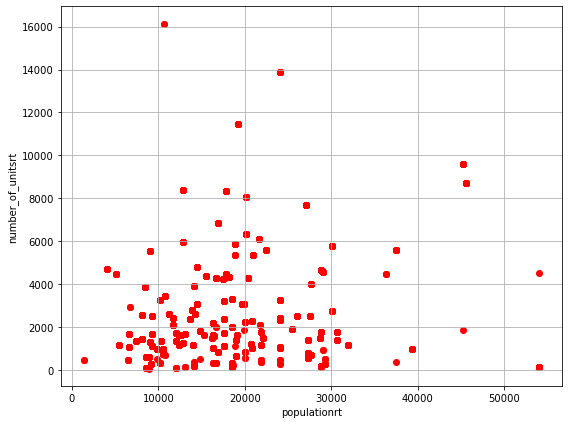

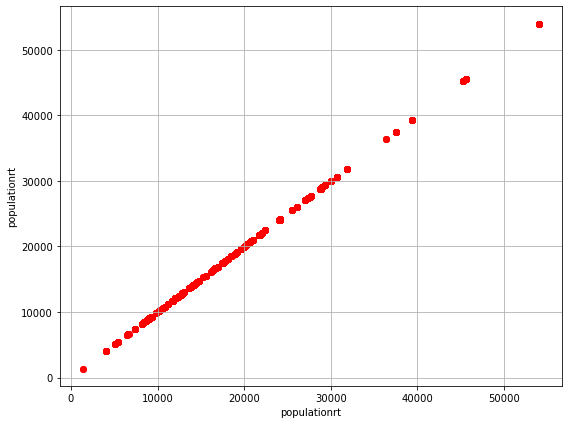

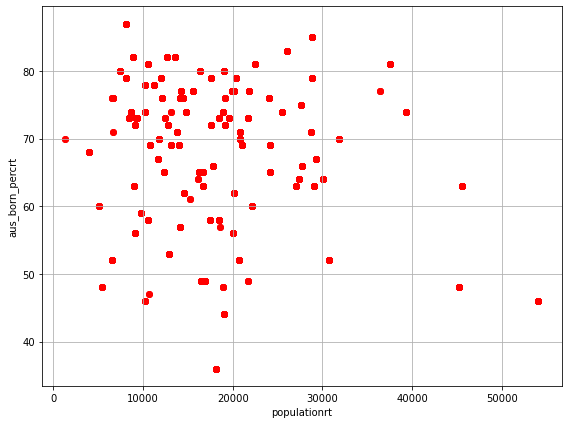

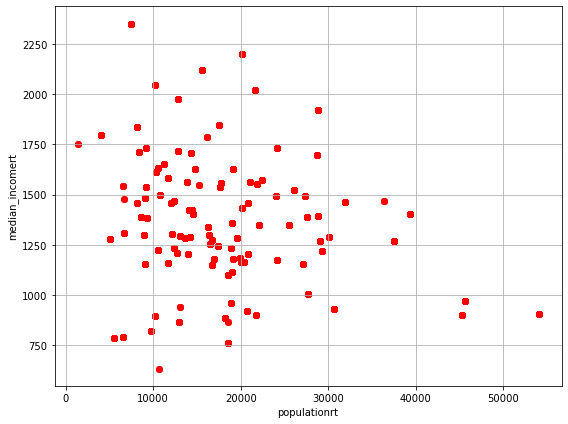

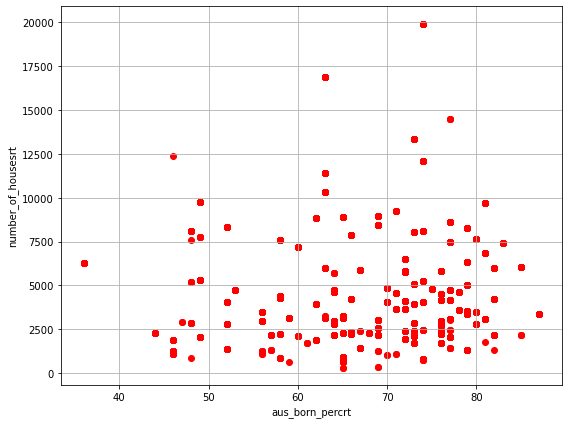

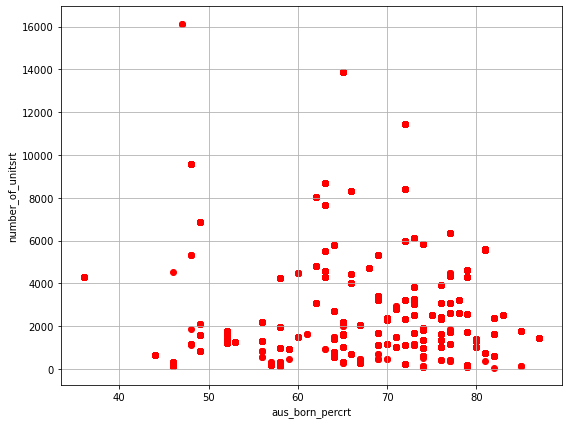

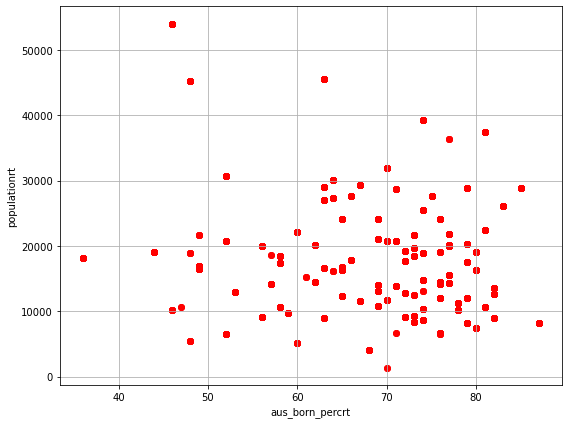

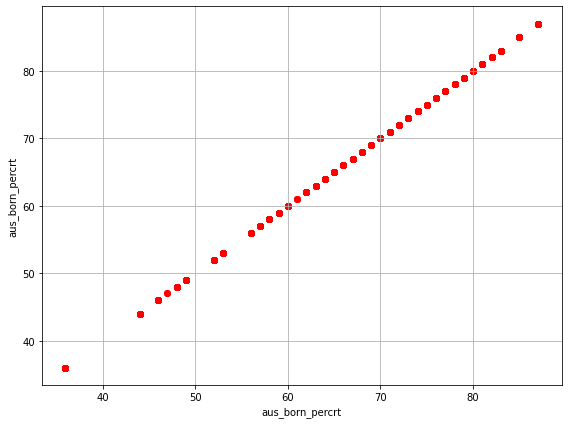

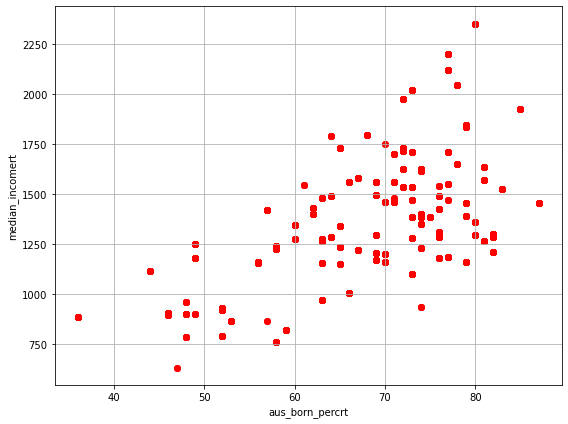

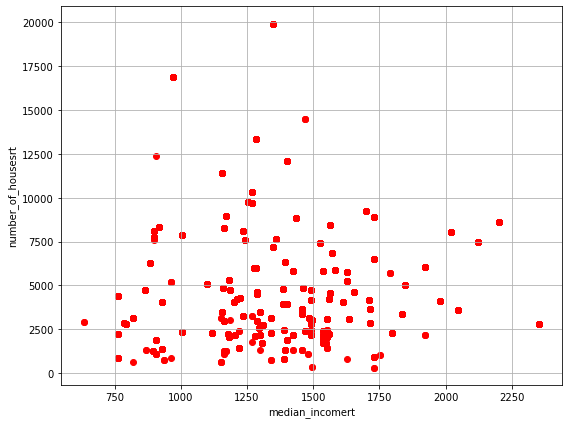

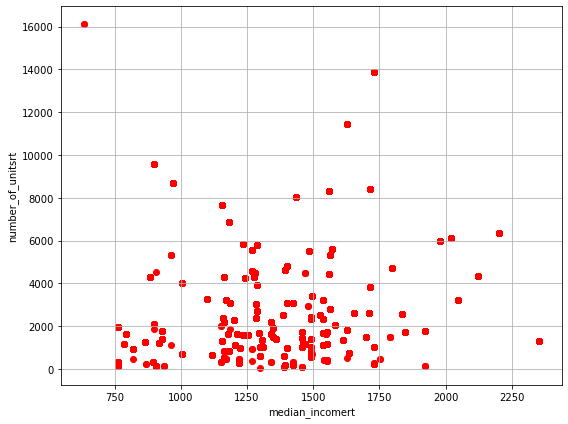

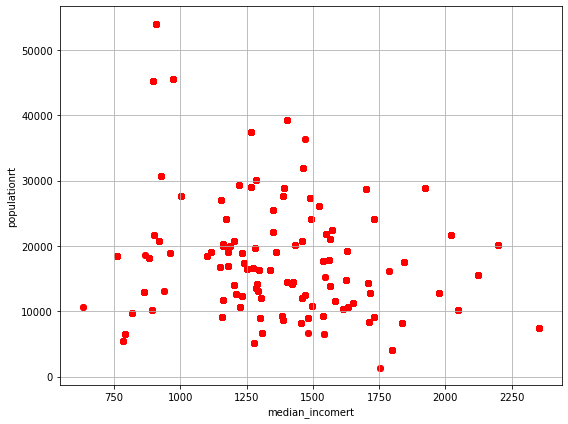

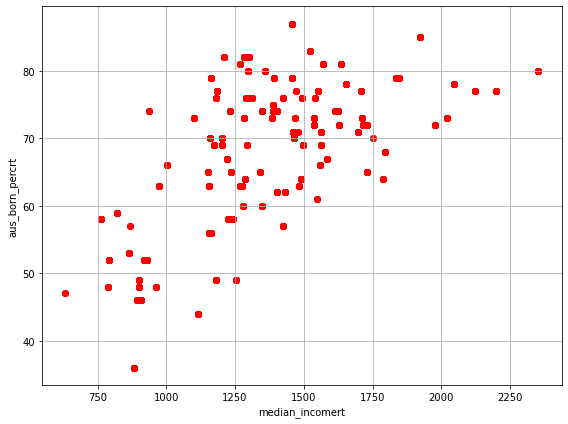

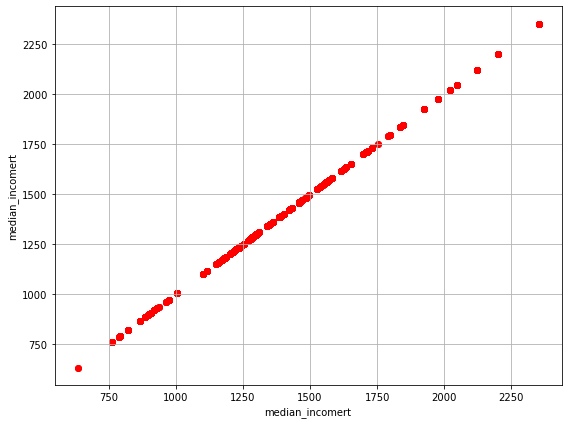

In [916]:
%matplotlib inline

from matplotlib import pyplot as plt
for x33 in  range(0,5):
    for x44 in range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform[x[x44]], color='red')
        plt.xlabel(x[x33])
        plt.ylabel(x[x44])

        plt.grid()
        plt.tight_layout()

plt.show()

PLot between the sqt values for all the variable after performaning the sqrt shows that the sqrt has reduced the data points being right skewed and has made made them more normally distributed. 

<ipython-input-915-2f09721d2e0d>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


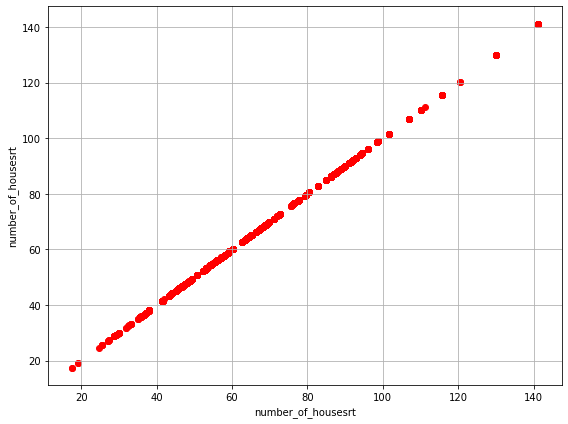

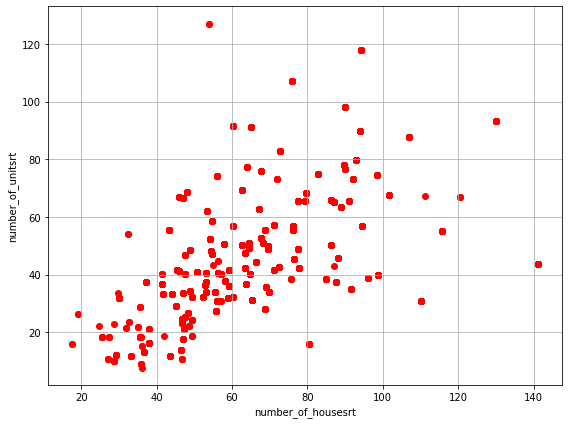

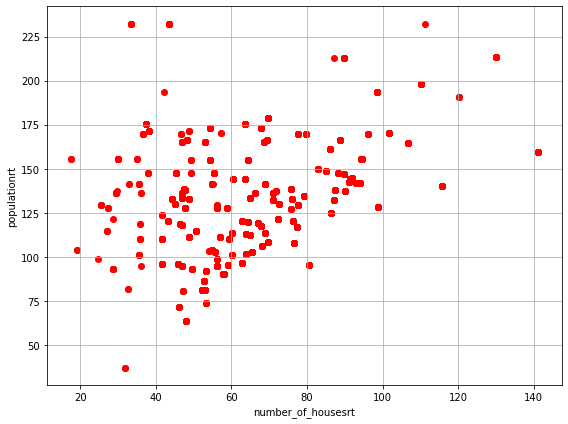

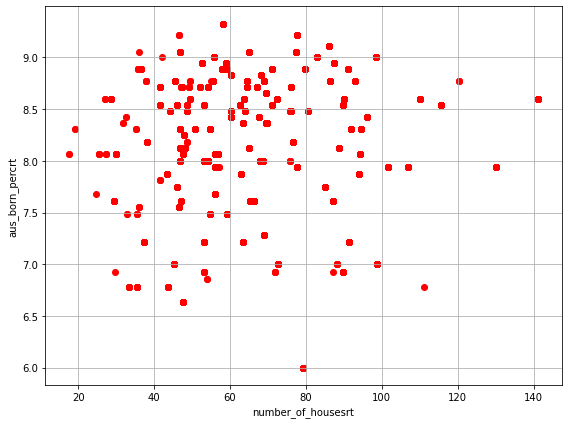

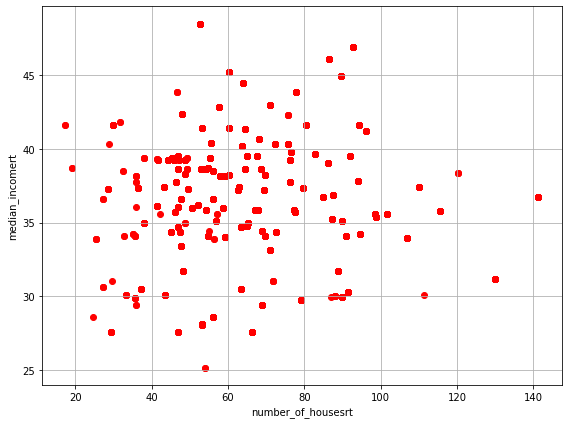

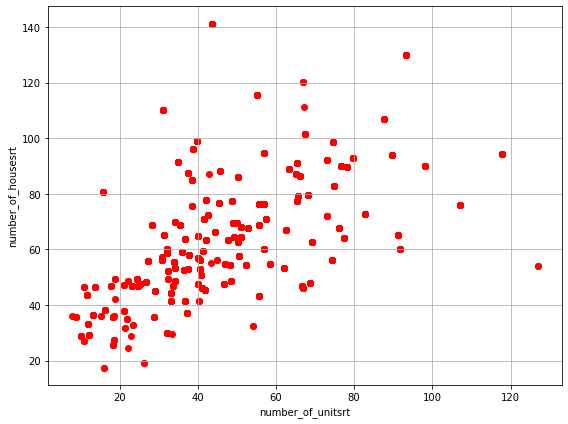

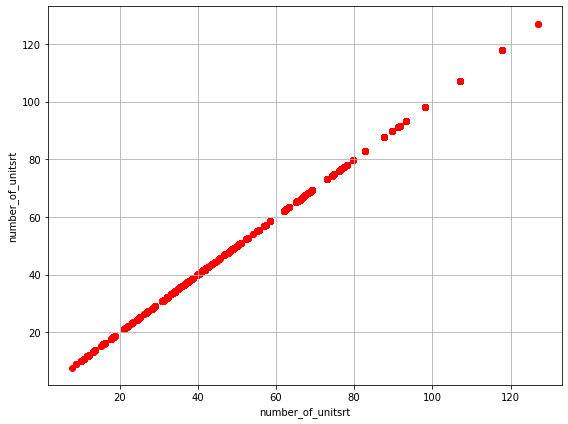

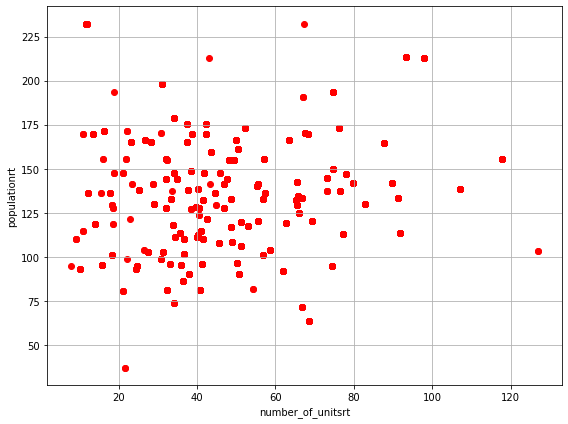

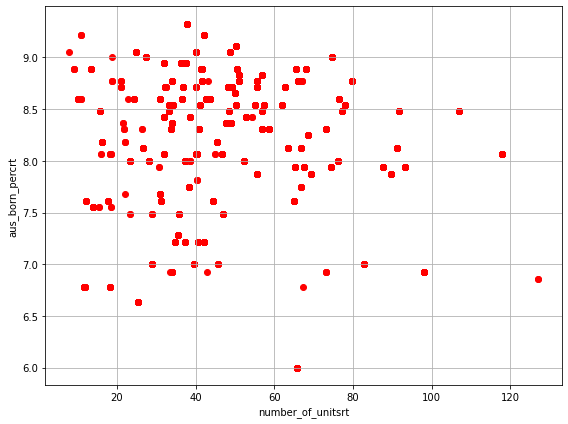

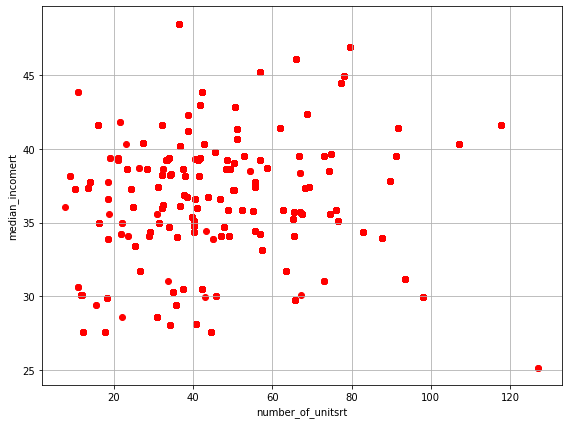

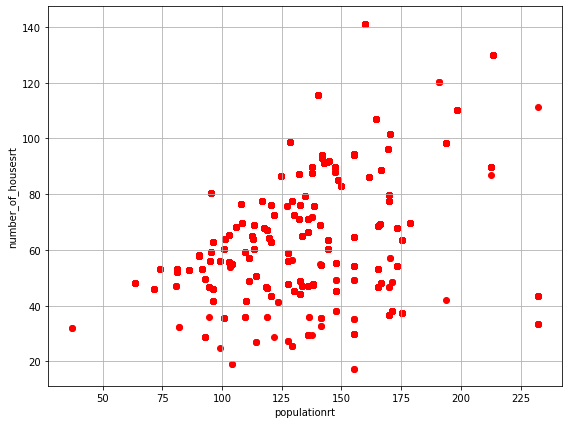

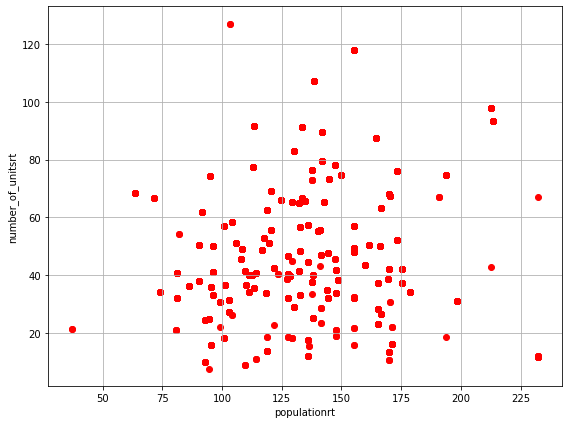

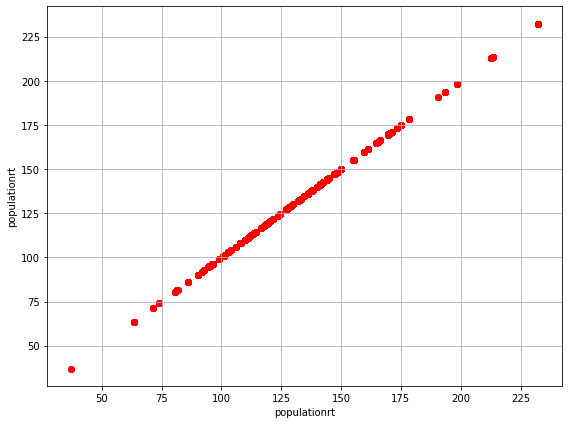

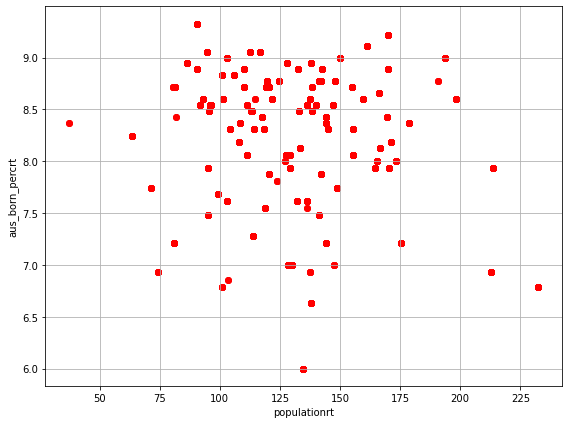

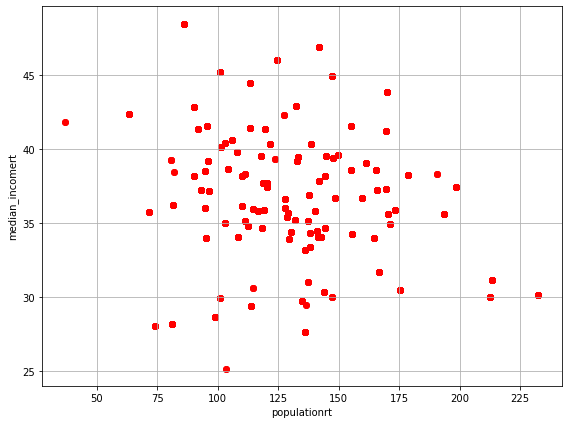

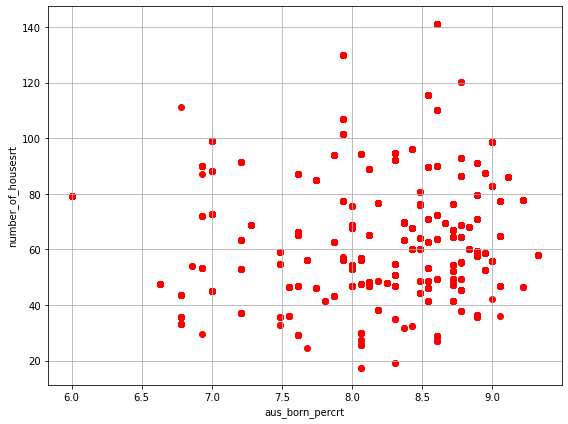

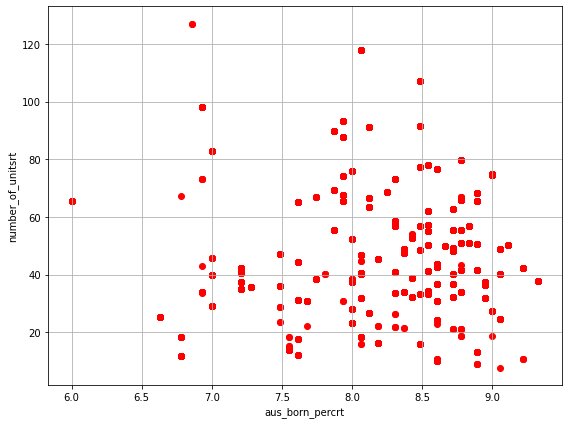

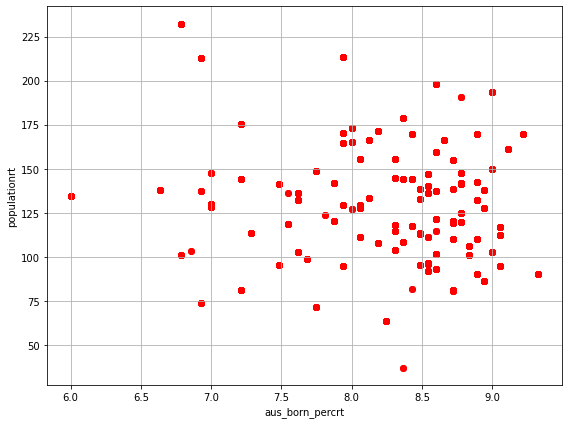

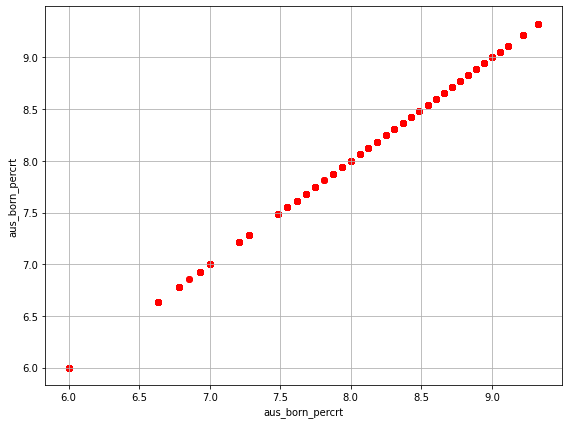

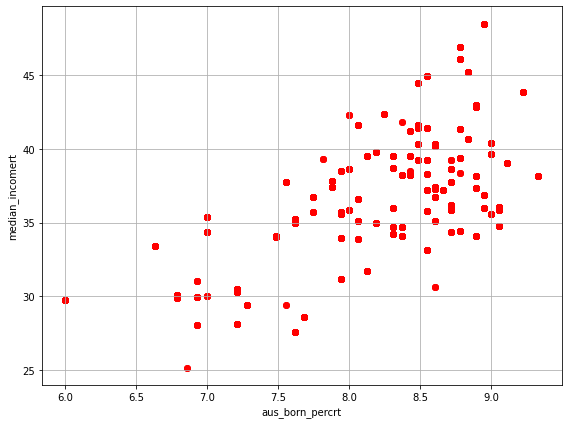

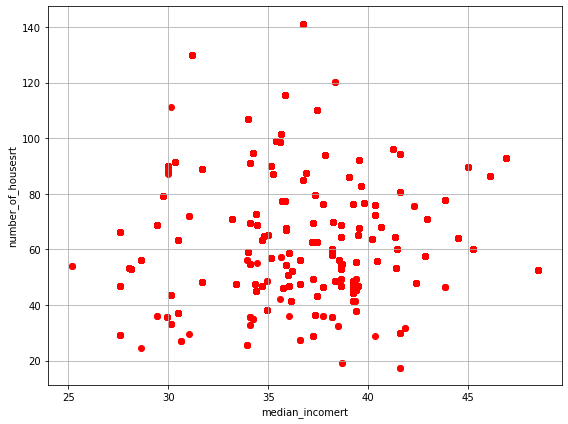

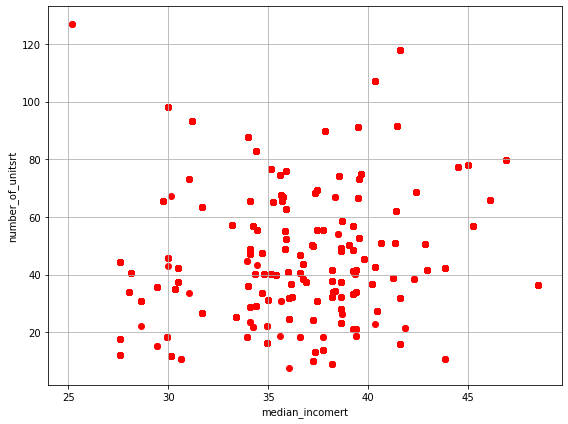

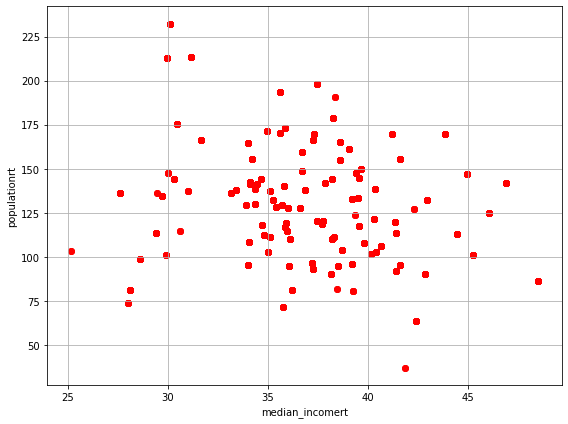

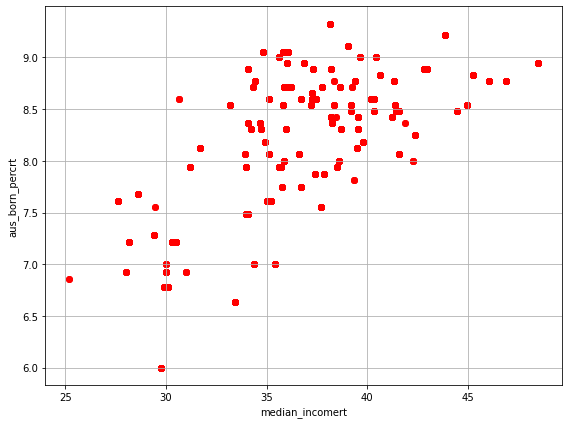

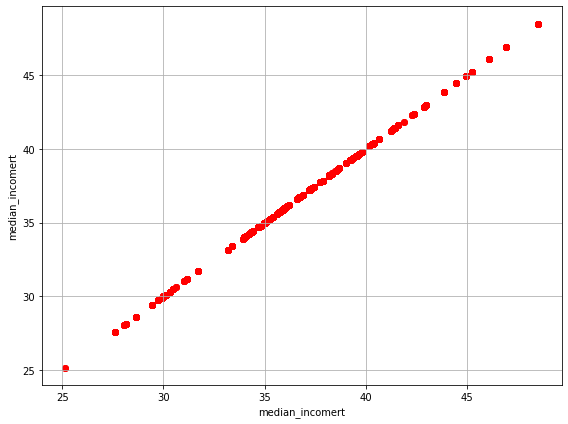

In [915]:
%matplotlib inline
for x33 in  range(0,5):
    for x44 in range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[xyy[x33]], df_transform[xyy[x44]], color='red')

        plt.xlabel(xyy[x33])
        plt.ylabel(xyy[x44])

        plt.grid()
        plt.tight_layout()


plt.show()

If we plot the values for can see that the values are more more spread out then the orginal values. For median income the plot looks more like a linear line so it might be a good choice to use this method. Applying a root transformation appears to be linearizing relationships here, making them more amenable to linear modeling. This can lead to improved model fit and more reliable coefficient estimates.

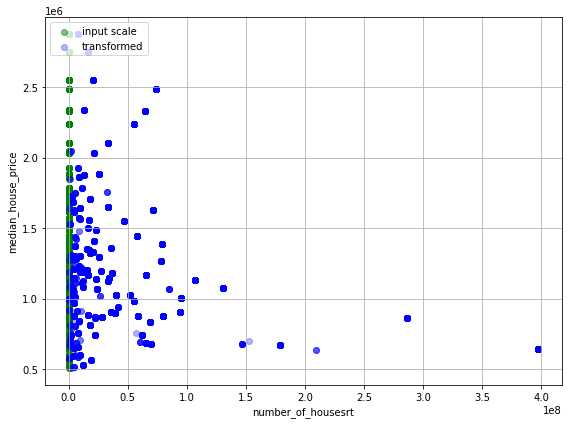

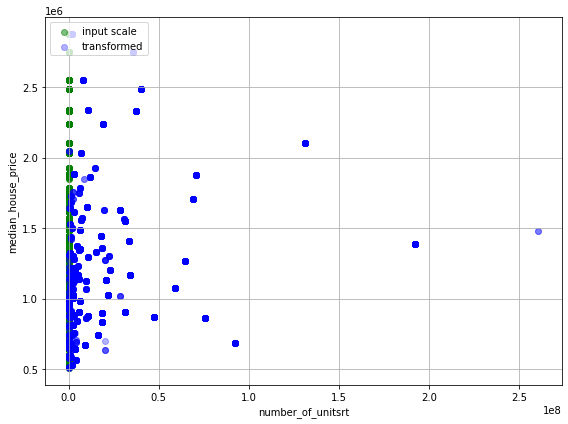

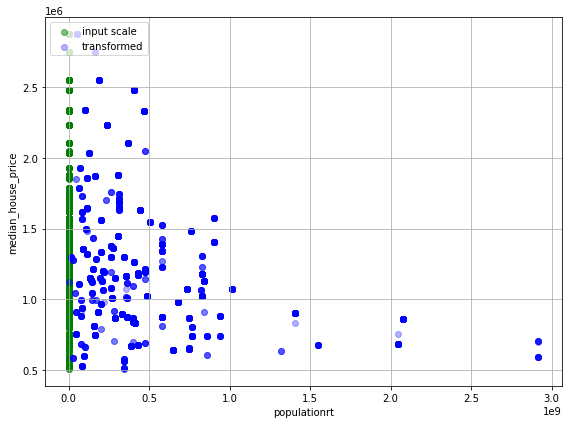

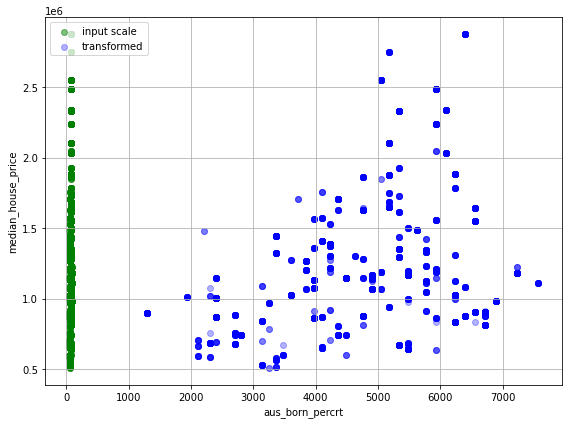

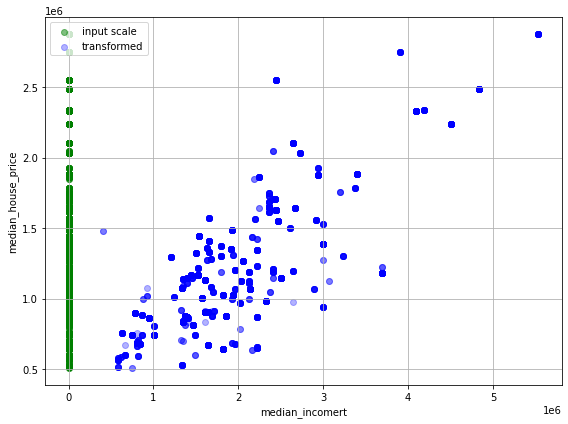

In [924]:
%matplotlib inline
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='Origanal', alpha=0.5)

        plt.scatter(df_transform[xyy[x33]], df_transform["median_house_price"],
            color='blue', label='transformed', alpha=0.3)


        plt.xlabel(xyy[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()

plt.show()

Square power transformation

Power 2 transformations, also known as squared transformations, involve squaring the values of a variable. Applying power 2 transformations to variables can have several uses and benefits in the context of a linear model:

Nonlinear relationships: In some cases, the relationship between the independent variable and the dependent variable may not be strictly linear. Squaring the independent variable can capture quadratic or curvilinear relationships. This allows the linear model to account for nonlinear patterns in the data and potentially improve model fit.

Interaction terms: Power 2 transformations can be used to create interaction terms in a linear model. By squaring an independent variable and including it as an additional predictor alongside the original variable, you can capture the interaction effect between the two variables.

Enhancing linearity: Squaring a variable can help transform skewed or non-normal distributions into a more symmetrical shape, which may align better with the assumptions of a linear model. This can improve the linearity assumption and lead to more reliable coefficient estimates.

Capturing heteroscedasticity: Power 2 transformations can be useful in addressing heteroscedasticity, where the variability of the residuals changes across different levels of the independent variable. Squaring the independent variable can help stabilize the variance and achieve more constant error terms.

Interpretability: In some cases, the squared term itself may have a meaningful interpretation. For example, in economics, squaring a variable can capture the concept of diminishing marginal returns or the quadratic relationship between inputs and outputs.
THe code below performs the following functions:
Creating new columns: Several new columns are added to the df_transform DataFrame, each with a suffix "rt" (indicating the power 2 transformation). These columns are initially set to None.

Initializing the index: The variable i is initialized to 0. This variable will be used to keep track of the row index.

Looping through the DataFrame: The code iterates through each row of the df_transform DataFrame using the iterrows() method.

Applying power 2 transformation: Within the loop, the power 2 transformation (squaring) is applied to each value in the specified columns using the math.pow() function. The transformed values are then assigned to the corresponding "rt" columns in the df_transform DataFrame using the at method.

Updating the index: The index variable i is incremented after each iteration to move to the next row.

In [925]:
df_transform['number_of_housesrt'] = None
df_transform['number_of_unitsrt'] = None
df_transform['populationrt'] = None
df_transform['aus_born_percrt'] = None
df_transform['median_incomert'] = None
i = 0
for row in df_transform.iterrows():
    df_transform['number_of_housesrt'].at[i] = math.pow(df_transform["number_of_houses"][i],2)
    df_transform['number_of_unitsrt'].at[i] = math.pow(df_transform["number_of_units"][i],2)
    df_transform['populationrt'].at[i] = math.pow(df_transform["population"][i],2)
    df_transform['aus_born_percrt'].at[i] = math.pow(df_transform["aus_born_perc"][i],2)
    df_transform['median_incomert'].at[i] = math.pow(df_transform["median_income"][i],2)
    i += 1

    

number_of_houses  number_of_units  population aus_born_perc median_income  \
0            5799.0           3228.0     17630.0            72          1538   
1            5799.0           3228.0     17630.0            72          1538   
2            5799.0           3228.0     17630.0            72          1538   
3            5799.0           3228.0     17630.0            72          1538   
4            5799.0           3228.0     17630.0            72          1538   

  median_house_price  number_of_housesscaled  number_of_unitsscaled  \
0            1649200               -0.120025              -0.064377   
1            1649200               -0.120025              -0.064377   
2            1649200               -0.120025              -0.064377   
3            1649200               -0.120025              -0.064377   
4            1649200               -0.120025              -0.064377   

   populationscaled  aus_born_percscaled  ...  number_of_housesrt  \
0         -0.324128             0.327105  ...         3.36284e+07   
1         -0.324128             0.327105  ...         3.36284e+07   
2         -0.324128             0.327105  ...         3.36284e+07   
3         -0.324128             0.327105  ...         3.36284e+07   
4         -0.324128             0.327105  ...         3.36284e+07   

  number_of_unitsrt populationrt aus_born_percrt median_incomert  \
0         1.042e+07  3.10817e+08            5184     2.36544e+06   
1         1.042e+07  3.10817e+08            5184     2.36544e+06   
2         1.042e+07  3.10817e+08            5184     2.36544e+06   
3         1.042e+07  3.10817e+08            5184     2.36544e+06   
4         1.042e+07  3.10817e+08            5184     2.36544e+06   

  number_of_housespt number_of_unitspt populationpt aus_born_percpt  \
0        3.36284e+07         1.042e+07  3.10817e+08            5184   
1        3.36284e+07         1.042e+07  3.10817e+08            5184   
2        3.36284e+07         1.042e+07  3.10817e+08            5184   
3        3.36284e+07         1.042e+07  3.10817e+08            5184   
4        3.36284e+07         1.042e+07  3.10817e+08            5184   

  median_incomept  
0     2.36544e+06  
1     2.36544e+06  
2     2.36544e+06  
3     2.36544e+06  
4     2.36544e+06  

[5 rows x 21 columns]

Plot between all the transformed variables

<ipython-input-926-5c475ba7d94f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


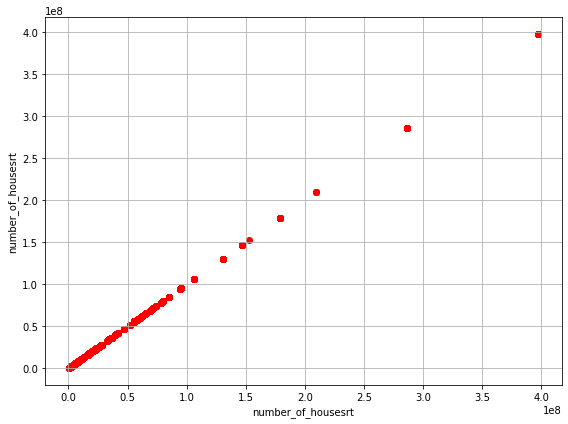

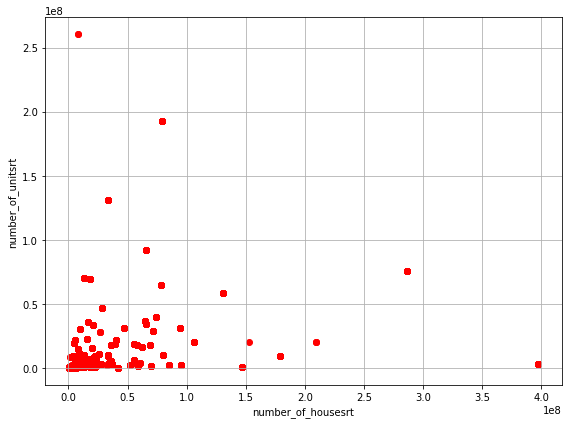

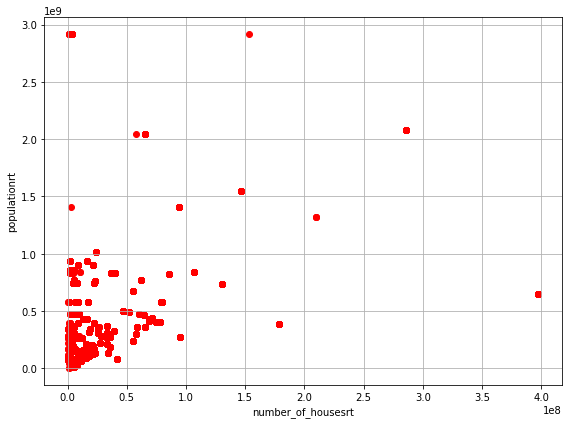

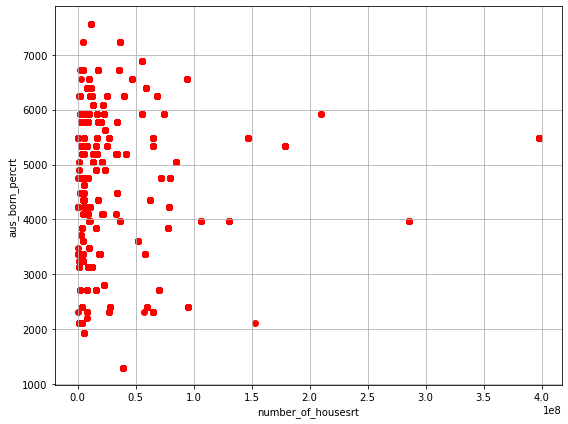

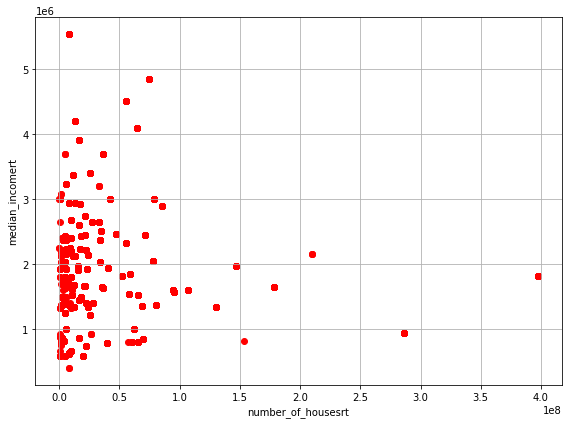

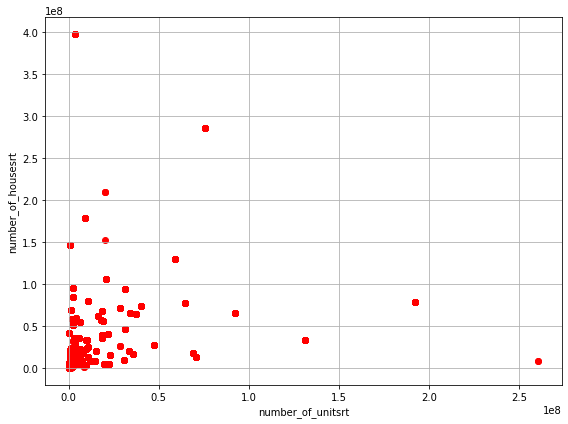

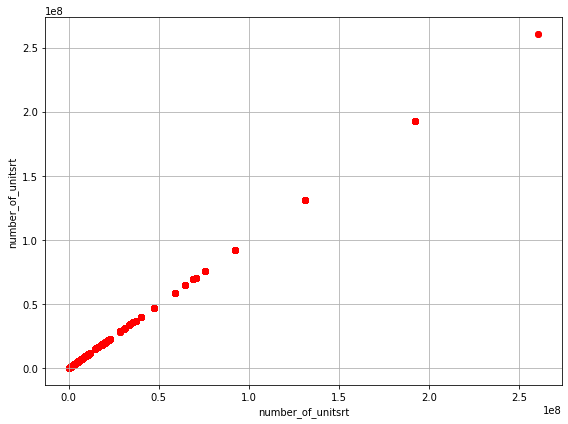

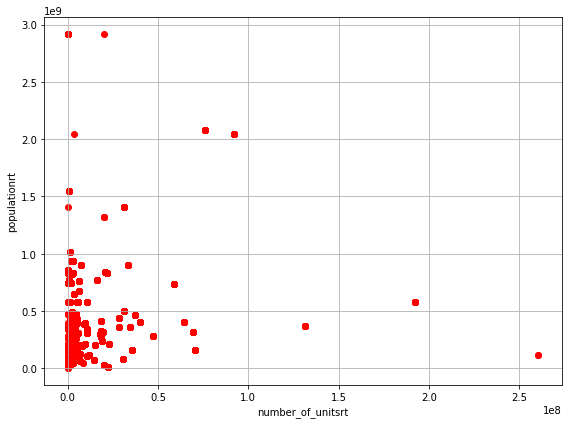

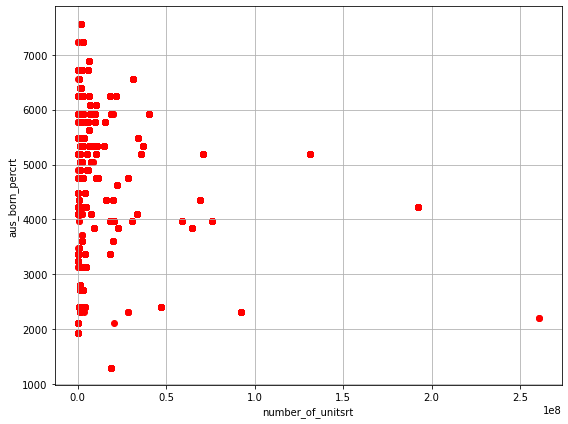

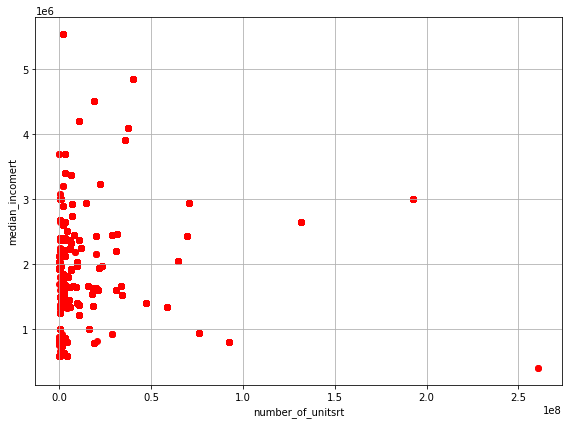

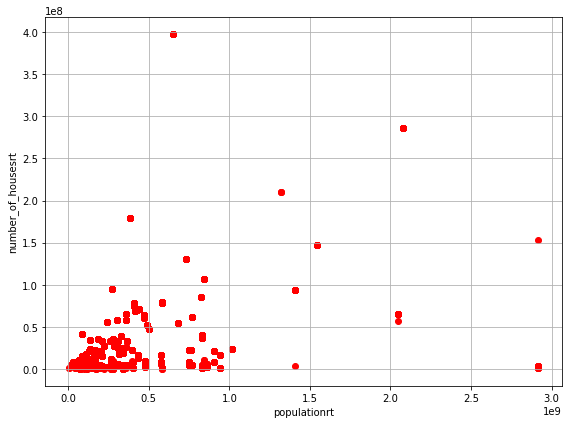

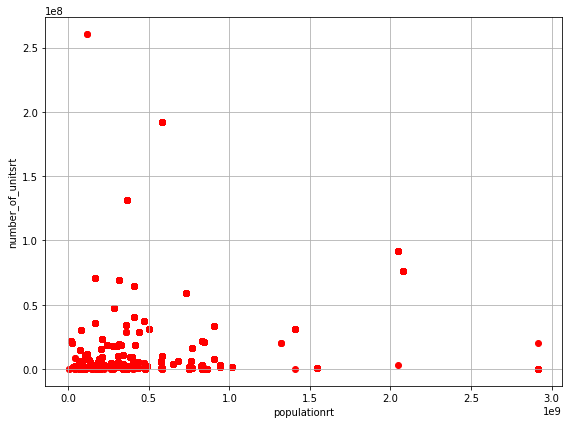

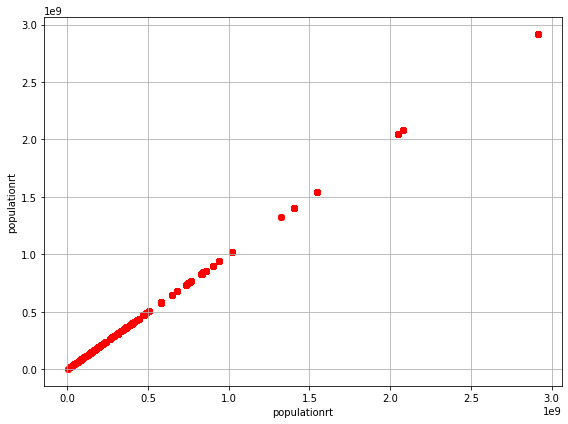

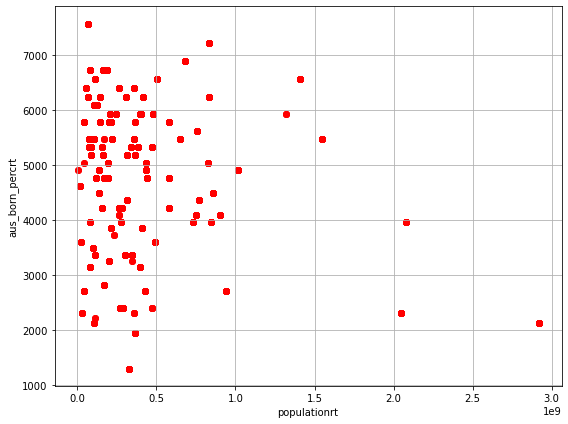

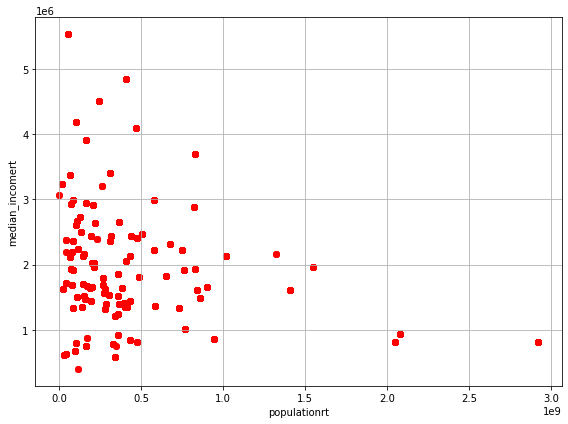

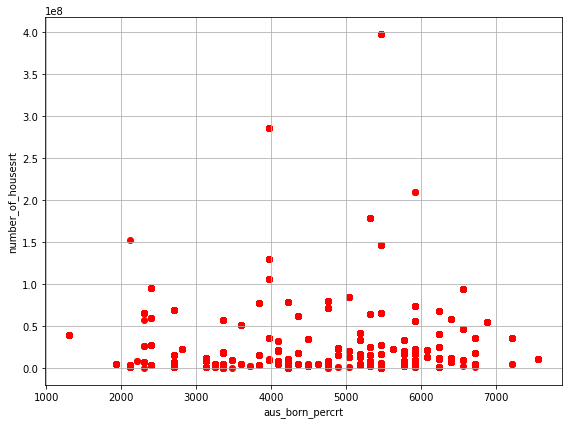

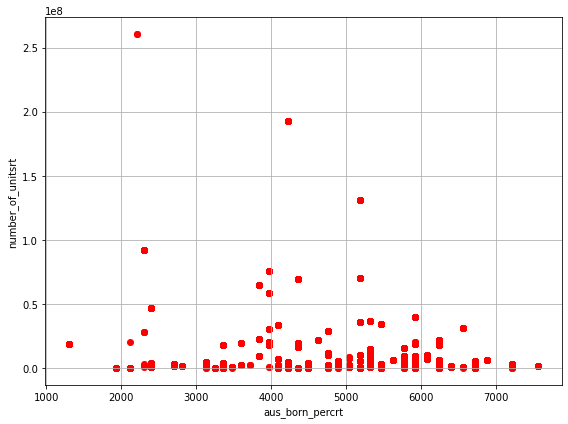

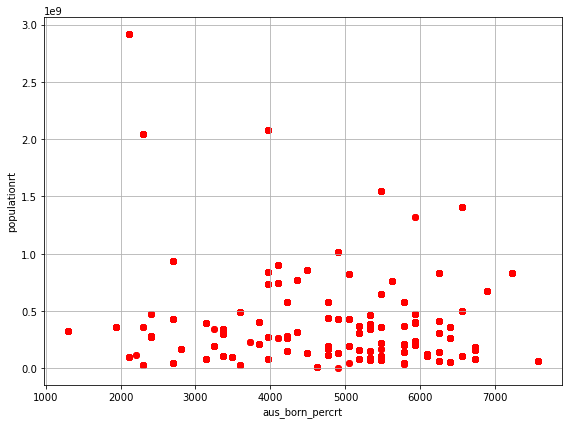

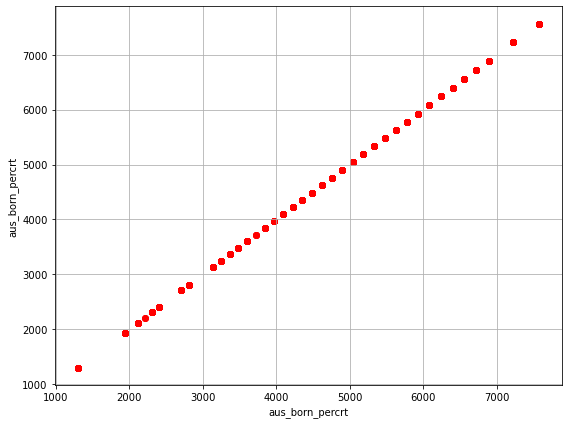

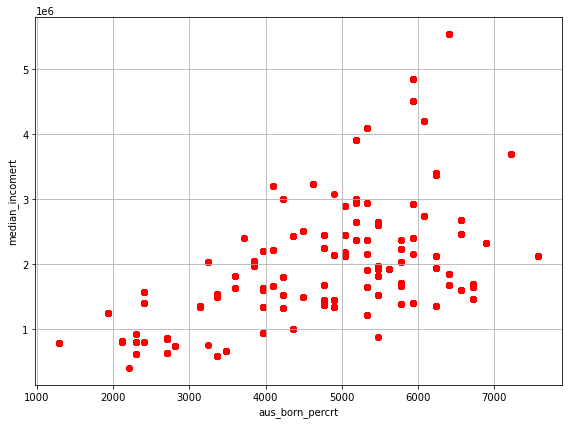

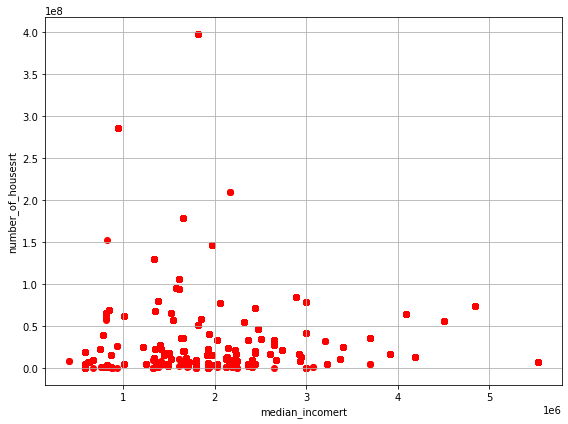

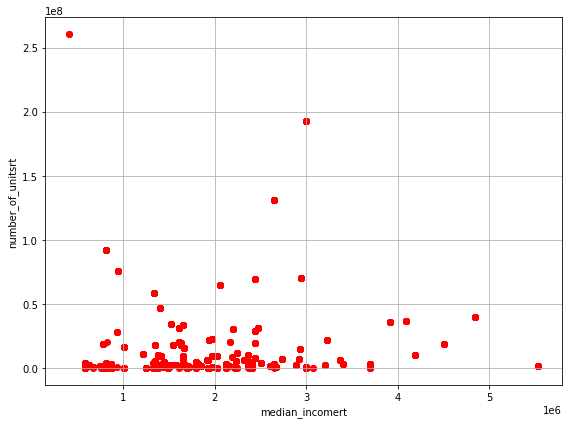

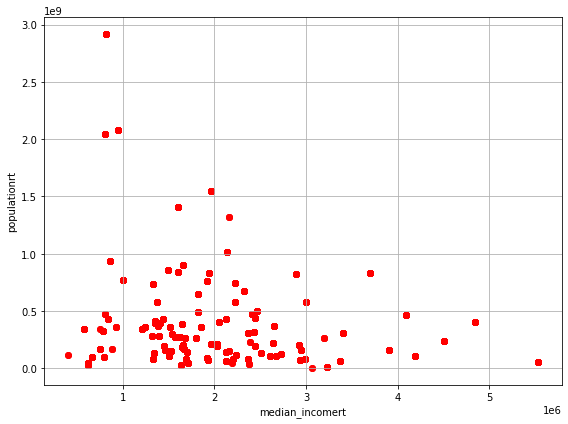

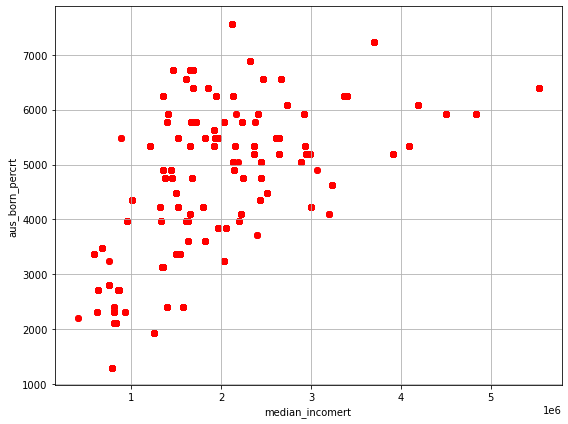

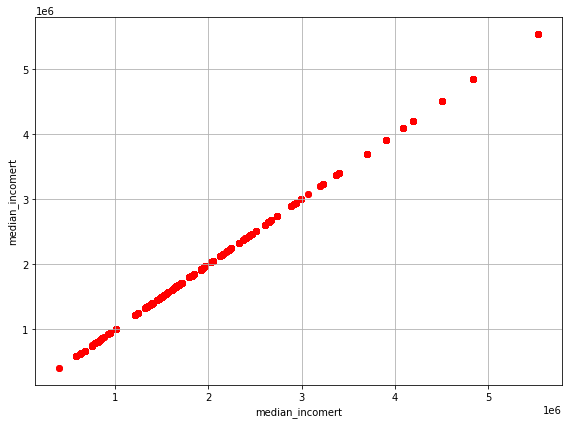

In [926]:
%matplotlib inline
for x33 in  range(0,5):
    for x44 in range(0,5):
        f = plt.figure(figsize=(8,6))


        plt.scatter(df_transform[xyy[x33]], df_transform[xyy[x44]], color='red')


        plt.xlabel(xyy[x33])
        plt.ylabel(xyy[x44])
        plt.grid()
        plt.tight_layout()

plt.show()

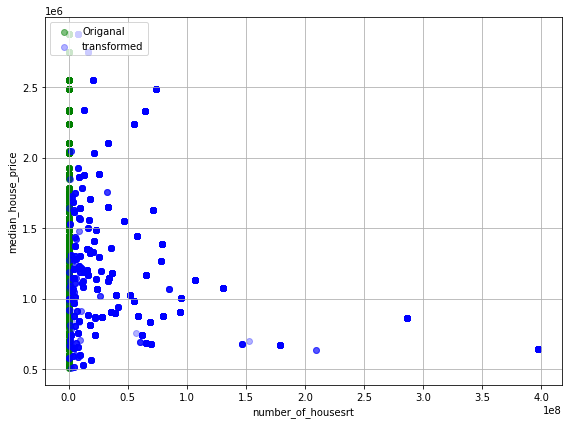

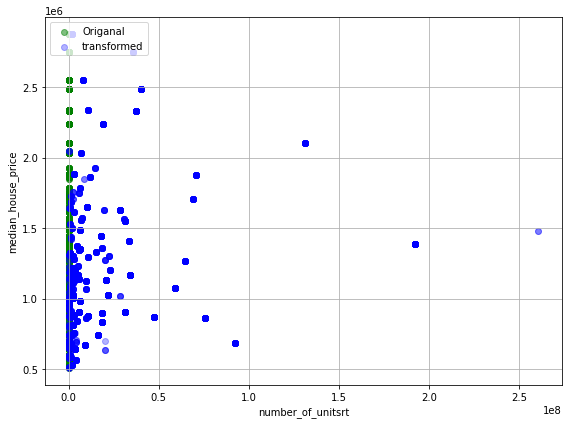

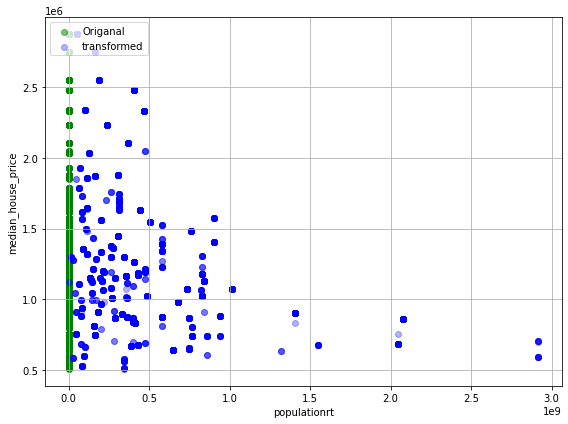

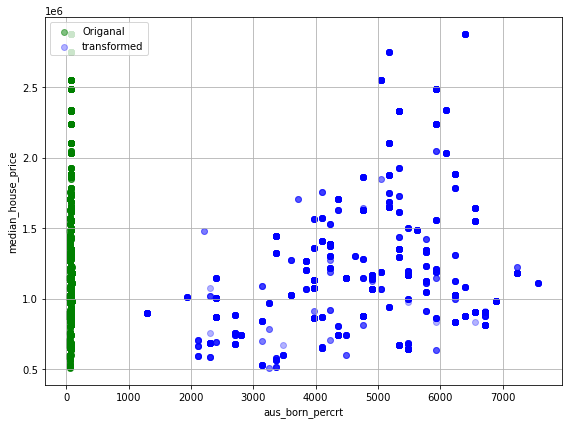

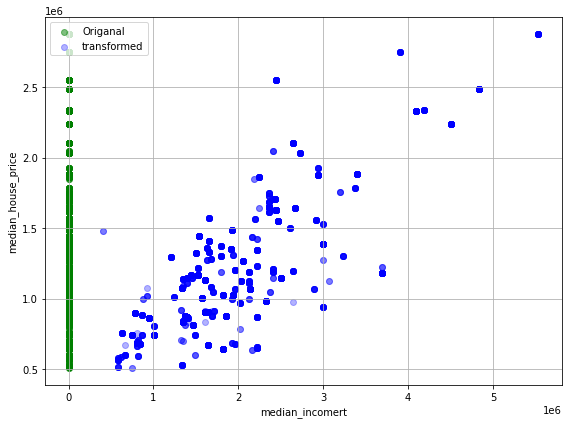

In [927]:
%matplotlib inline
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='Origanal', alpha=0.5)

    
        plt.scatter(df_transform[xyy[x33]], df_transform["median_house_price"],
            color='blue', label='transformed', alpha=0.3)


        plt.xlabel(xyy[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()

plt.show()

The plots below show that power 2 transformation do not appear to have muuch of an impact on the data as compared to the sqrt method as the the data is not as normalized. 

Log transformation
A log transformation involves taking the logarithm of a variable before using it as an input to a linear model. This transformation can be applied to the independent variable, the dependent variable, or both, depending on the specific situation and the goals of the analysis. It is useful because of the following:

Skewed variables: If a variable is highly skewed, applying a log transformation can help reduce the skewness and make the variable more symmetrical. This can improve the linearity assumption between the independent variable and the dependent variable in the linear model.

Multiplicative relationships: In some cases, the relationship between variables may be multiplicative rather than additive. Taking the logarithm of the variables can transform the multiplicative relationship into an additive one. This can simplify the interpretation of the coefficients in the linear model.

Heteroscedasticity: Log transformations can help address heteroscedasticity, where the variability of the residuals changes across different levels of the independent variable. By compressing the scale of the variable, a log transformation can help stabilize the variance and reduce heteroscedasticity, improving the model's validity.

Interpretability: Log transformations can improve the interpretability of coefficients in the linear model. For example, if you take the logarithm of a variable, the coefficient associated with that variable represents the percentage change in the dependent variable for a one percent change in the independent variable. This can make the interpretation of coefficients more meaningful and easier to understand.

Outlier mitigation: Log transformations tend to compress the values of extreme outliers. This can help mitigate the influence of outliers on the model, as extreme values are shrunk closer to the mean.


In [928]:
df_transform['number_of_housesrt'] = None
df_transform['number_of_unitsrt'] = None
df_transform['populationrt'] = None
df_transform['aus_born_percrt'] = None
df_transform['median_incomert'] = None
i = 0
for row in df_transform.iterrows():
    df_transform['number_of_housesrt'].at[i] = math.log(df_transform["number_of_houses"][i])
    df_transform['number_of_unitsrt'].at[i] = math.log(df_transform["number_of_units"][i])
    df_transform['populationrt'].at[i] = math.log(df_transform["population"][i])
    df_transform['aus_born_percrt'].at[i] = math.log(df_transform["aus_born_perc"][i])
    df_transform['median_incomert'].at[i] = math.log(df_transform["median_income"][i])
    i += 1

    
df_transform.head()

number_of_houses  number_of_units  population aus_born_perc median_income  \
0            5799.0           3228.0     17630.0            72          1538   
1            5799.0           3228.0     17630.0            72          1538   
2            5799.0           3228.0     17630.0            72          1538   
3            5799.0           3228.0     17630.0            72          1538   
4            5799.0           3228.0     17630.0            72          1538   

  median_house_price  number_of_housesscaled  number_of_unitsscaled  \
0            1649200               -0.120025              -0.064377   
1            1649200               -0.120025              -0.064377   
2            1649200               -0.120025              -0.064377   
3            1649200               -0.120025              -0.064377   
4            1649200               -0.120025              -0.064377   

   populationscaled  aus_born_percscaled  ...  number_of_housesrt  \
0         -0.324128             0.327105  ...             8.66544   
1         -0.324128             0.327105  ...             8.66544   
2         -0.324128             0.327105  ...             8.66544   
3         -0.324128             0.327105  ...             8.66544   
4         -0.324128             0.327105  ...             8.66544   

  number_of_unitsrt populationrt aus_born_percrt median_incomert  \
0           8.07962      9.77736         4.27667         7.33824   
1           8.07962      9.77736         4.27667         7.33824   
2           8.07962      9.77736         4.27667         7.33824   
3           8.07962      9.77736         4.27667         7.33824   
4           8.07962      9.77736         4.27667         7.33824   

  number_of_housespt number_of_unitspt populationpt aus_born_percpt  \
0        3.36284e+07         1.042e+07  3.10817e+08            5184   
1        3.36284e+07         1.042e+07  3.10817e+08            5184   
2        3.36284e+07         1.042e+07  3.10817e+08            5184   
3        3.36284e+07         1.042e+07  3.10817e+08            5184   
4        3.36284e+07         1.042e+07  3.10817e+08            5184   

  median_incomept  
0     2.36544e+06  
1     2.36544e+06  
2     2.36544e+06  
3     2.36544e+06  
4     2.36544e+06  

[5 rows x 21 columns]

<ipython-input-932-4fd2020af1d0>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


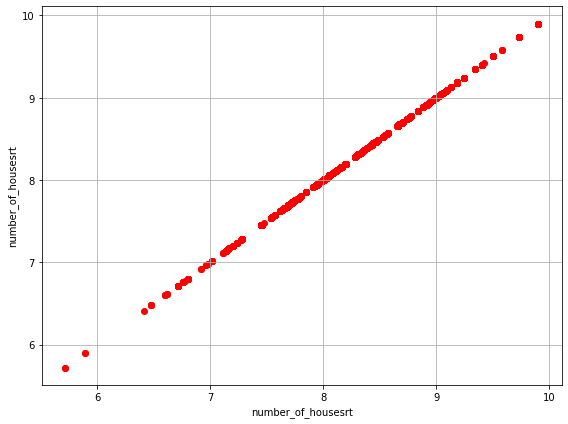

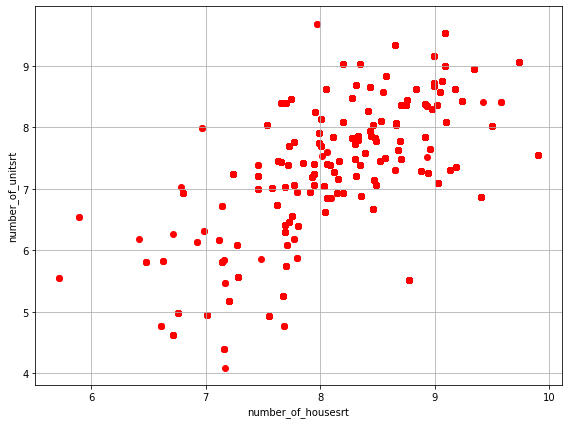

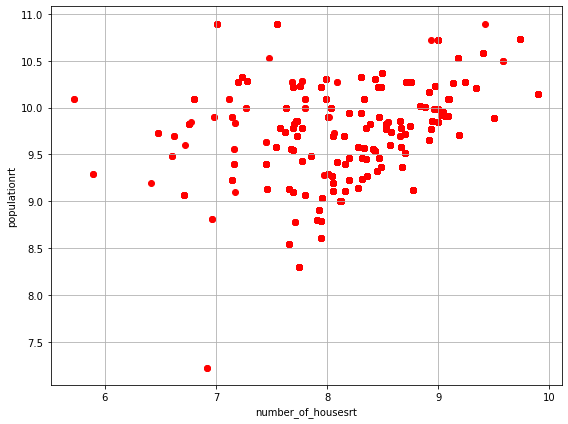

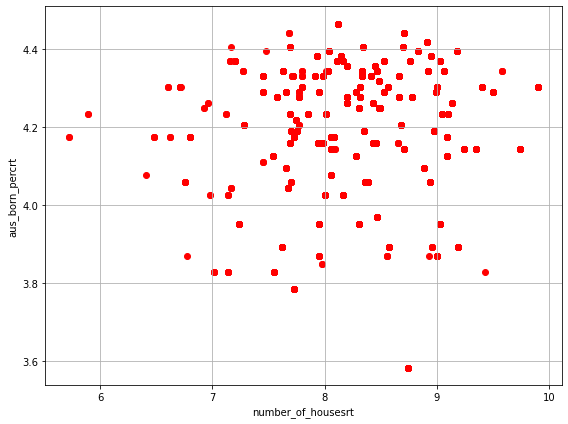

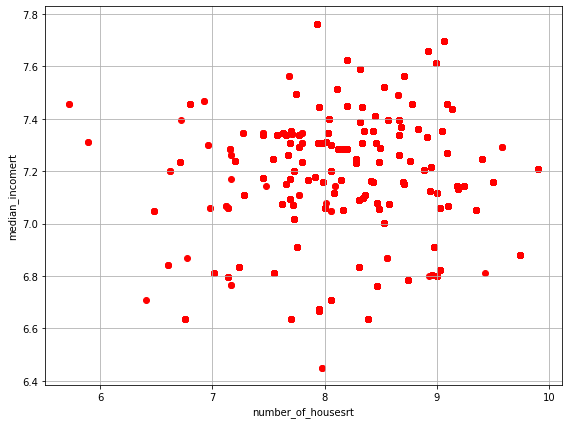

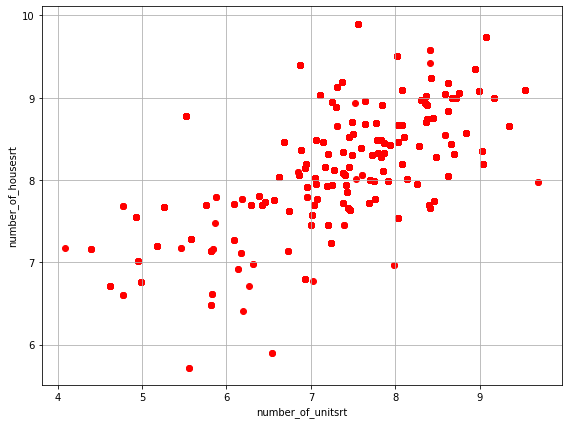

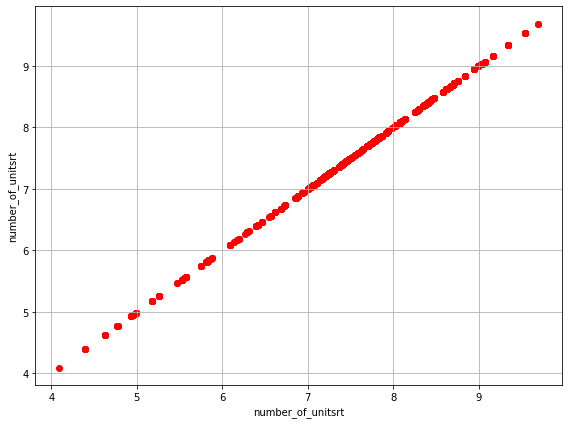

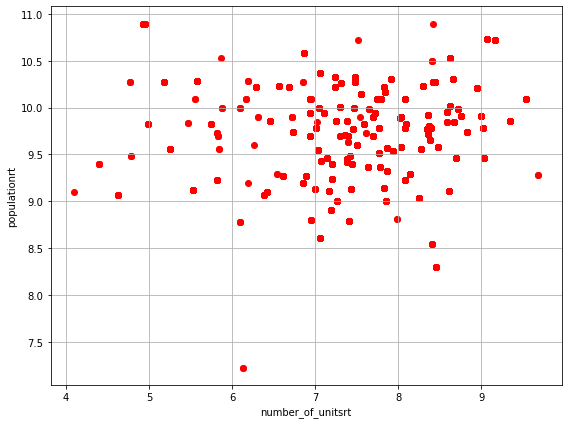

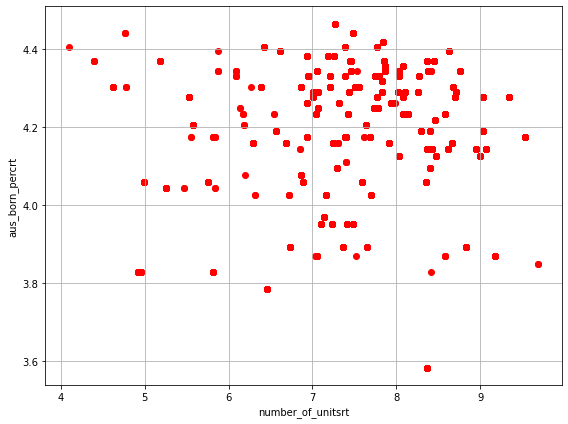

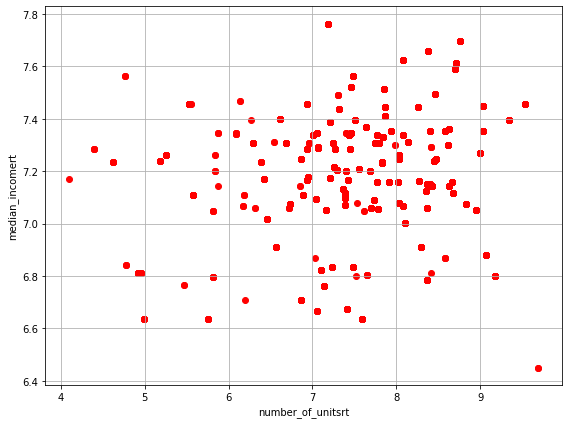

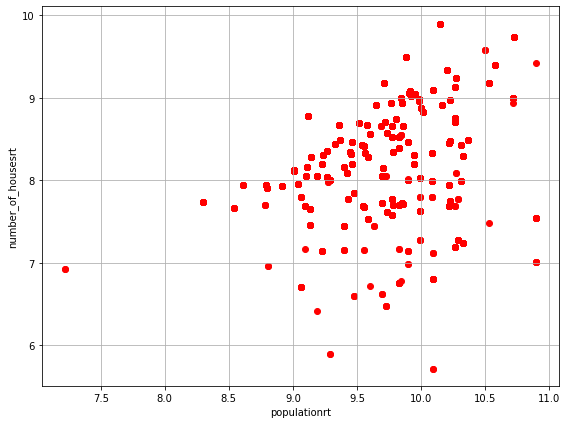

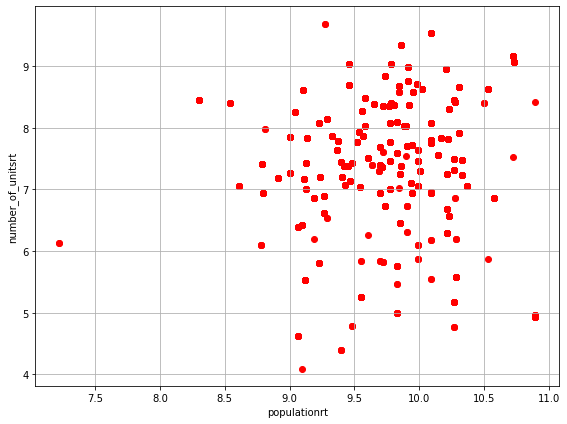

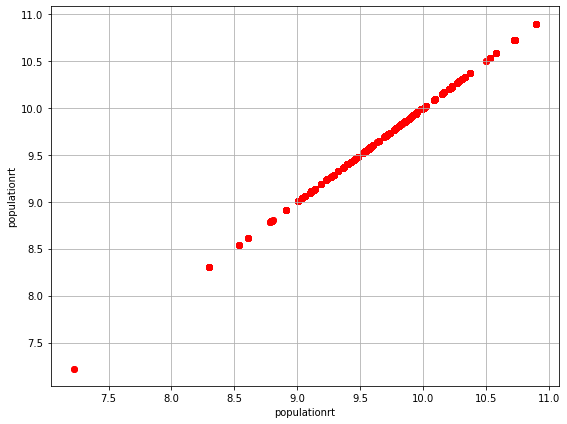

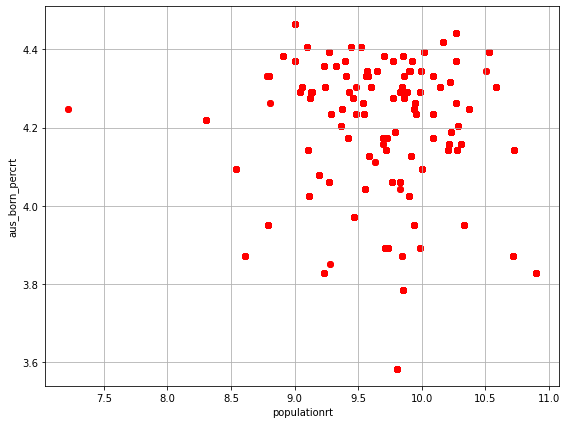

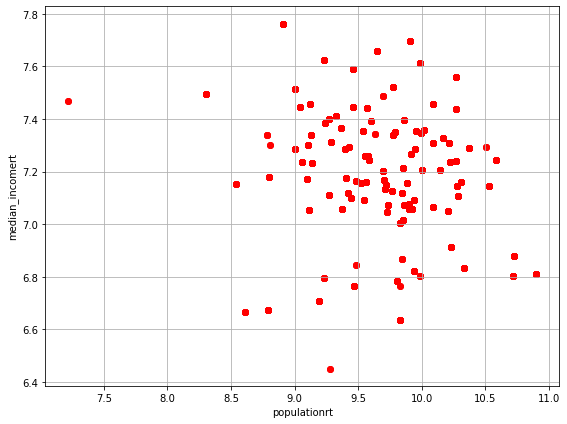

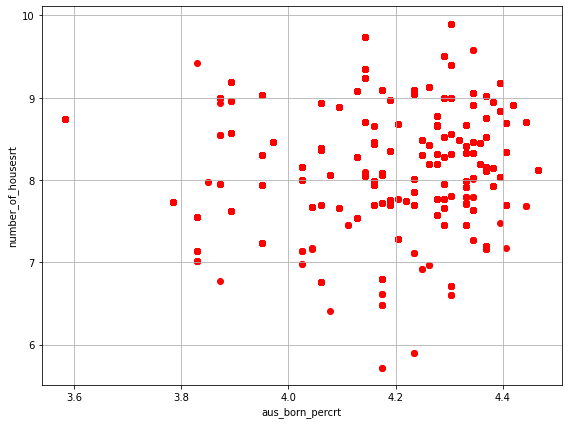

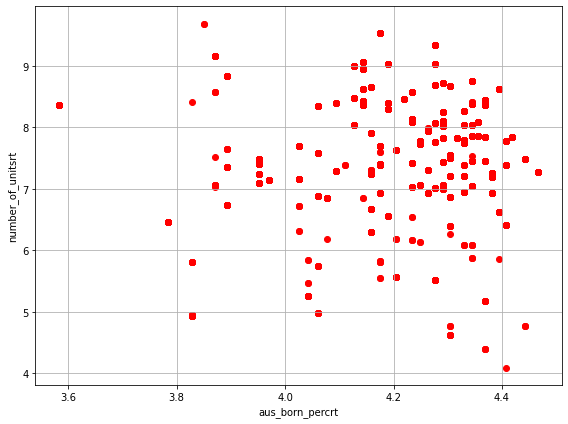

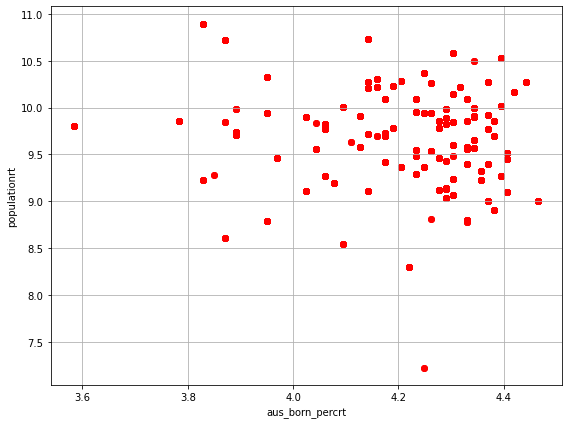

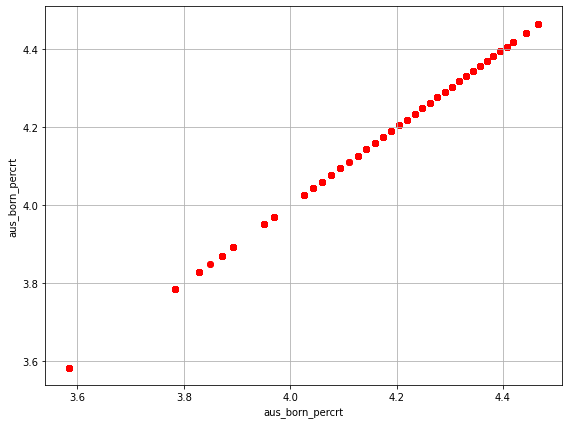

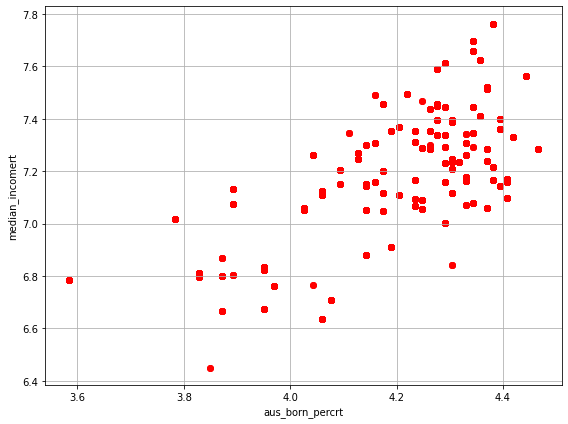

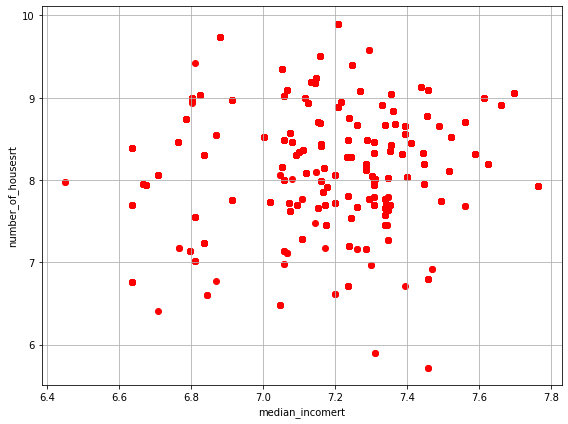

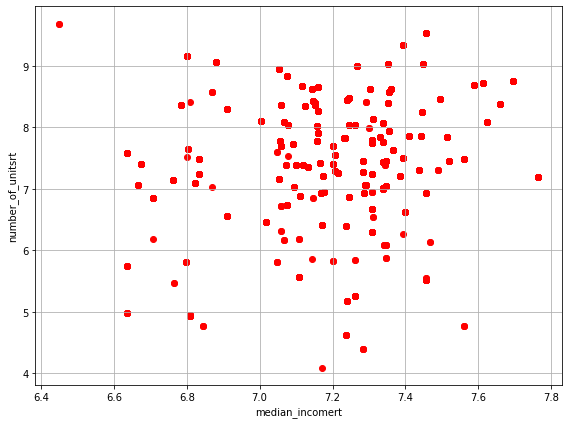

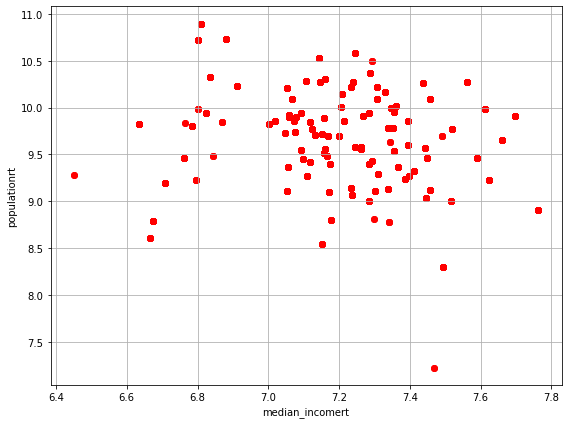

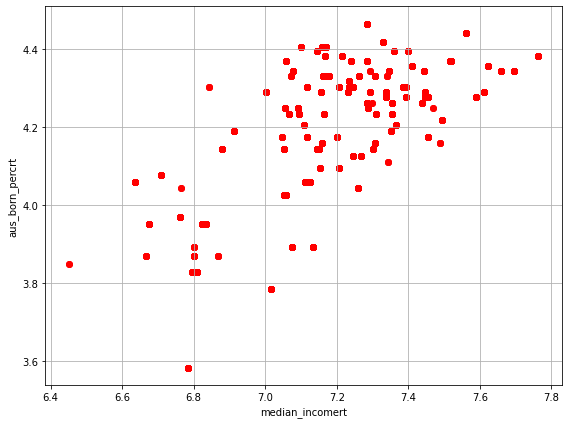

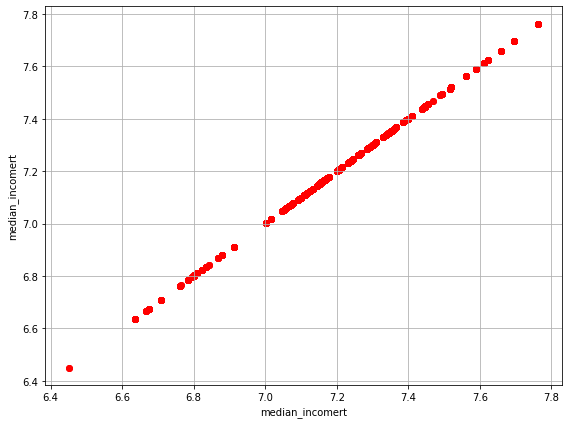

In [932]:
# for all the variables against each other
%matplotlib inline
for x33 in  range(0,5):
    for x44 in range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[xyy[x33]], df_transform[xyy[x44]], color='red')

        plt.xlabel(xyy[x33])
        plt.ylabel(xyy[x44])
        plt.grid()
        plt.tight_layout()


plt.show()

<ipython-input-934-3dae90fa4f68>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,6))


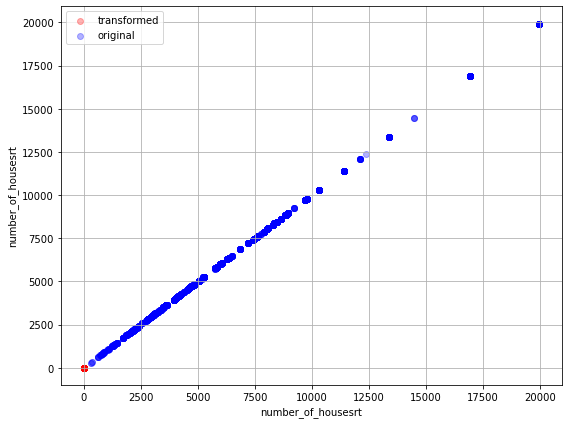

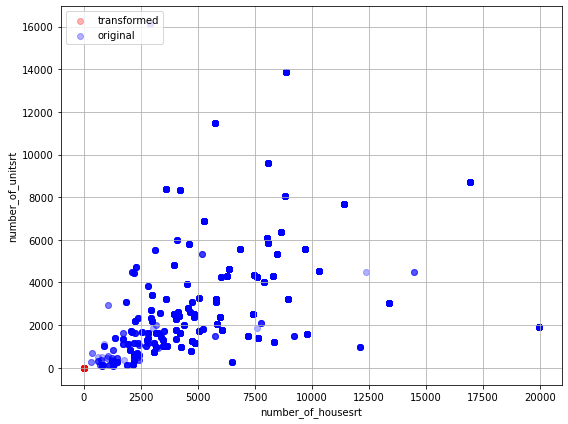

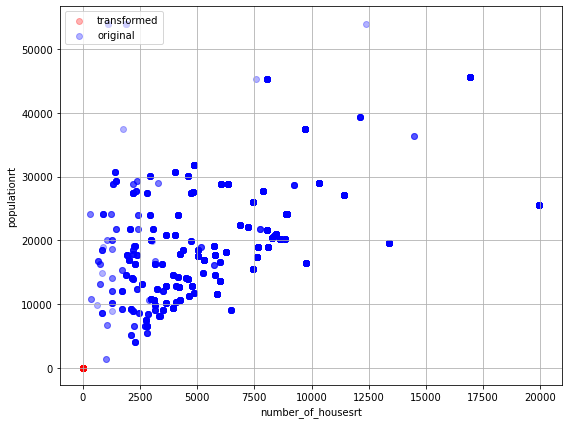

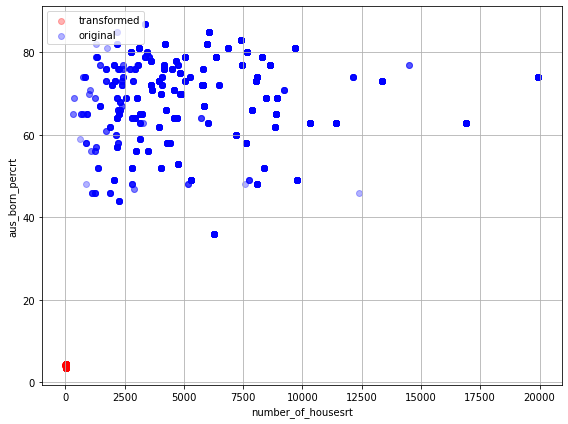

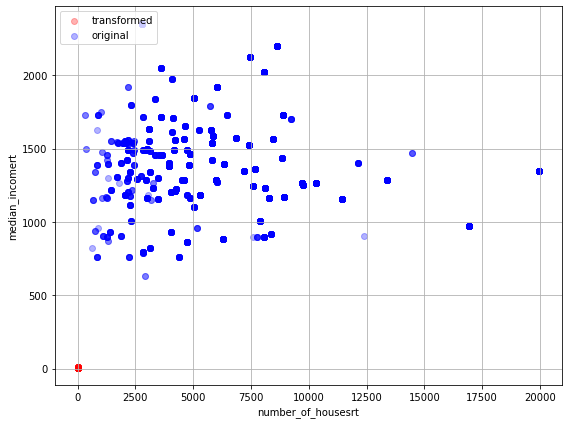

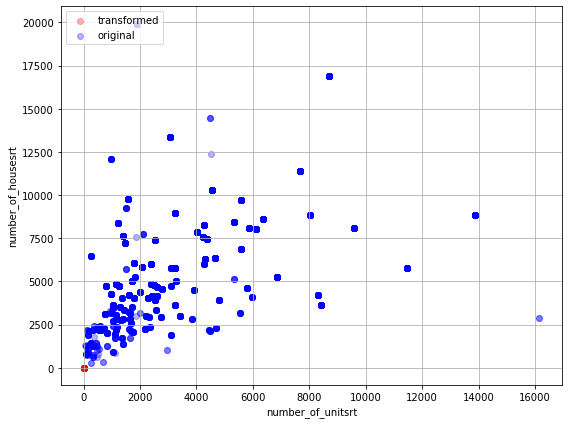

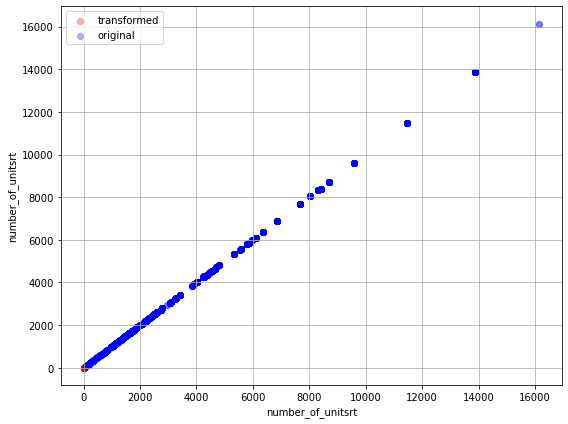

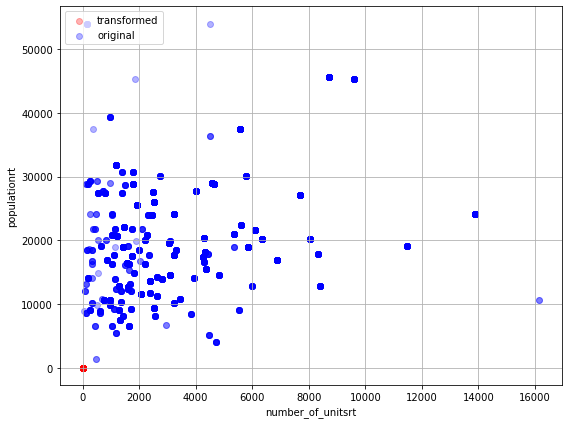

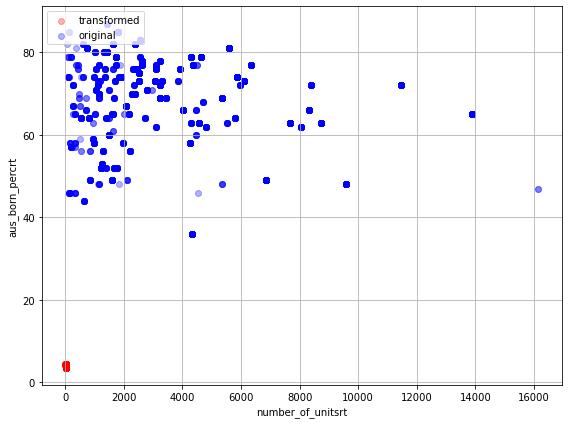

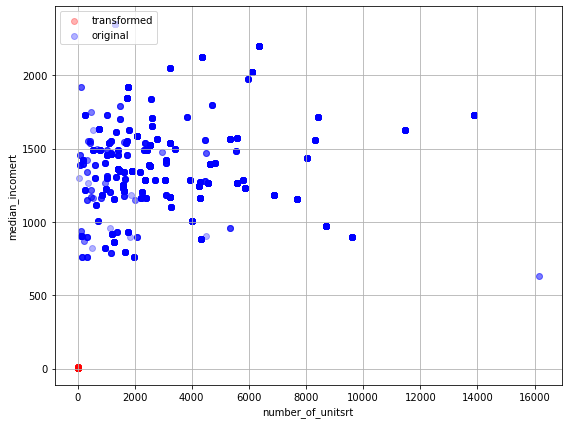

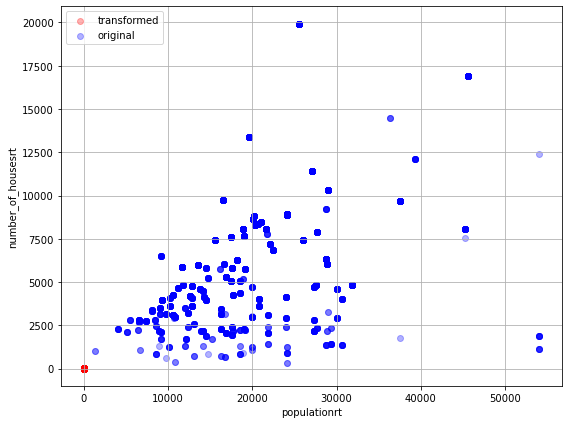

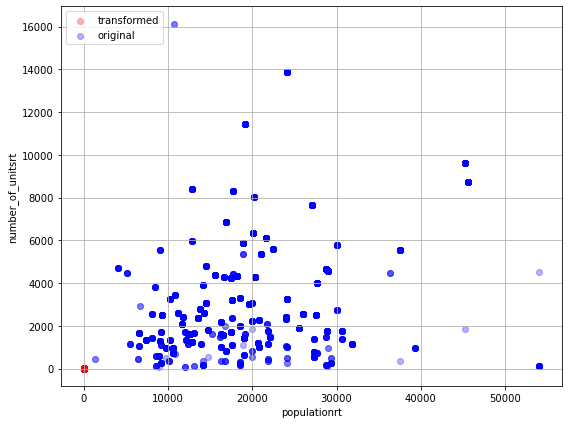

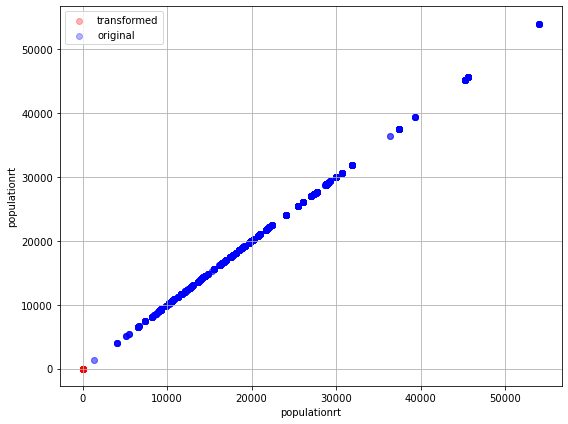

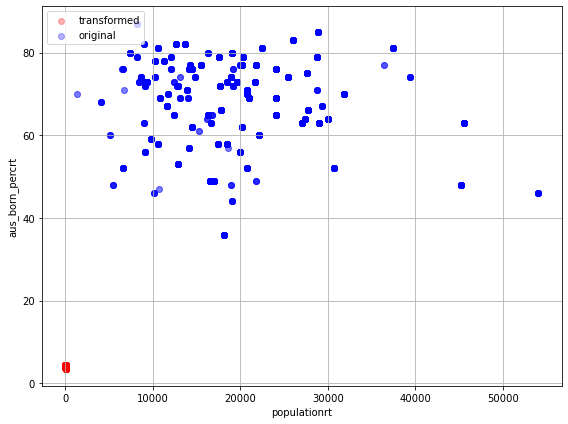

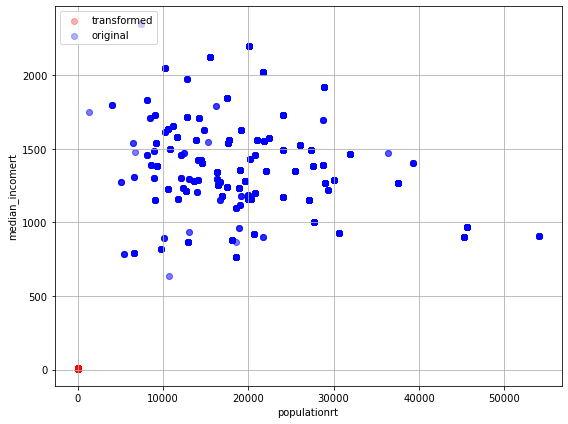

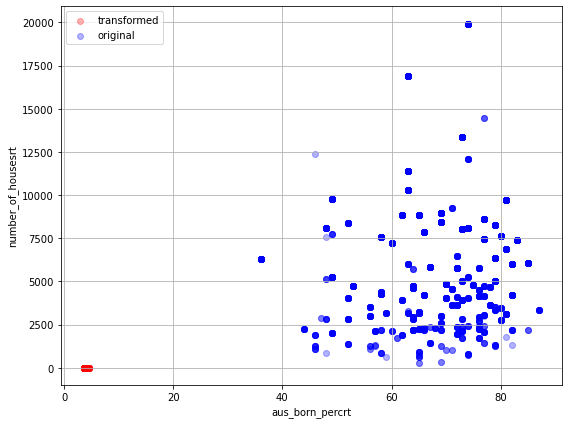

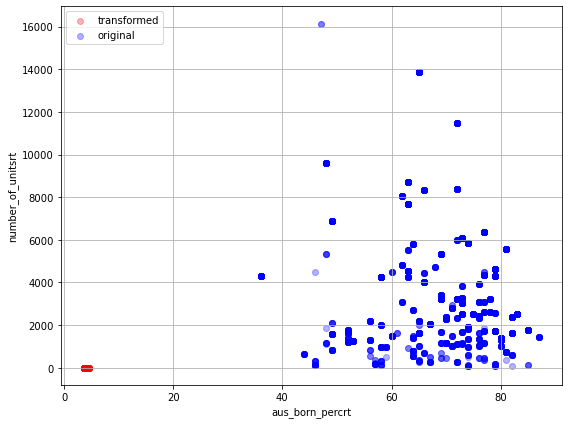

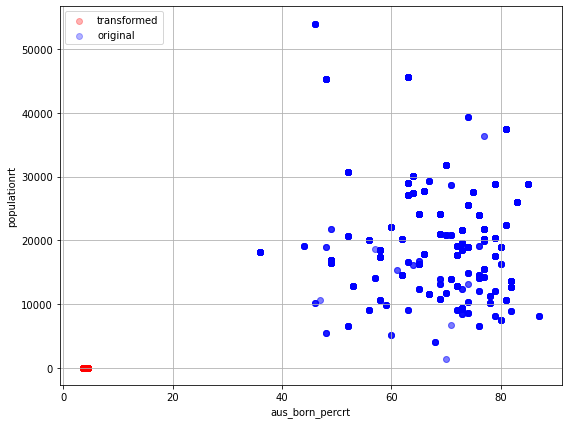

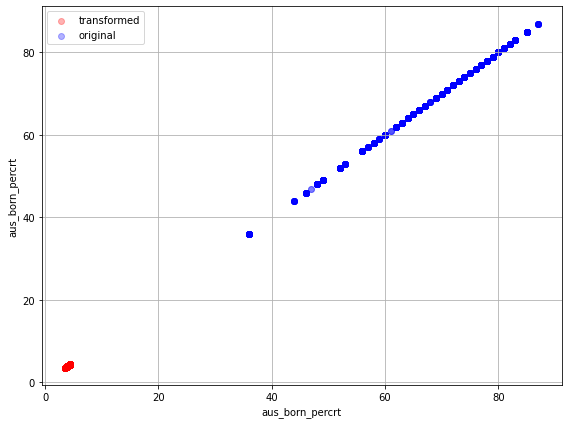

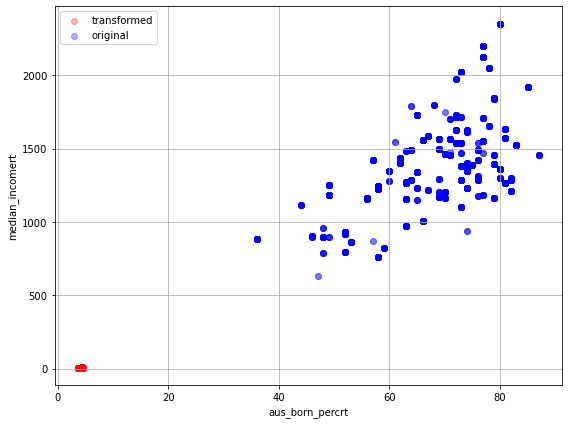

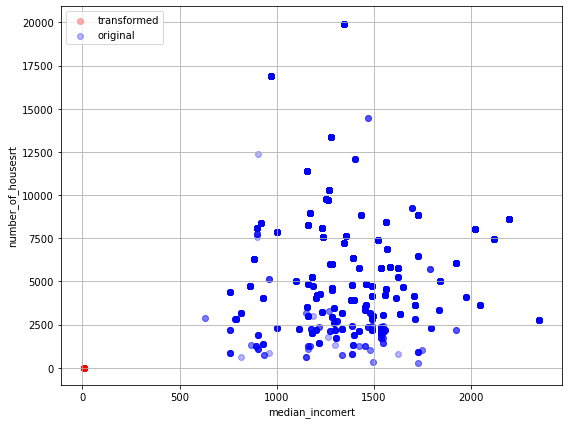

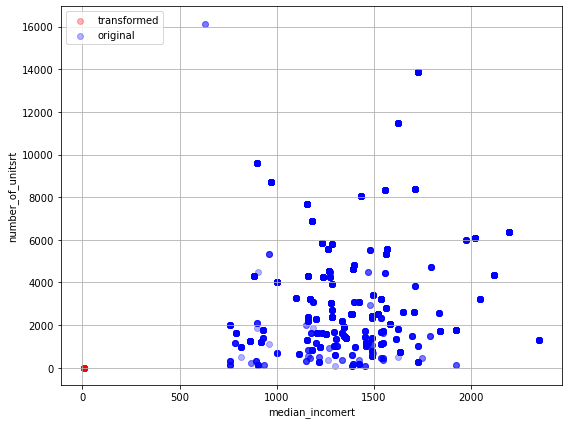

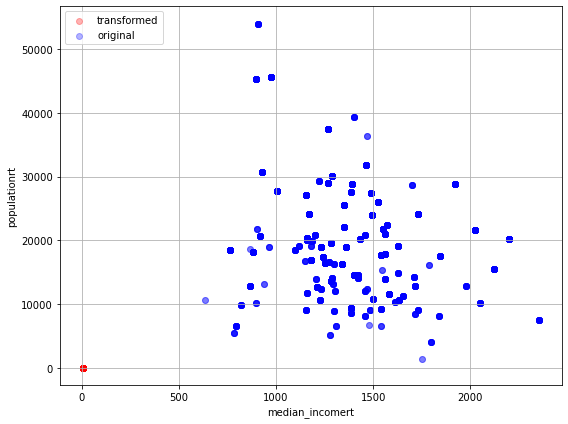

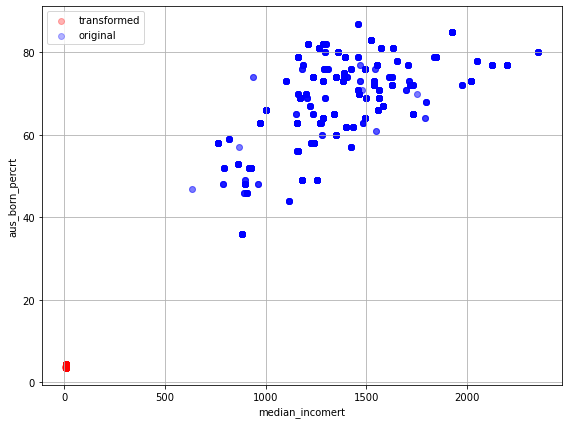

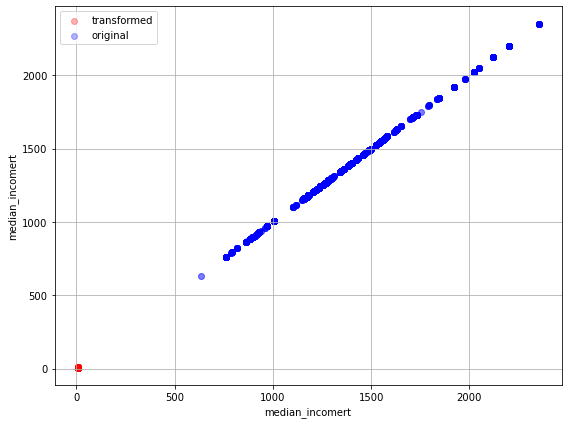

In [934]:
#for all the variables against each other compared to orginal data.
%matplotlib inline
for x33 in  range(0,5):
    for x44 in range(0,5):
        f = plt.figure(figsize=(8,6))


        plt.scatter(df_transform[xyy[x33]], df_transform[xyy[x44]], color='red',
          label='transformed',    alpha=0.3)
    
        plt.scatter(df_transform[x[x33]], df_transform[x[x44]],
            color='blue', label='original', alpha=0.3)


        plt.xlabel(x[x33])
        plt.ylabel(x[x44])
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()


plt.show()

We can see with the plot below that log transformation has reduced the size of the data greatly. When we plot the variable against each other after applying log transformation we see that the data points become more normalised and start appearing in a more linear pattern so it has the most postive impact here as compared to other transformations before.It has also compressed the data to make it more closely related and decrease bias while making it normalized. It also tends to compress the values of extreme outliers. This can help mitigate the influence of outliers on the model, as extreme values are shrunk closer to the mean. It also reduces the skewness and makes the variables more symmetrical. This can improve the linearity assumption between the independent variable and the dependent variable in the linear model.

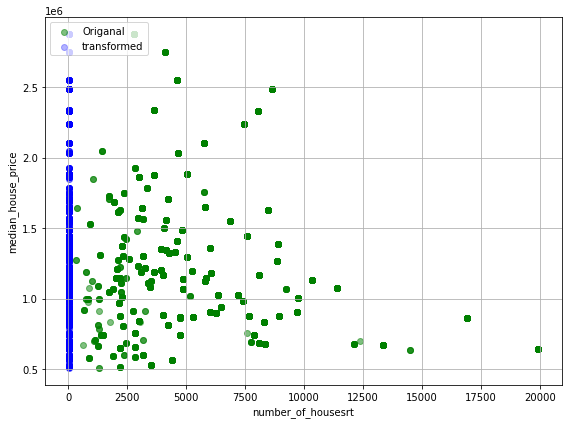

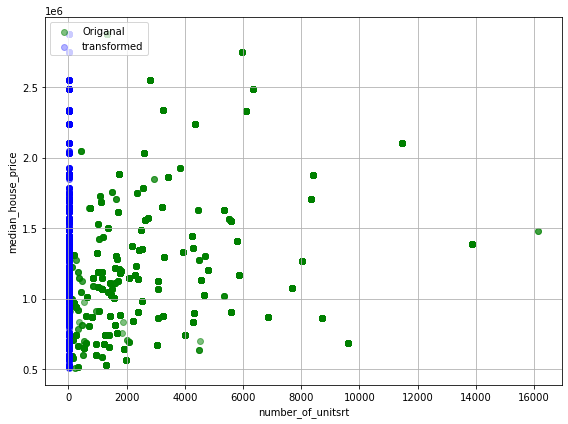

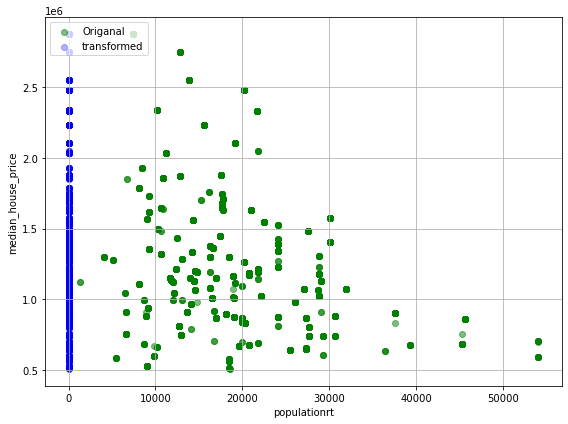

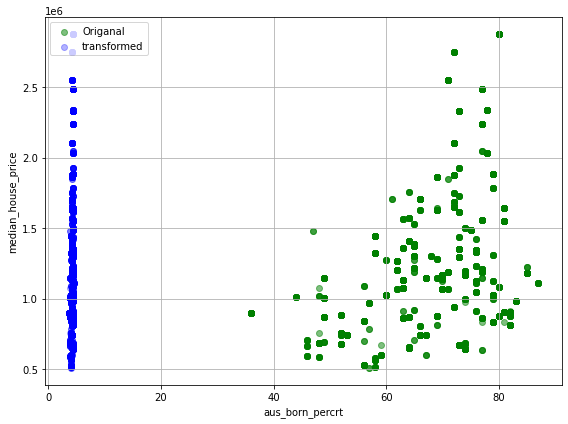

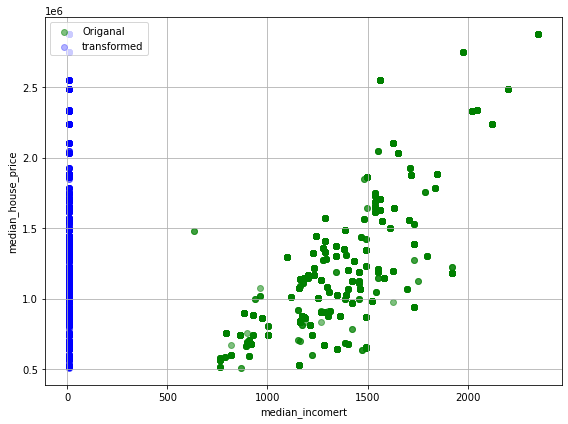

In [930]:
#all variables vs median_house_price before and after log transformation
%matplotlib inline
for x33 in  range(0,5):
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='Origanal', alpha=0.5)

    
        plt.scatter(df_transform[xyy[x33]], df_transform["median_house_price"],
            color='blue', label='transformed', alpha=0.3)


        plt.xlabel(xyy[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()
    #f.savefig("z_min_max.pdf", bbox_inches='tight')

plt.show()

Box-COX transformation
The Box-Cox transformation is a technique used to transform variables in order to meet the assumptions of a linear model, particularly addressing issues related to non-normality and heteroscedasticity. The transformation is defined by a parameter, lambda (λ), which determines the type of transformation applied. The can be usefull because of the following:
Normalization: The Box-Cox transformation can help normalize skewed variables by reducing skewness and making the variable distribution more symmetrical. This is particularly useful when the assumption of normality is violated in linear regression, as it allows for more accurate estimation of coefficients and better interpretation of results.

Linearizing relationships: In some cases, the relationship between the independent variables and the dependent variable may not be linear. The Box-Cox transformation can help linearize such relationships by applying appropriate power transformations. This enables the use of a linear model to capture the true underlying relationship more effectively.

Heteroscedasticity: Heteroscedasticity occurs when the variability of residuals is not constant across different levels of the independent variable. The Box-Cox transformation can help mitigate heteroscedasticity by stabilizing the variance. By transforming the variable, the transformed model may exhibit constant variance, making the model more reliable and valid.

Improving model fit: Applying the Box-Cox transformation can improve the fit of the linear model by reducing the impact of outliers and extreme values. Transforming the data can make it less sensitive to extreme observations and result in a better fit to the majority of the data points.

Interpretability: The Box-Cox transformation can enhance the interpretability of the coefficients in the linear model. Depending on the estimated lambda value, the interpretation can be in terms of percentage change, geometric mean, or other meaningful interpretations, making it easier to understand the relationship between the variables.


In [1063]:
for x989 in range(len(df_transform)):
    df_transform['number_of_houses'].iloc[x989] = int(df_transform['number_of_houses'].iloc[x989])
    df_transform['number_of_units'].iloc[x989] = int(df_transform['number_of_units'].iloc[x989])
    df_transform['population'].iloc[x989] = int(df_transform['population'].iloc[x989])
    df_transform['aus_born_perc'].iloc[x989] = int(df_transform['aus_born_perc'].iloc[x989])
    df_transform['median_income'].iloc[x989] = int(df_transform['median_income'].iloc[x989])

C:\Users\Ro\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-1063-74051591b408>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number_of_houses'].iloc[x989] = int(df_transform['number_of_houses'].iloc[x989])
<ipython-input-1063-74051591b408>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transform['number

In [1054]:
type(df_transform['aus_born_perc'][0])

numpy.float64

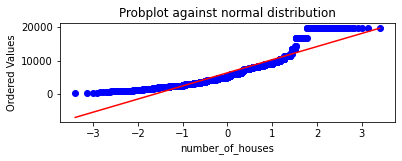

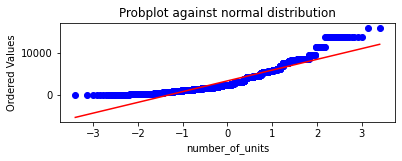

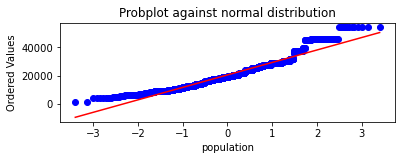

In [1056]:
#initail distribution before box cox
for xi in range(0,3):

        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        prob = stats.probplot(df_transform[x[xi]], dist=stats.norm, plot=ax1)
        ax1.set_xlabel(x[xi])
        ax1.set_title('Probplot against normal distribution')

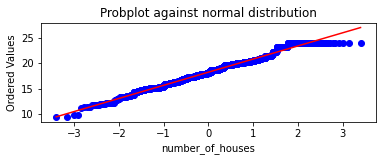

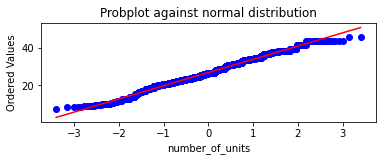

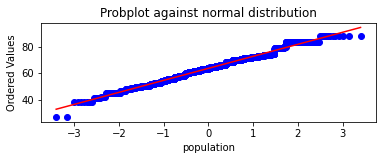

In [1097]:
#After using box cox
for xi in range(0,3):

        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        xt, _ = stats.boxcox(df_transform[x[xi]])
        prob = stats.probplot(xt, dist=stats.norm, plot=ax1)
        ax1.set_xlabel(x[xi])
        ax1.set_title('Probplot against normal distribution')

In [1010]:
fitted_data, fitted_lambda = stats.boxcox(df_transform['number_of_houses'])

C:\Users\Ro\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ro\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Ro\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an 

Lambda value used for Transformation: 0.15829630878750284
Lambda value used for Transformation: 0.2665669592997265
Lambda value used for Transformation: 0.3061581606694528

C:\Users\Ro\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


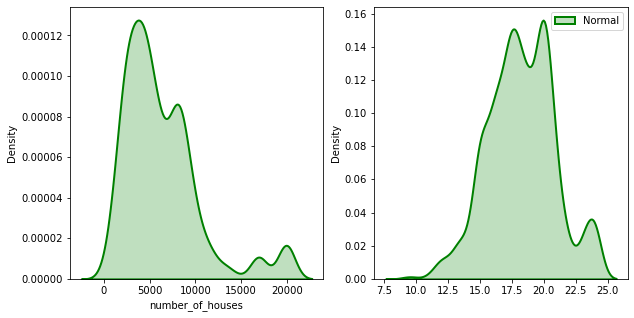

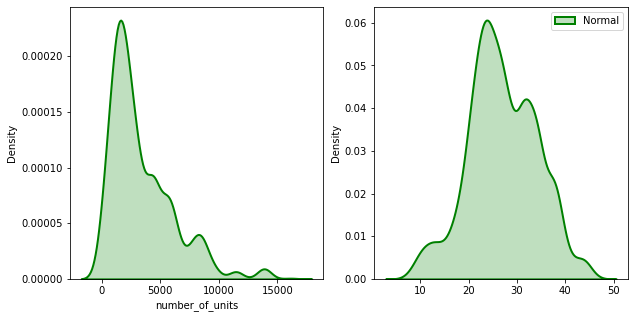

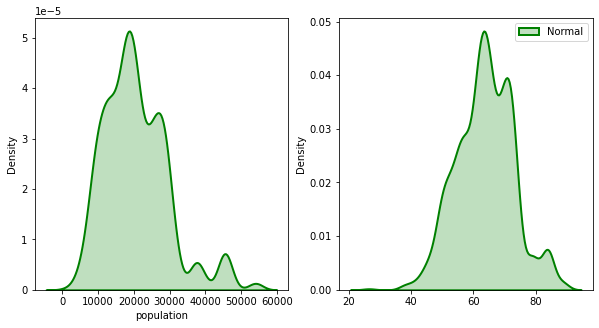

In [1057]:
for x232 in x[0:3]:
    fitted_data, fitted_lambda = stats.boxcox(df_transform[x232])
    fig, ax = plt.subplots(1, 2)
 

    # fitted data (normal)
    sns.distplot(df_transform[x232], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
    sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
    # adding legends to the subplots
    plt.legend(loc = "upper right")
 
    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
 
    print(f"Lambda value used for Transformation: {fitted_lambda}")

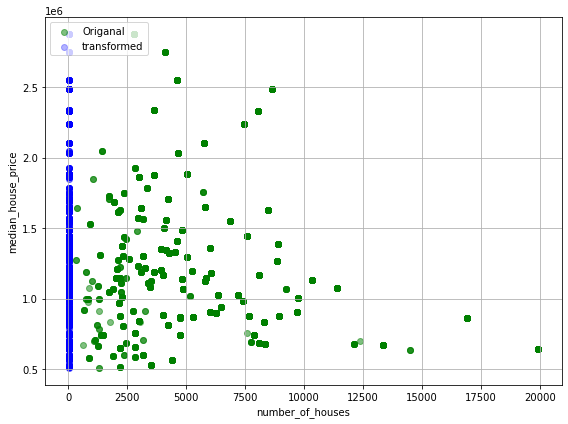

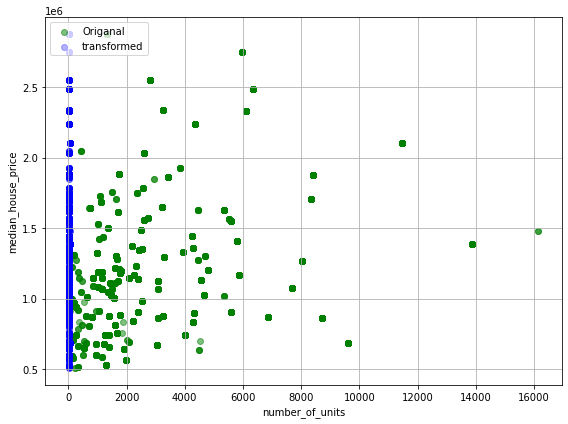

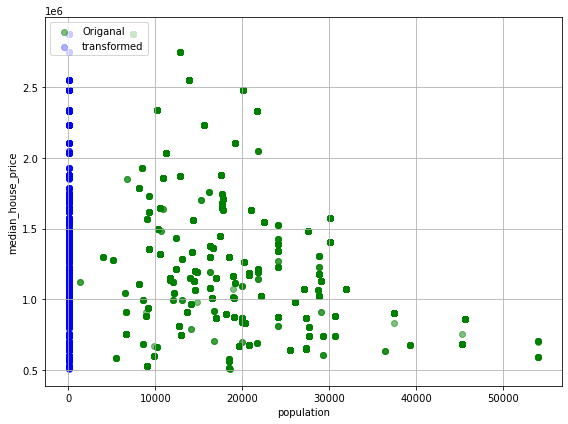

In [1087]:
%matplotlib inline
for x33 in  range(0,3):
        fitted_data, fitted_lambda = stats.boxcox(df_transform[x[x33]])
        f = plt.figure(figsize=(8,6))

        plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
            color='green', label='Origanal', alpha=0.5)
    
        plt.scatter(fitted_data, df_transform["median_house_price"],
            color='blue', label='transformed', alpha=0.3)


        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()
    #f.savefig("z_min_max.pdf", bbox_inches='tight')

plt.show()

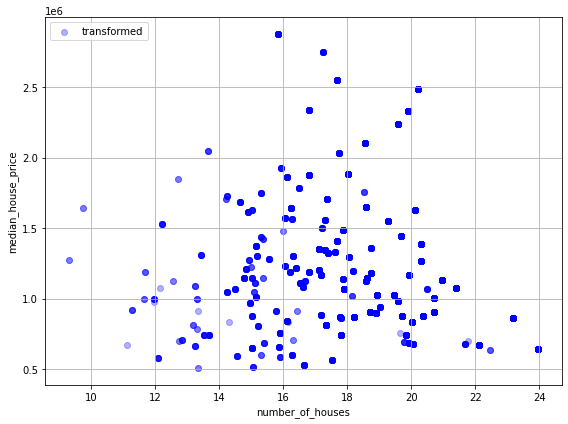

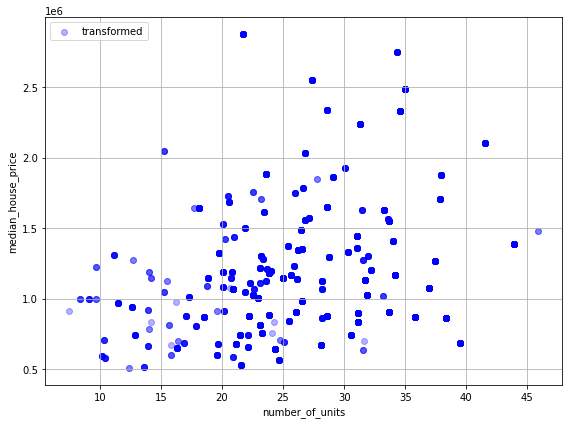

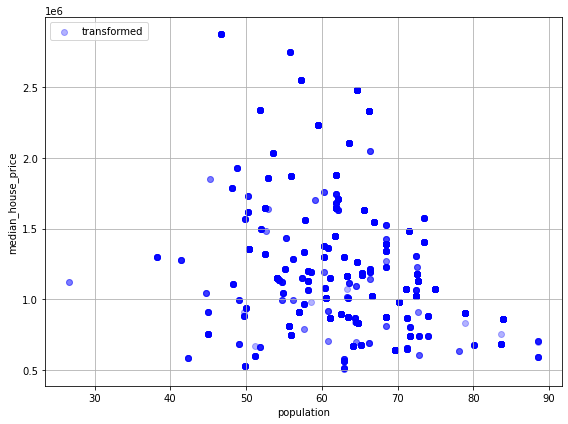

In [1069]:
%matplotlib inline
for x33 in  range(0,3):
        fitted_data, fitted_lambda = stats.boxcox(df_transform[x[x33]])
        f = plt.figure(figsize=(8,6))

        plt.scatter(fitted_data, df_transform["median_house_price"],
            color='blue', label='transformed', alpha=0.3)


        plt.xlabel(x[x33])
        plt.ylabel('median_house_price')
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()

plt.show()

In [1071]:
fittted = []
for x323 in x[0:3]:
    fitted_data, fitted_lambda = stats.boxcox(df_transform[x323])
    fittted.append(fitted_data)

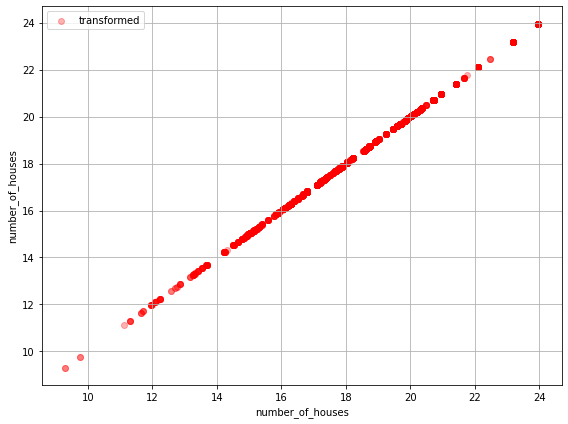

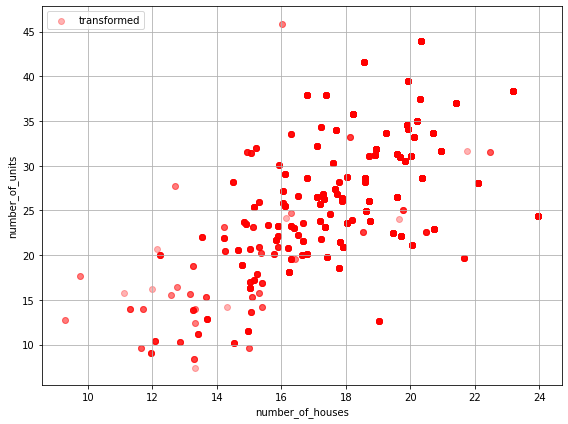

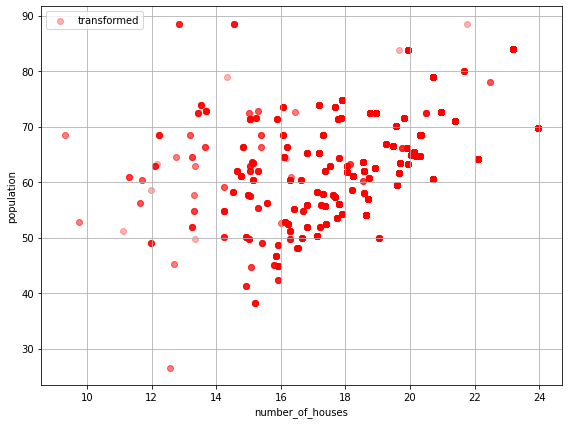

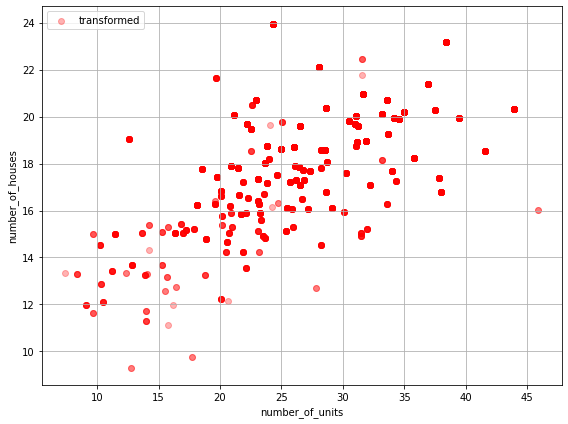

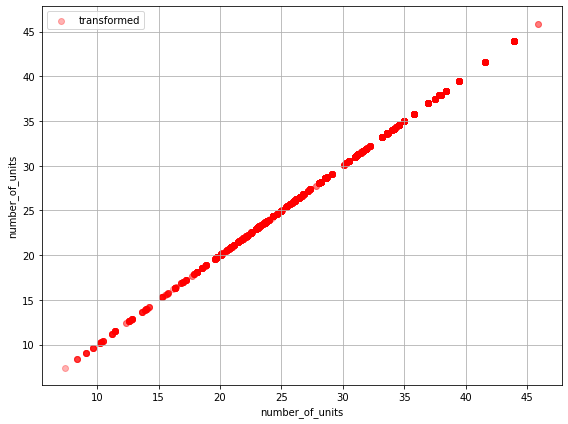

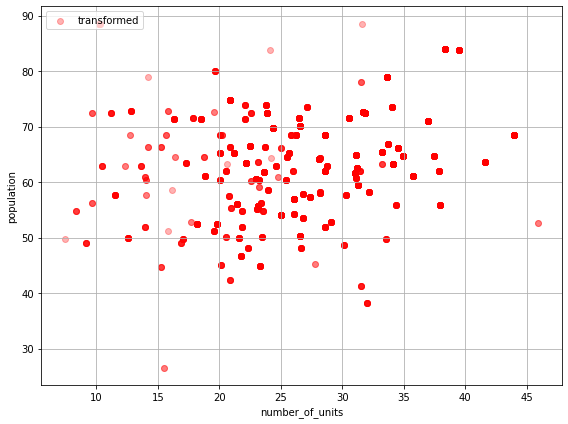

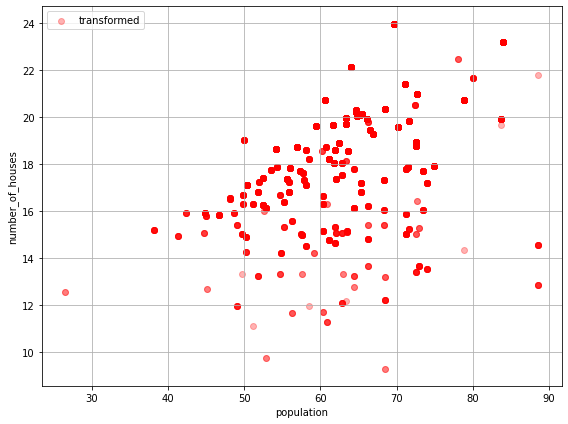

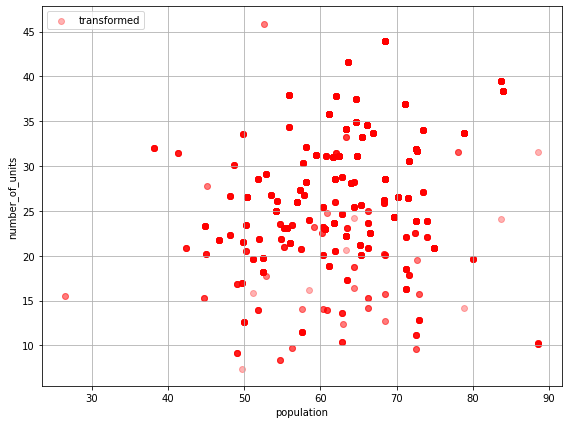

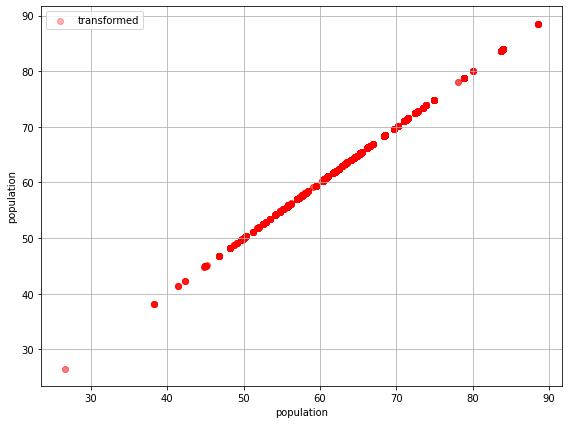

In [1073]:
%matplotlib inline
for x33 in  range(0,3):
    for x44 in range(0,3):
        f = plt.figure(figsize=(8,6))

        #plt.scatter(df_transform[x[x33]], df_transform["median_house_price"],
 #           color='green', label='input scale', alpha=0.5)


        plt.scatter(fittted[x33], fittted[x44], color='red',
          label='transformed',    alpha=0.3)
    
        #plt.scatter(df_transform[x[x33]], df_transform[x[x44]],
        #    color='blue', label='original', alpha=0.3)


        plt.xlabel(x[x33])
        plt.ylabel(x[x44])
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()
    #f.savefig("z_min_max.pdf", bbox_inches='tight')

plt.show()

As we can see from the data given above has quite an impact on the data, it normalize skewed variables by reducing skewness and making the variable distribution more symmetrical. Also its appears to be helping linearize the relationships by applying appropriate power transformations. This enables the use of a linear model to capture the true underlying relationship more effectively. It also appear to be improving the fit of the linear model by reducing the impact of outliers and extreme values. Transforming the data can make it less sensitive to extreme observations and result in a better fit to the majority of the data points. We can see that from first two plot how much it improves the fitting of the linear model. So due to these reason it is recommended to use this transformation along with the others decided above. 